## Predicting ESG Score and Sustainability Risk

### Problem Statement

This is the final project for the **Introduction to Supervised Learning** course at University of Colorado Boulder.

It focuses on showcasing supervised learning techniques and models to perform both **Regression** and **Classification** tasks in a given dataset.

- **Regression Analysis**: Predict the continuous `esg_score` variable, representing the score a particular company has related to their Environmental, Social and Governance levels. The greater the score, the better.
- **Classification Task**: Utilizing the `esg_risk` feature, classify the Sustainability Risk of a company, from LOW to HIGH.

---
### The Dataset

The dataset used in this project originates from the [**GHG Shopper**](https://www.ghgshopper.org) and [**Stakeholder Takeover**](https://www.stakeholdertakeover.org) initiatives.
I, **Dyego Fernandes de Sousa**, contributed to these projects as a Fullstack Developer.
Both projects are directed by [**Prof. Lynn M. LoPucki**](https://lopucki.com) of **UCLA Law School**. I have received his permission to use a raw dataset compiled for these endeavors.

The Dataset is raw, and was originally in MS Access, it contains non-normalize column names and lack the target variables we are seeking to predict.

The dataset is located in the **data** sub-directory, and it is a .csv file.

---
## Project structure

To keep the Jupyter notebook as clean as possible, I utilized an external python file to create the `SupervisedLearning` class, where the main source code is. If needed, please refer to the specific file `supervised_learning.py`.

### Steps I took in this project

#### Theme/Project Selection

My motivation for selecting this theme stems from two key factors. First, my previous professional experience working on environmental and ESG-related projects has provided me with domain expertise in this area. Second, I am currently contributing to an ESG scoring system at my company, which evaluates environmental, social, and governance metrics for companies and locations worldwide. Beyond personal experience, environmental sustainability remains a critically important yet underexplored area in data science applications, making it an ideal subject for this supervised learning project.
####  Dataset Selection

Among the numerous datasets available, I deliberately selected a raw, unprocessed dataset characterized by extensive missing values and numerous data quality challenges. This choice is particularly appropriate for an academic project, as it provides an authentic learning environment where I can demonstrate the comprehensive application of data preprocessing techniques and machine learning methodologies that, while applicable in real-world scenarios, are rarely showcased in their entirety with such challenging data.

The dataset's modest size and inherent complexity present several advantages for this educational context. First, the limited scale allows for thorough examination of each preprocessing decision and its impact on model performance. Second, the data quality issues—including missing values, non-standardized column names, and the absence of target variables—necessitate the application of fundamental data science skills such as feature engineering, imputation strategies, and careful handling of outliers. Third, working with real-world messy data, as opposed to pre-cleaned benchmark datasets, better reflects the challenges data scientists encounter in professional practice.

Furthermore, these challenges provide excellent opportunities to demonstrate the knowledge and technical skills acquired during this introductory supervised learning course. By addressing data quality issues, engineering meaningful features from raw inputs, and systematically evaluating multiple modeling approaches, this project showcases not only technical competency but also the critical thinking and problem-solving abilities essential for effective data science practice.
####  Exploratory Data Analysis
#### Pre-processing

Data preprocessing is critical for machine learning success, especially with raw, real-world datasets. This project implements a comprehensive preprocessing pipeline addressing multiple data quality challenges:

**1. Data Loading and Encoding Handling**
- Robust CSV parsing with automatic fallback through multiple encodings (UTF-8, Latin-1, CP1252)
- Ensures successful data import regardless of source system encoding

**2. Column Normalization**
- Standardizes all column names to lowercase with underscores replacing spaces
- Converts inconsistent naming conventions from legacy MS Access database to Python-friendly format
- Example: "Scope1+2Total" → "scope1+2total"

**3. Target Variable Engineering**
Since the raw dataset lacks the target variables needed for supervised learning, custom feature engineering creates both regression and classification targets:

- **`esg_score_raw` (Raw ESG Score)**:
  - For companies reporting emissions: `score = scope1+2total / revenues`
  - For non-reporting companies (excluding "realzero"): Penalized score using `(max_scope + 1) / (revenues × 0.75)`
  - For legitimate zero-emission companies ("realzero"): Special handling based on brand count to avoid artificially perfect scores
  - Optional exclusions penalty: Companies flagged with exclusions receive 10% penalty multiplier
  
- **`esg_score` (Normalized ESG Score - Regression Target)**:
  - Applies logarithmic transformation: `log₁₊ₓ(esg_score_raw)` to handle extreme skewness
  - Min-max normalization to scale scores to 0-100 range: `((log_score - min) / (max - min)) × 100`
  - Inverted scale: Higher scores indicate better ESG performance
  
- **`esg_risk` (Risk Classification - Classification Target)**:
  - Percentile-based classification into 5 risk categories: LOW, MEDIUM-LOW, MEDIUM, MEDIUM-HIGH, HIGH
  - Non-reporting companies (non-realzero) automatically classified as HIGH risk
  - Configurable percentile thresholds (default: 5th, 23rd, 55th, 78th percentiles)
  - Ensures balanced class distribution through percentile-based binning

This target engineering transforms unsupervised raw data into a supervised learning problem with both continuous (regression) and categorical (classification) objectives.

**4. Missing Value Treatment**
- **Detection**: Identifies columns with all NaN values and removes them to reduce dimensionality
- **Imputation**: Applies median imputation strategy (`SimpleImputer`) for numerical features with partial missing data
- **Strategic handling**: For emission data, distinguishes between truly missing values and legitimate zeros (companies with "realzero" flag)

**5. Feature Scaling and Standardization**
- **StandardScaler**: Applied separately for regression and classification tasks to prevent data leakage
- **Fit-transform pattern**: Scaler fitted only on training data, then applied to test data
- **Model-specific application**: SVM models receive scaled data; tree-based models work with unscaled features (scale-invariant)

**6. Logarithmic Transformation**
- Critical transformation to handle extreme right-skewness in emission/revenue ratios
- Applies `log₁₊ₓ` transformation: `log(1 + x)` to safely handle zero values
- Transforms ratios spanning 6+ orders of magnitude (0.009 to 3,412,000) into manageable range (-4.71 to 15.04)
- Enables meaningful normalization and prevents extreme outliers from dominating model training

**7. Data Type Conversions**
- Numeric coercion with error handling for scope, revenue, and realzero columns
- Ensures type consistency for mathematical operations

**8. Train-Test Split Strategy**
- 80/20 split with random state for reproducibility
- **Stratified sampling** for classification task to maintain class distribution balance
- Separate splits for regression and classification to optimize each task independently

This preprocessing pipeline transforms raw, inconsistent data into clean, normalized features suitable for machine learning algorithms while preserving data integrity and preventing common pitfalls like data leakage.

#### Feature Selection

Feature selection is crucial for model performance, interpretability, and computational efficiency. This project employs a multi-stage feature selection strategy:

**1. Domain-Driven Feature Exclusion**
The initial feature reduction removes irrelevant or problematic columns through domain expertise:

- **Time-series financial data** (2020-2021 sales figures, dates): Temporal features that introduce noise and are not predictive of current ESG performance
- **Metadata and documentation fields**: Non-predictive text fields (comments, URLs, permalinks, logos, website links)
- **Administrative identifiers**: Ranking columns, industry labels, parent company names that don't contribute to ESG prediction
- **High-cardinality categorical features**: Company names, subsidiary information that would require extensive encoding

**2. Post-EDA Feature Reduction**
After exploratory analysis, additional low-importance features are removed:

- **Revenue and emission area codes**: Geographic codes that showed minimal correlation with target variables
- **Disaggregated emission components**: Individual Scope1 and Scope2 values retained only when `scope1+2total` provides sufficient information
- **Undifferentiated emission fields**: Redundant or overlapping measurements

**3. Automatic Feature Validation**
The preprocessing pipeline includes runtime feature quality checks:

- **All-NaN detection**: Automatically identifies and removes features with 100% missing values
- **Variance analysis**: Implicitly handled through model training—features with zero variance don't contribute to splits

**4. Final Feature Set**
The refined feature set focuses on the most predictive variables:

- **Primary features**: `scope1+2total` (total greenhouse gas emissions), `scope2emitundifferentiated` (undifferentiated Scope 2 emissions)
- **Derived features**: Custom-engineered target variables (`esg_score`, `esg_risk`) based on emission-to-revenue ratios

**5. Feature Importance Analysis**
Post-training feature importance evaluation using:

- **Tree-based models**: Intrinsic feature importance from Decision Trees, Random Forest, AdaBoost, XGBoost
- **Top-N selection**: Identifies the most influential features for each task (regression vs. classification)
- **Model-specific insights**: Compares feature rankings across different algorithms to validate robustness

This systematic approach reduces dimensionality from 50+ raw columns to a focused set of 2-4 highly predictive features, improving model interpretability, reducing overfitting risk, and accelerating training while maintaining strong predictive performance. The strategy balances domain knowledge with data-driven insights, ensuring that only meaningful, non-redundant features enter the modeling pipeline.

####  Training
- **Decision Tree** - baseline
- **Random Forest** - ensemble
- **AdaBoost** - sequential ensemble
- **XGBoost** - *Not taught in the course, but worth trying*
- **Support Vector Machine** - alternative non-tree non-ensemble model
####  Model Optimization, Hyper-parameter tuning
- **GridSearchCV** - Utilized to perform exhaustive search over specified parameter grid combined with cross-validation for robust evaluation.

The following tables detail the hyperparameter search spaces explored during grid search optimization with 3-fold cross-validation:

##### Decision Tree Hyperparameters

| Hyperparameter | Values Explored | Description |
|----------------|-----------------|-------------|
| `max_depth` | [1, 2, 3, 5, 7, 8, 10, 15, None] | Maximum depth of the tree; None allows unlimited depth |
| `min_samples_split` | [1, 2, 3, 5, 7, 9, 10, 12, 13, 15, 20, 25] | Minimum samples required to split an internal node |
| `min_samples_leaf` | [1, 2, 4, 8, 10] | Minimum samples required to be at a leaf node |
| `max_features` | ['sqrt', 'log2', None] | Number of features to consider when looking for best split |
| `class_weight` | [None, 'balanced'] | Weights associated with classes (classification only) |

**Total combinations (Regression):** 9 × 12 × 5 × 3 = **1,620 configurations**

**Total combinations (Classification):** 9 × 12 × 5 × 3 × 2 = **3,240 configurations**

##### AdaBoost Hyperparameters

| Hyperparameter | Values Explored | Description |
|----------------|-----------------|-------------|
| `n_estimators` | [5, 10, 25, 50, 75, 100, 150, 200, 300] | Number of boosting stages to perform |
| `learning_rate` | [0.001, 0.01, 0.1, 0.3, 10] | Weight applied to each classifier at each iteration |
| `loss` | ['linear', 'square', 'exponential'] | Loss function to use when updating weights (regression only) |
| `random_state` | [42] | Random seed for reproducibility |

**Total combinations (Regression):** 9 × 5 × 3 × 1 = **135 configurations**

**Total combinations (Classification):** 9 × 5 × 1 = **45 configurations** (loss parameter excluded)

##### Random Forest Hyperparameters

| Hyperparameter | Values Explored | Description |
|----------------|-----------------|-------------|
| `n_estimators` | [5, 10, 25, 50, 75, 100, 150, 200, 300] | Number of trees in the forest |
| `max_depth` | [1, 3, 5, 10, 15, 20, 30, None] | Maximum depth of each tree |
| `min_samples_split` | [1, 3, 5, 7, 10, 20, 25] | Minimum samples required to split an internal node |
| `min_samples_leaf` | [1, 2, 3, 4] | Minimum samples required to be at a leaf node |
| `bootstrap` | [True, False] | Whether bootstrap samples are used when building trees |
| `max_features` | ['sqrt', 'log2', None] | Number of features to consider when looking for best split |
| `class_weight` | [None, 'balanced', 'balanced_subsample'] | Weights associated with classes (classification only) |

**Total combinations (Regression):** 9 × 8 × 7 × 4 × 2 × 3 = **12,096 configurations**

**Total combinations (Classification):** 9 × 8 × 7 × 4 × 2 × 3 × 3 = **36,288 configurations**

##### Support Vector Machine (SVM) Hyperparameters

| Hyperparameter | Values Explored | Description |
|----------------|-----------------|-------------|
| `C` | [0.1, 1, 10] | Regularization parameter (inverse of regularization strength) |
| `gamma` | ['scale', 'auto', 0.001, 0.01] | Kernel coefficient for 'rbf' kernel |
| `kernel` | ['rbf', 'linear'] | Specifies the kernel type to be used |
| `class_weight` | [None, 'balanced'] | Weights associated with classes (classification only) |

**Total combinations (Regression):** 3 × 4 × 2 = **24 configurations**

**Total combinations (Classification):** 3 × 4 × 2 × 2 = **48 configurations**

##### XGBoost Hyperparameters

| Hyperparameter | Values Explored | Description |
|----------------|-----------------|-------------|
| `n_estimators` | [1, 5, 10, 25, 50, 75, 100, 150, 200] | Number of gradient boosted trees (boosting rounds) |
| `max_depth` | [1, 3, 6, 9, 10] | Maximum tree depth for base learners |
| `learning_rate` | [0.01, 0.1, 0.3] | Step size shrinkage to prevent overfitting (eta) |
| `subsample` | [0.8, 1.0] | Subsample ratio of the training instances |
| `colsample_bytree` | [0.8, 1.0] | Subsample ratio of columns when constructing each tree |

**Total combinations (Both Tasks):** 9 × 5 × 3 × 2 × 2 = **540 configurations**

---

**Cross-Validation Strategy:**
- **Method:** GridSearchCV with exhaustive search
- **CV Folds:** 3-fold cross-validation
- **Scoring Metrics:**
  - Regression: R² (coefficient of determination)
  - Classification: Accuracy
- **Parallel Processing:** `n_jobs=-1` (utilizes all available CPU cores)
- **Random State:** 42 (for reproducibility)



---

### Expected Deliverables

- One Trained model for ESG Score prediction (regression)
- One Trained model for ESG Sustainability Risk classification (multi-class classification)
- Comparative analysis of model performance
- Hyperparameter optimization results
- Feature importance analysis

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### The `SupervisedLearning` class is defined in the external file `supervised_learning.py` and imported here

In [26]:
# Auto-reload external modules before executing code
%load_ext autoreload
%autoreload 2
from supervised_learning import SupervisedLearning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Step 1: Load Data and Apply Log Transformation

### The Data Challenge

ESG emission-to-revenue ratios exhibit **extreme right-skewness** with outliers spanning multiple orders of magnitude. For example:
- Minimum ratio: ~0.009
- Median ratio: ~108
- Maximum ratio: ~3,412,000

### Why Linear Normalization Fails?
My first approach was applying linear normalization (min-max): `(x - min) / (max - min) × 100`

Because of the  **extreme outliers**, this formula compresses 99% of values to be very close to zero:
- A ratio of 100 becomes: `(100 - 0.009) / (3,412,000 - 0.009) × 100 ≈ 0.0029%`
- Result: No meaningful separation between risk categories

### The Log Transformation Solution

To apply **logarithmic transformation** using `log₁₊ₓ(score) = log(1 + score)`:

**Benefits:**
1. **Compresses range**: Transforms [0.009, 3,412,000] → [-4.71, 15.04]
2. **Preserves ordering**: If A > B, then log(A) > log(B)
3. **Handles zeros**: log(1 + 0) = 0 (safe for zero values)

**After log transformation:**
- Values are normally distributed
- Quantile-based classification creates balanced classes
- All risk categories are well-represented

Loaded dataset: 251 rows, 53 columns
score 48.981248263728126 >= 23 = MEDIUM
score 108.1040501482677 >= 78 = HIGH
score 14.82711389703921 >= 5 = MEDIUM-LOW
score 32.88476118271418 >= 23 = MEDIUM
score 36.837915674679365 >= 23 = MEDIUM
score 63.667820069204154 >= 55 = MEDIUM-HIGH
score 206.50565445026177 >= 78 = HIGH
score 18.759542989522455 >= 5 = MEDIUM-LOW
score 36.08278604651163 >= 23 = MEDIUM
score 6.185714285714286 >= 5 = MEDIUM-LOW
score 69.7484347826087 >= 55 = MEDIUM-HIGH
score 57.78201299841911 >= 55 = MEDIUM-HIGH
score 64.88828484848484 >= 55 = MEDIUM-HIGH
score 99.25607362793531 >= 78 = HIGH
score 2.5714285714285716 else... = LOW
score 58.135858585858585 >= 55 = MEDIUM-HIGH
score 84.8853112840467 >= 78 = HIGH
score 88.02370661427636 >= 78 = HIGH
score 68.26995341614906 >= 55 = MEDIUM-HIGH
score 41.260445682451255 >= 23 = MEDIUM
score 27.627912161408986 >= 23 = MEDIUM
score 64.09985191453353 >= 55 = MEDIUM-HIGH
score 26.083260407550945 >= 23 = MEDIUM
score 25.50721438145549 >

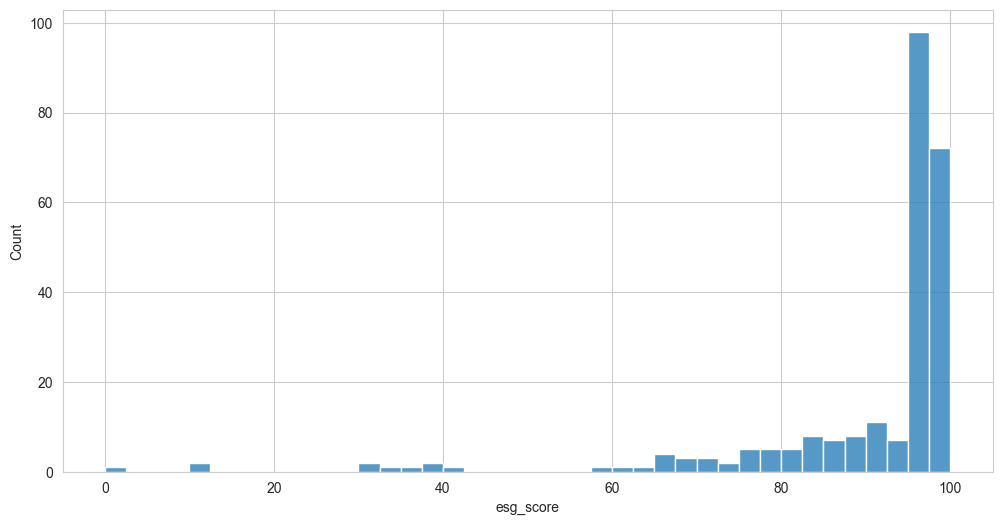


Histogram After log transformation


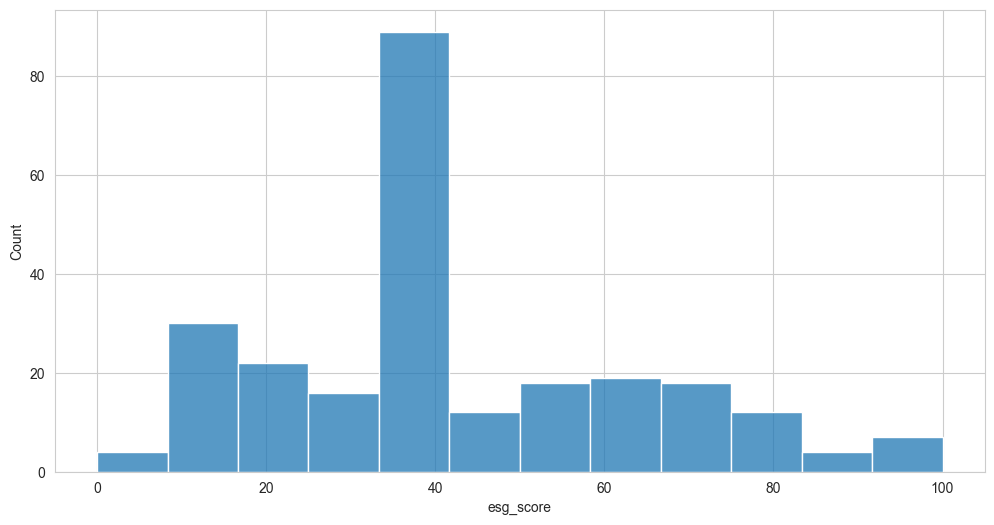

score 48.981248263728126 >= 23 = MEDIUM
score 108.1040501482677 >= 78 = HIGH
score 14.82711389703921 >= 5 = MEDIUM-LOW
score 32.88476118271418 >= 23 = MEDIUM
score 36.837915674679365 >= 23 = MEDIUM
score 63.667820069204154 >= 55 = MEDIUM-HIGH
score 206.50565445026177 >= 78 = HIGH
score 18.759542989522455 >= 5 = MEDIUM-LOW
score 36.08278604651163 >= 23 = MEDIUM
score 6.185714285714286 >= 5 = MEDIUM-LOW
score 69.7484347826087 >= 55 = MEDIUM-HIGH
score 57.78201299841911 >= 55 = MEDIUM-HIGH
score 64.88828484848484 >= 55 = MEDIUM-HIGH
score 99.25607362793531 >= 78 = HIGH
score 2.5714285714285716 else... = LOW
score 58.135858585858585 >= 55 = MEDIUM-HIGH
score 84.8853112840467 >= 78 = HIGH
score 88.02370661427636 >= 78 = HIGH
score 68.26995341614906 >= 55 = MEDIUM-HIGH
score 41.260445682451255 >= 23 = MEDIUM
score 27.627912161408986 >= 23 = MEDIUM
score 64.09985191453353 >= 55 = MEDIUM-HIGH
score 26.083260407550945 >= 23 = MEDIUM
score 25.50721438145549 >= 23 = MEDIUM
score 5.871428571428572

In [27]:
# Initialize trainer and load data

trainer = SupervisedLearning(
    percentiles={'low': 5, 'medium_low': 23, 'medium': 55, 'medium_high': 78},
    dt_params={'max_depth': [1,2,3,5,7,8,10,15,None], 'min_samples_split': [1,2,3,5,7,9,10,12,13,15,20,25], 'min_samples_leaf': [1,2,4,8,10], 'max_features': ['sqrt', 'log2', None], 'class_weight': [None, 'balanced']},
    ab_params={'n_estimators': [5,10, 25, 50, 75, 100, 150, 200, 300], 'learning_rate': [0.001, 0.01, 0.1, 0.3, 10], 'loss': ['linear', 'square', 'exponential'], 'random_state': [42]},
    rf_params={'n_estimators': [5, 10, 25, 50, 75, 100, 150, 200, 300], 'max_depth': [1, 3, 5, 10, 15, 20, 30, None], 'min_samples_split': [1, 3, 5, 7, 10, 20, 25], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False], 'max_features': ['sqrt', 'log2', None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
    svm_params={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.001, 0.01], 'kernel': ['rbf', 'linear'], 'class_weight': [None, 'balanced']},
    xgb_params={'n_estimators': [1, 5, 10, 25, 50, 75, 100, 150, 200], 'max_depth': [1, 3, 6, 9, 10], 'learning_rate': [0.01, 0.1, 0.3], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]},
    cv_folds=3,
    random_state=42,
    verbose=1,
    penalize_exclusions=True,
    drop_columns=[
                    #1st time series
                    '2020_food_sales', '2020_fs_adjust', '2021_food_sales', '2021_fs_adjust', '2020_total_sales', '2020_ts_adjust', '2021_total_sales', '2021_ts_adjust', '2020_fs_divided_by_ts', 'dateendfinancial2020', 'dateendfinancial2021', '2021_fs_divided_by_ts', 'yearghgdata', 'dateendghg',
                    #2nd known to be meaninless
                    'id', 'brandlogos', 'comments', 'exclusionstext', 'ghgpermalink', 'company_foreign', 'dateend10k', 'ghgreportname', 'ghgreportnotes', 'ghgreporturl', 'logodownco', 'namechangetoparent', 'rank', 'rankindustry', 'rankrevenues', 'subsidiary', 'website', 'sasbindustryshort',
                    #3rd features of less importance, after evaluation
                    'revenuesarea', 'ghgreportarea', 'scope2emitlocation', 'scope2emitmarket', 'scope1+2undiff','scope1emit', 'scope2total', 'revenuesghgco'
                ]
)

# Load CSV, normalize columns, and prepare data in one call
dataset_file = 'ghg_data.csv'
#dataset_file = 'synthetic_ghg_data.csv'
# Perfect for the log transformation
#dataset_file = 'synthetic_ghg_data_perfect_for_log.csv'

trainer.load_data(
    filepath=dataset_file,
    scope_col='scope1+2total',
    revenue_col='revenuesghgco',
    realzero_col='realzero',
    exclusions_col="exclusions",
    normalize_columns=True
)

trainer.calculate_esg_score()


trainer.classify_risk()

print("Risk Distribution:")
print(trainer.df['esg_risk'].value_counts().sort_index())
print(f"\nTotal records: {len(trainer.df)}")
print(f"\nESG Score distribution:")
print(trainer.df['esg_score'].describe())

print("Histogram Before log transformation")
sns.histplot(data=trainer.df, x="esg_score")
plt.show()

# Apply log(1 + x) transformation to handle zeros and create better distribution
trainer.df['esg_score_log'] = np.log1p(trainer.df['esg_score_raw'])

# Re-normalize using log-transformed scores
min_log_score = trainer.df['esg_score_log'].min()
max_log_score = trainer.df['esg_score_log'].max()
trainer.df['esg_score'] = ((trainer.df['esg_score_log'] - min_log_score) / (max_log_score - min_log_score)) * 100

#Plot the Histogram after log transformation
print("\nHistogram After log transformation")
sns.histplot(data=trainer.df, x="esg_score")
plt.show()

# Classify risk categories after the log transformation
trainer.classify_risk()

print(trainer.df[["exclusions", "brands", "esg_score_raw", "esg_score", "esg_risk"]].head(10))

print("Risk Distribution after log transformation:")
print(trainer.df['esg_risk'].value_counts().sort_index())
print(f"\nTotal records: {len(trainer.df)}")
print(f"\nESG Score distribution after log transformation:")
print(trainer.df['esg_score'].describe())

In [28]:
# Display dataset information and statistics
trainer.describe_data()

Raw dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          251 non-null    int64  
 1   2020_food_sales             227 non-null    float64
 2   2020_fs_adjust              45 non-null     object 
 3   2021_food_sales             226 non-null    float64
 4   2021_fs_adjust              39 non-null     object 
 5   2020_total_sales            226 non-null    float64
 6   2020_ts_adjust              25 non-null     object 
 7   2021_total_sales            226 non-null    float64
 8   2021_ts_adjust              31 non-null     object 
 9   2020_fs_divided_by_ts       226 non-null    float64
 10  2021_fs_divided_by_ts       226 non-null    float64
 11  brandlogos                  244 non-null    object 
 12  comments                    24 non-null     object 
 13  company_ghg_name 

---
## Step 2: Visualizations


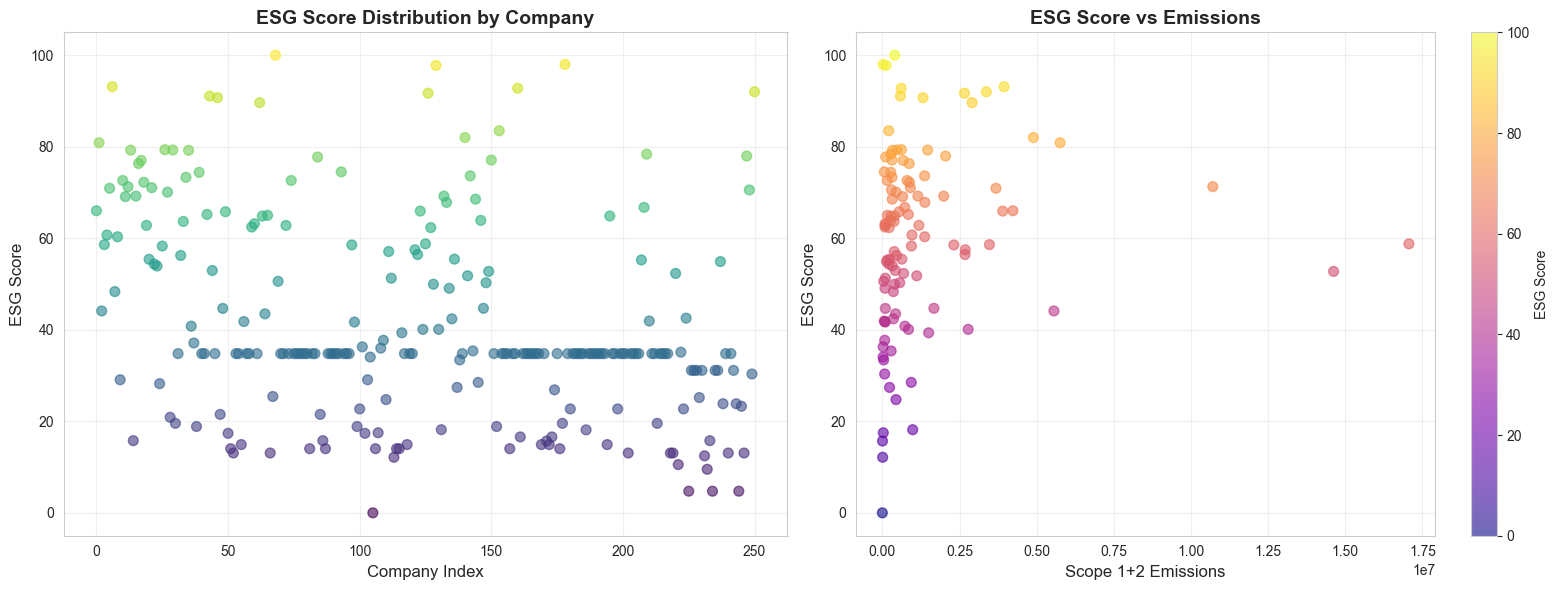

In [29]:
df_clean = trainer.df.dropna(subset=['esg_score', 'esg_risk', 'esg_score_raw', 'esg_score_log'])

# Visualization 1: ESG Score Distribution (Scatter Plots)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot 1: ESG Score vs Index
axes[0].scatter(range(len(df_clean)), df_clean['esg_score'], 
                alpha=0.6, s=50, c=df_clean['esg_score'], cmap='viridis')
axes[0].set_xlabel('Company Index', fontsize=12)
axes[0].set_ylabel('ESG Score', fontsize=12)
axes[0].set_title('ESG Score Distribution by Company', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Scatter plot 2: ESG Score vs Emissions
scatter = axes[1].scatter(df_clean[trainer.scope_col], df_clean['esg_score'], 
                          alpha=0.6, s=50, c=df_clean['esg_score'], cmap='plasma')
axes[1].set_xlabel('Scope 1+2 Emissions', fontsize=12)
axes[1].set_ylabel('ESG Score', fontsize=12)
axes[1].set_title('ESG Score vs Emissions', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='ESG Score')

plt.tight_layout()
plt.show()

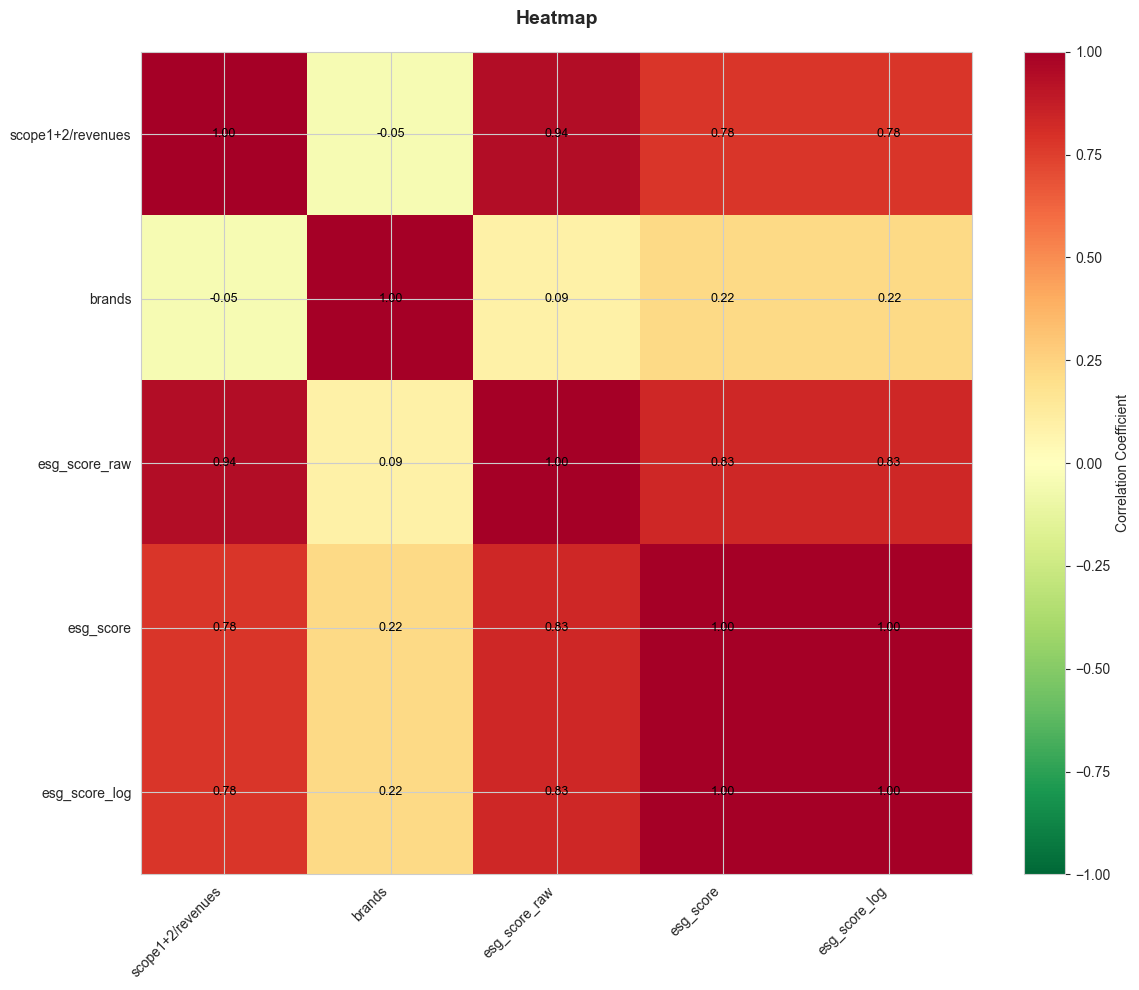

In [30]:
# Visualization 3: Correlation Heatmap
numerical_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
corr_features = [f for f in numerical_features if df_clean[f].notna().sum() > len(df_clean) * 0.5][:10]

corr_matrix = df_clean[corr_features].corr()

plt.figure(figsize=(12, 10))
im = plt.imshow(corr_matrix, cmap='RdYlGn_r', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation Coefficient')

plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center', color='black', fontsize=9)

plt.title('Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---
## Step 4: Feature Preparation and Train-Test Split


In [31]:
# Identify numerical features for modeling
numerical_features = trainer.df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target variables and ID columns
exclude_cols = ['esg_score', 'esg_score_raw', 'esg_score_log', 'company_id', 'year', 'scope1+2/revenues']
feature_cols = [col for col in numerical_features if col not in exclude_cols]

print(f"Selected {len(feature_cols)} features for modeling:")
print(feature_cols)

# Prepare features and split data
trainer.prepare_features(feature_cols).split_data(test_size=0.2)

print(f"Training samples (regression): {len(trainer.X_train_reg)}")
print(f"Test samples (regression): {len(trainer.X_test_reg)}")
print(f"Training samples (classification): {len(trainer.X_train_clf)}")
print(f"Test samples (classification): {len(trainer.X_test_clf)}")

Selected 5 features for modeling:
['realzero', 'scope2emitundifferentiated', 'scope1+2total', 'yearrevenuesdata', 'brands']
Removing 2 columns with all NaN values: ['realzero', 'yearrevenuesdata']
Applied median imputation to handle missing values in 3 features
Training samples (regression): 200
Test samples (regression): 51
Training samples (classification): 200
Test samples (classification): 51


---
## Step 5: Model Training with Hyperparameter Tuning


In [32]:
tempdf = trainer.df

trainer.df.drop(columns=['esg_score_log', 'esg_score_raw'], inplace=True)

### Regression - Untuned Models

Training Decision Tree (Untuned) Regressor...
REGRESSION VISUALIZATIONS FOR: Decision Tree (Untuned)

1. Model Performance Metrics:
   R² Score: 0.5813
   RMSE: 15.4847
   MAE: 8.3347

2. Actual vs Predicted Values:


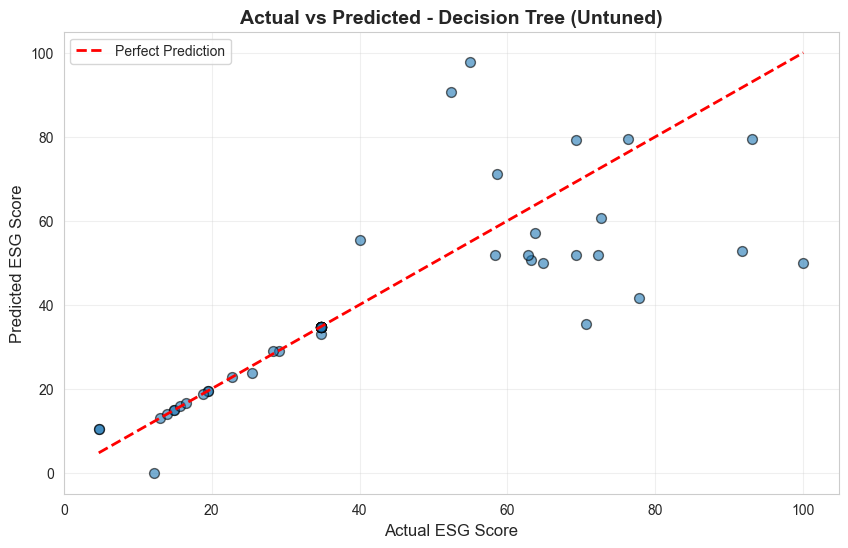


3. Residuals Plot:


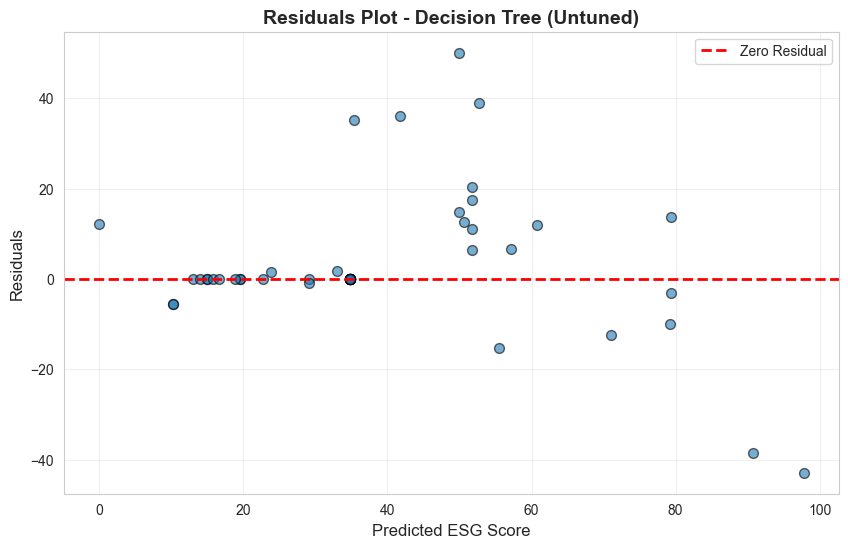


4. Residuals Distribution:


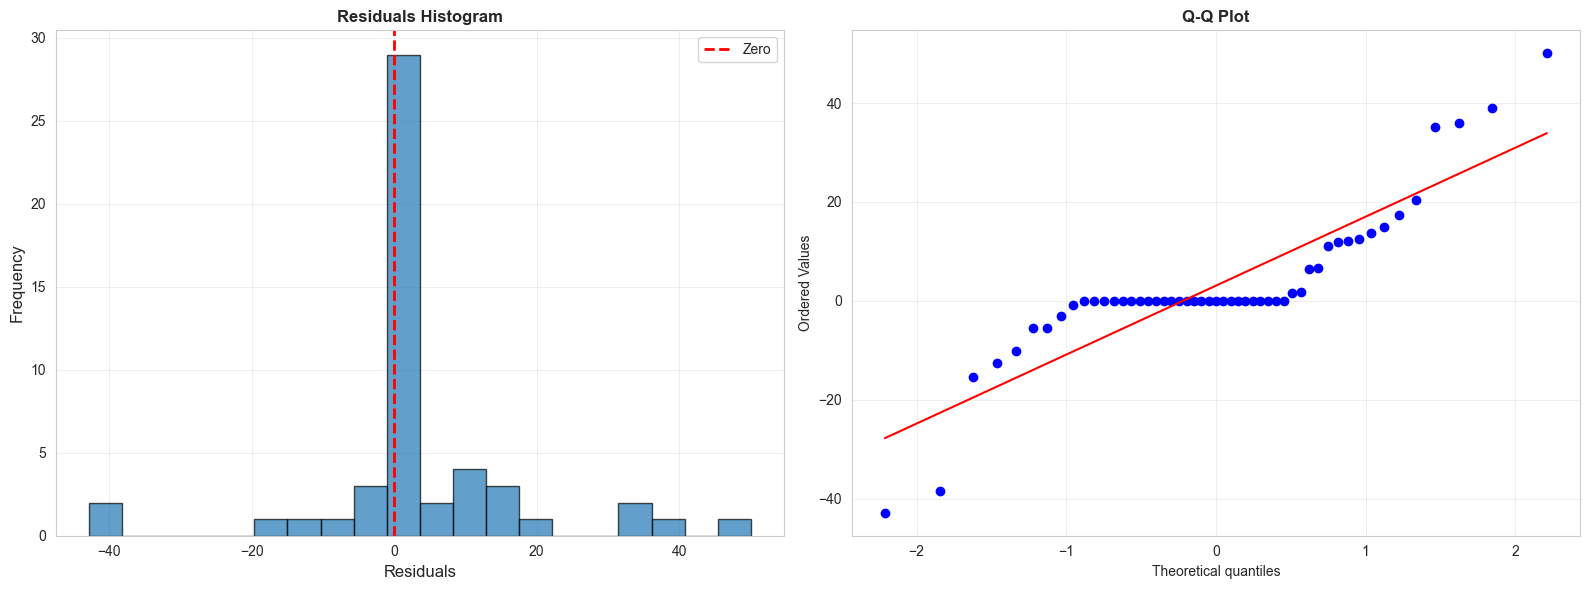


5. Error Metrics Summary:
   Mean Squared Error (MSE): 239.7768
   Root Mean Squared Error (RMSE): 15.4847
   Mean Absolute Error (MAE): 8.3347
   R² Score: 0.5813
   Mean Actual Value: 42.0092
   Mean Predicted Value: 38.9369
   Std of Residuals: 15.1769

6. Prediction Error Distribution:


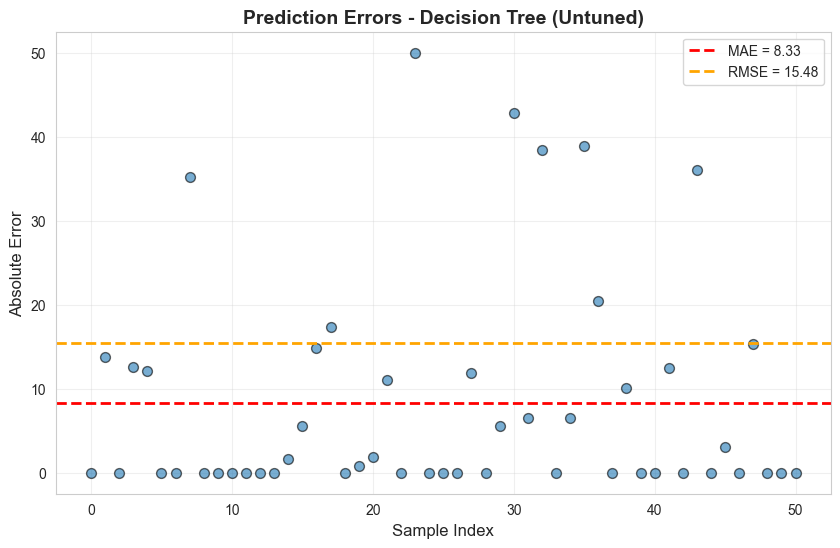

In [33]:
trainer.train_models(models=['dt'], task='regression', hyperparameter_tuning=False, show_viz=True)

Training AdaBoost (Untuned) Regressor...
REGRESSION VISUALIZATIONS FOR: AdaBoost (Untuned)

1. Model Performance Metrics:
   R² Score: 0.6059
   RMSE: 15.0229
   MAE: 10.5256

2. Actual vs Predicted Values:


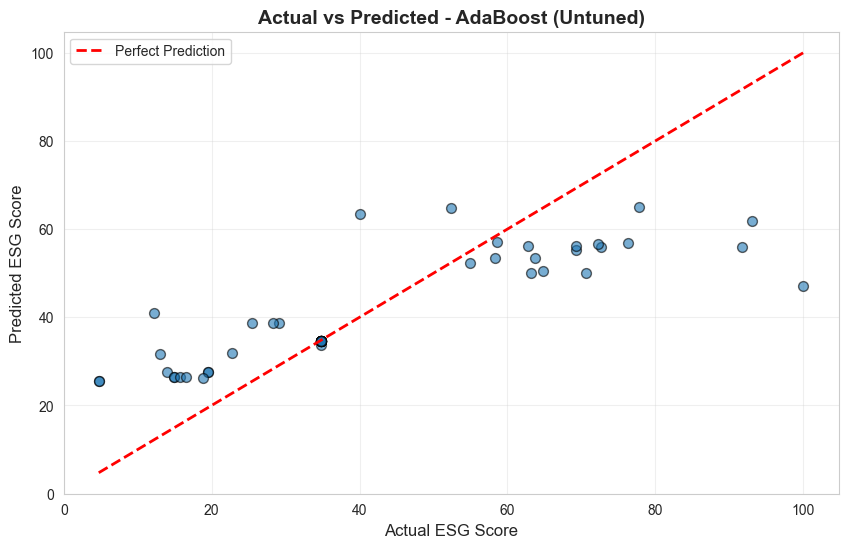


3. Residuals Plot:


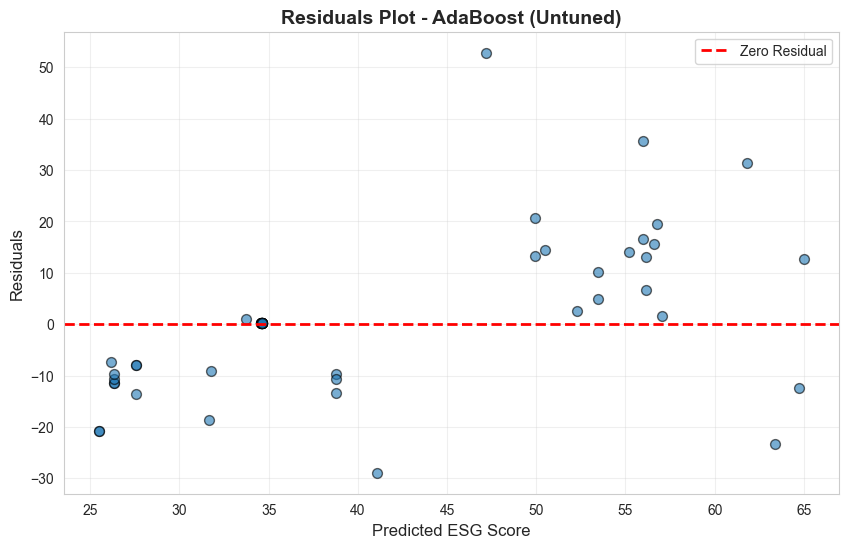


4. Residuals Distribution:


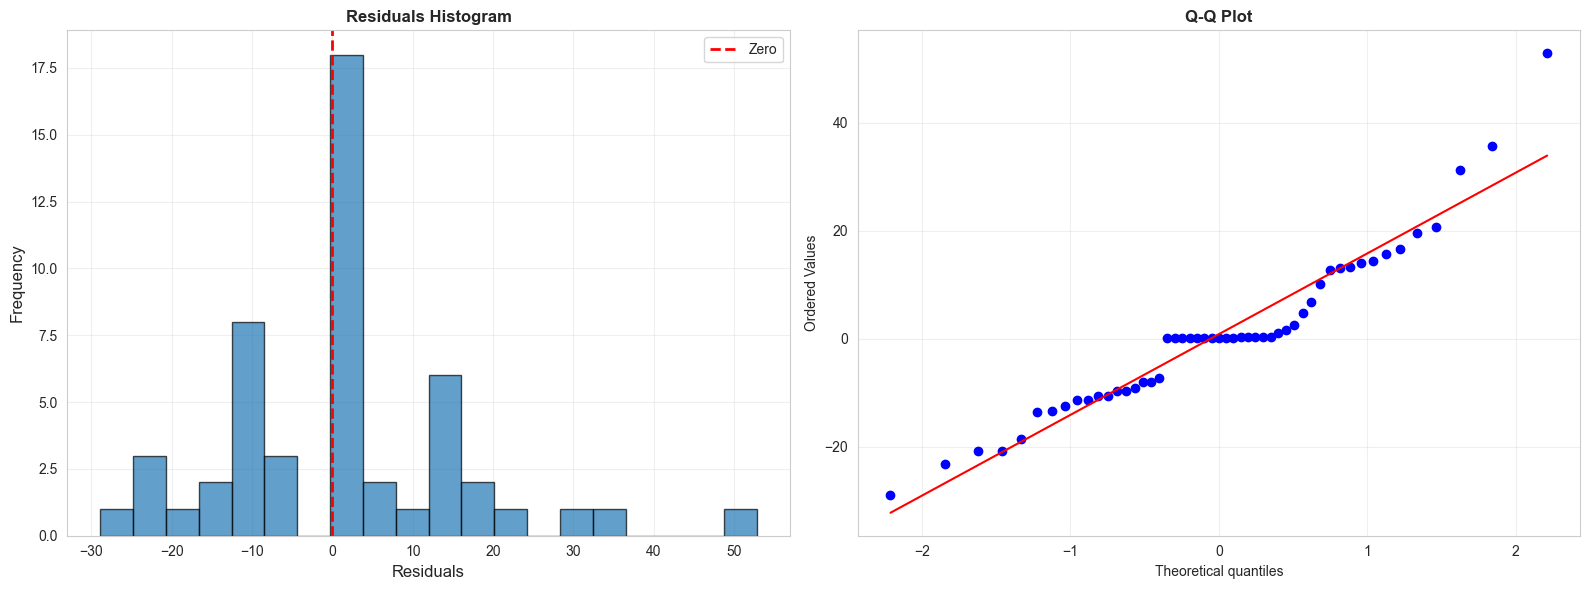


5. Error Metrics Summary:
   Mean Squared Error (MSE): 225.6881
   Root Mean Squared Error (RMSE): 15.0229
   Mean Absolute Error (MAE): 10.5256
   R² Score: 0.6059
   Mean Actual Value: 42.0092
   Mean Predicted Value: 41.1929
   Std of Residuals: 15.0007

6. Prediction Error Distribution:


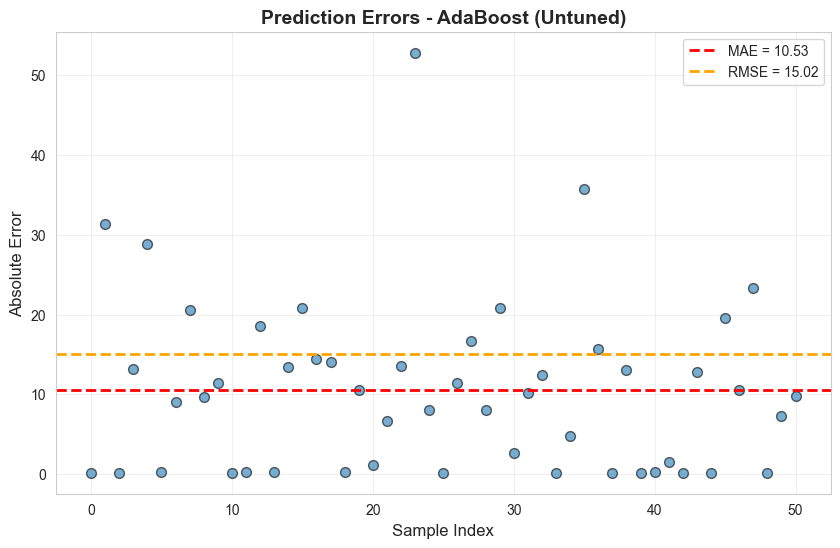

In [34]:
trainer.train_models(models=['ab'], task='regression', hyperparameter_tuning=False, show_viz=True)

Training Random Forest (Untuned) Regressor...
REGRESSION VISUALIZATIONS FOR: Random Forest (Untuned)

1. Model Performance Metrics:
   R² Score: 0.7111
   RMSE: 12.8624
   MAE: 7.1484

2. Actual vs Predicted Values:


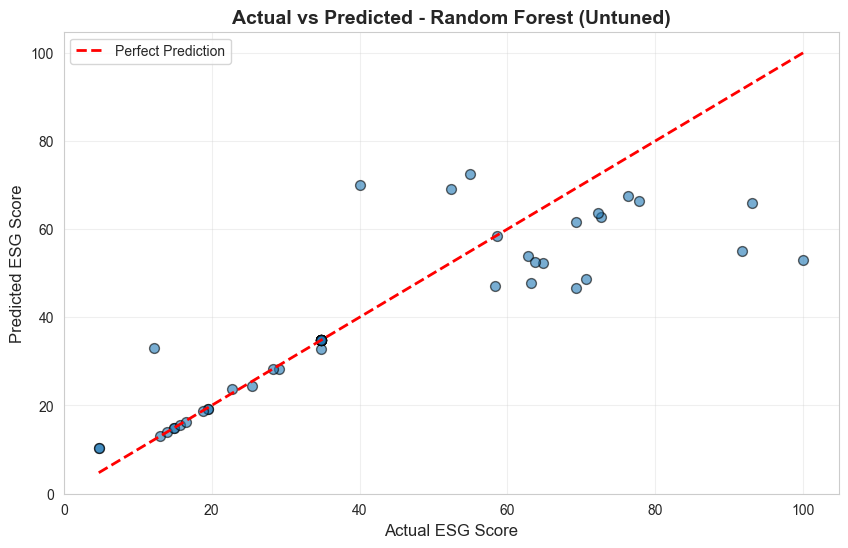


3. Residuals Plot:


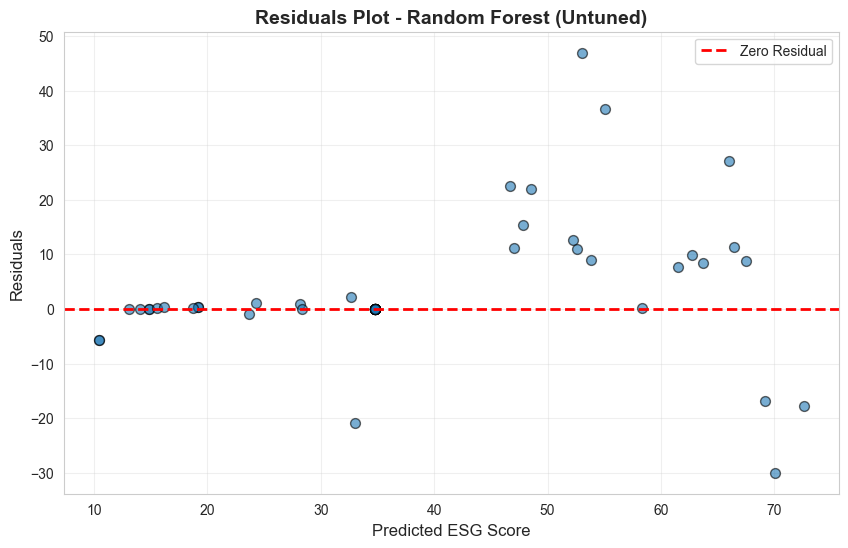


4. Residuals Distribution:


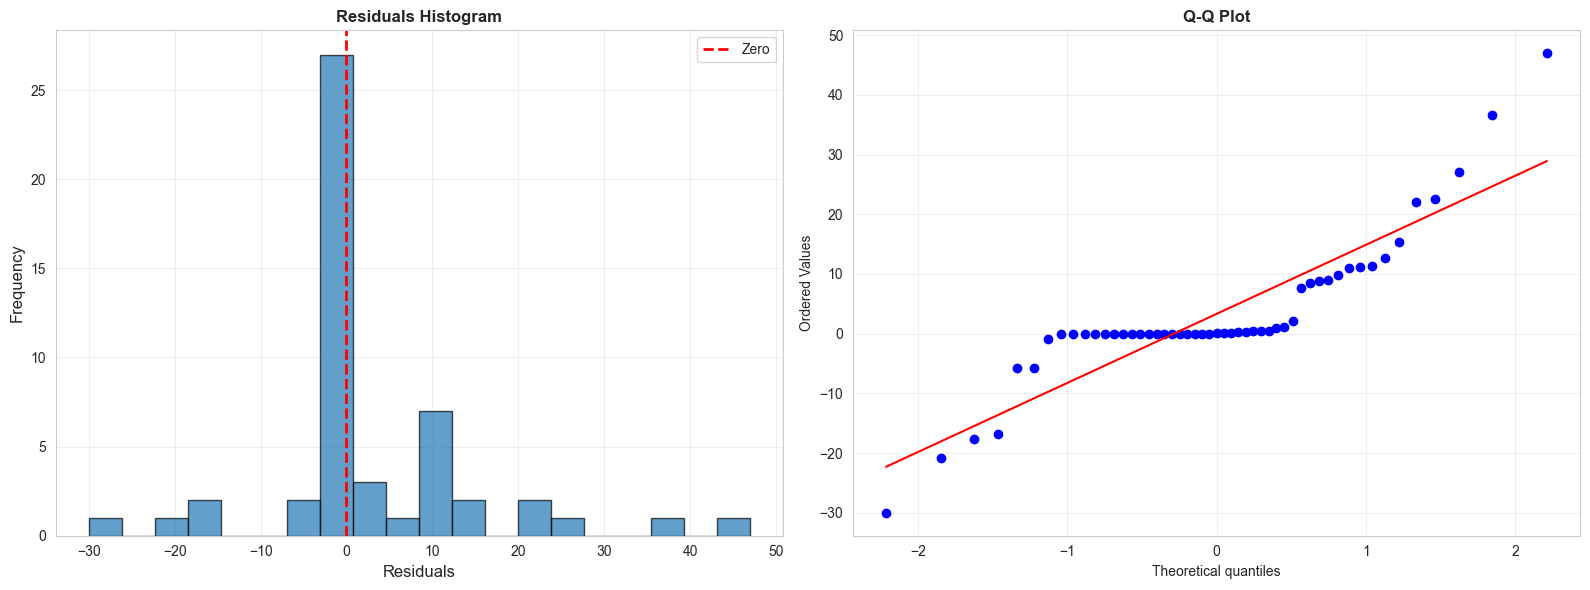


5. Error Metrics Summary:
   Mean Squared Error (MSE): 165.4424
   Root Mean Squared Error (RMSE): 12.8624
   Mean Absolute Error (MAE): 7.1484
   R² Score: 0.7111
   Mean Actual Value: 42.0092
   Mean Predicted Value: 38.6999
   Std of Residuals: 12.4294

6. Prediction Error Distribution:


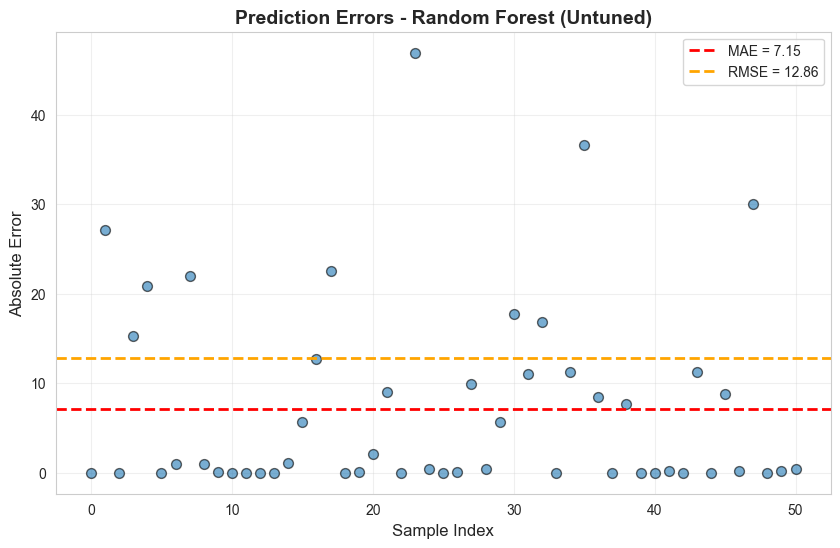

In [35]:
trainer.train_models(models=['rf'], task='regression', hyperparameter_tuning=False, show_viz=True)

Training XGBoost (Untuned) Regressor...
REGRESSION VISUALIZATIONS FOR: XGBoost (Untuned)

1. Model Performance Metrics:
   R² Score: 0.6429
   RMSE: 14.3012
   MAE: 7.4126

2. Actual vs Predicted Values:


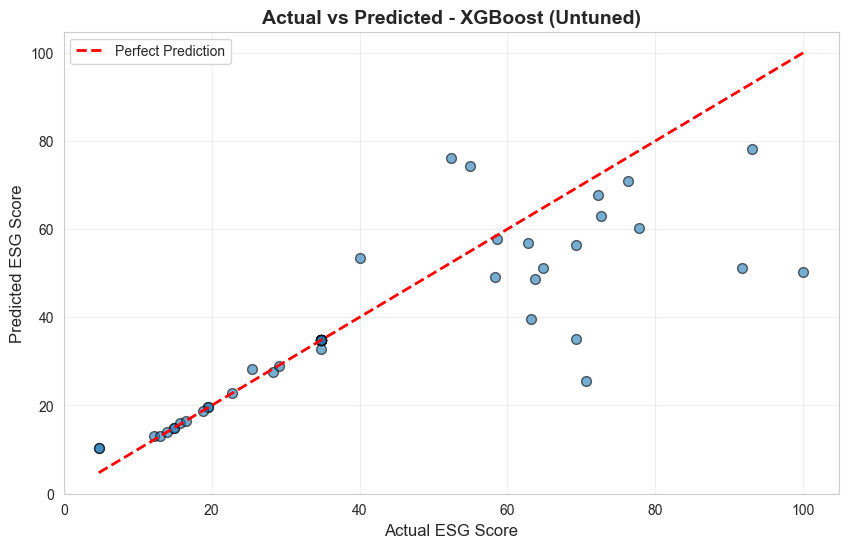


3. Residuals Plot:


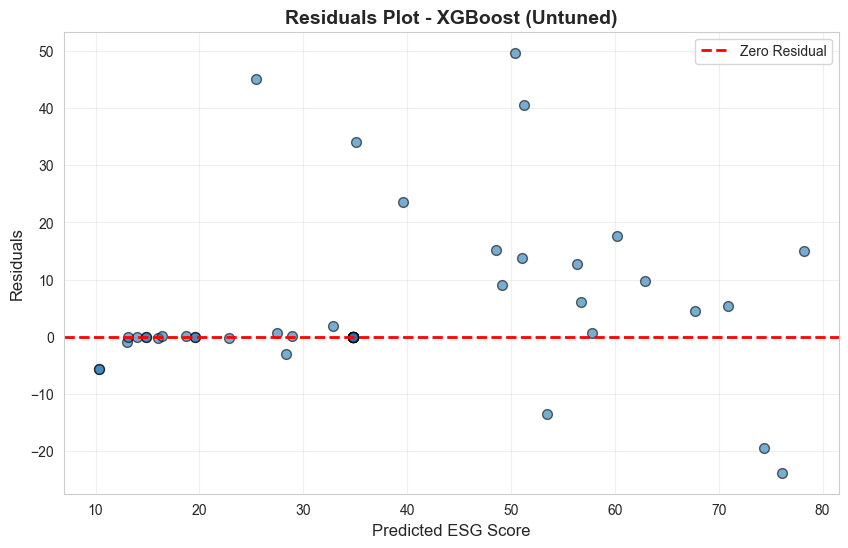


4. Residuals Distribution:


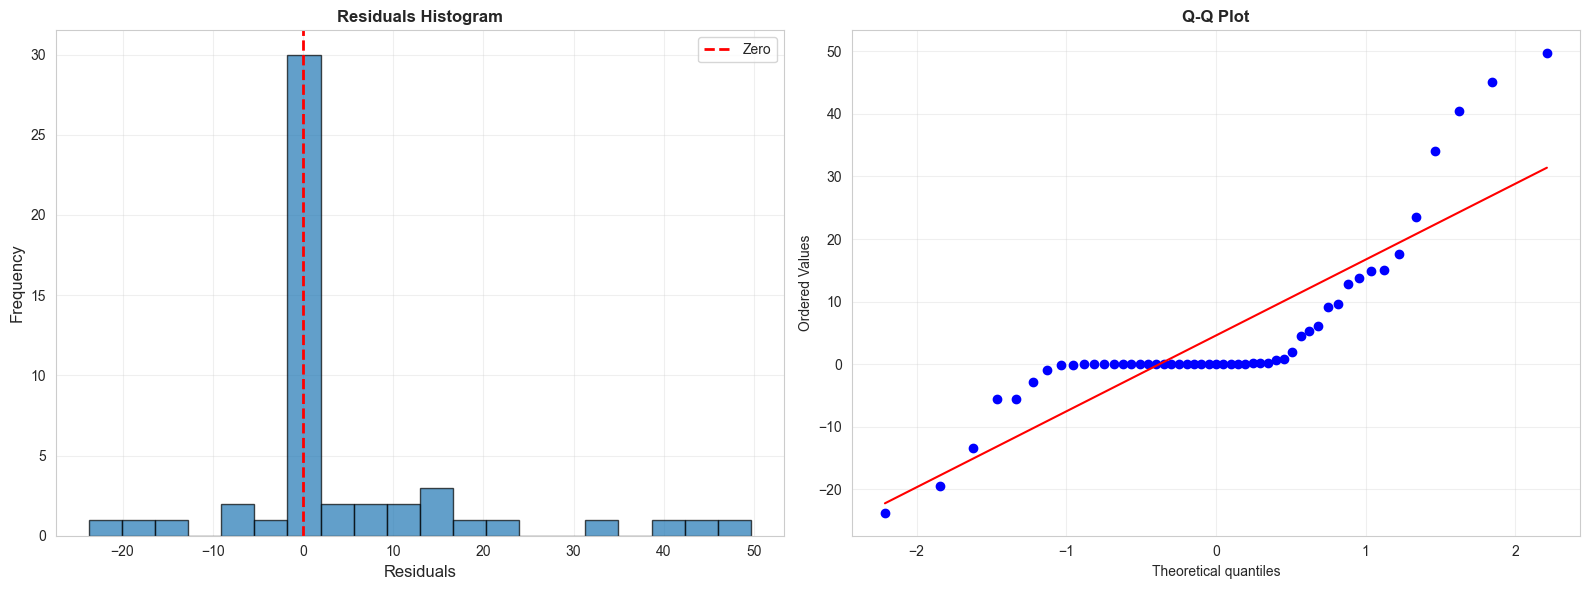


5. Error Metrics Summary:
   Mean Squared Error (MSE): 204.5256
   Root Mean Squared Error (RMSE): 14.3012
   Mean Absolute Error (MAE): 7.4126
   R² Score: 0.6429
   Mean Actual Value: 42.0092
   Mean Predicted Value: 37.4224
   Std of Residuals: 13.5457

6. Prediction Error Distribution:


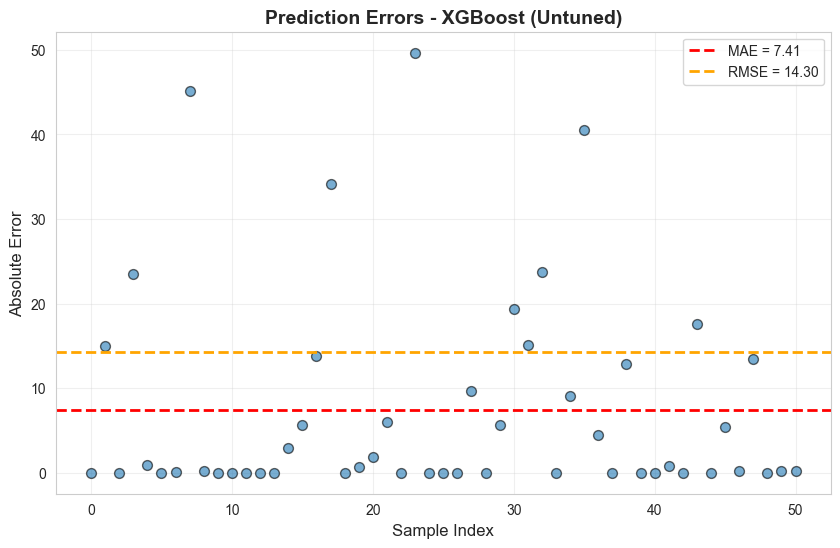

In [36]:
trainer.train_models(models=['xgb'], task='regression', hyperparameter_tuning=False, show_viz=True)

Training SVM (Untuned) Regressor...
REGRESSION VISUALIZATIONS FOR: SVM (Untuned)

1. Model Performance Metrics:
   R² Score: 0.1297
   RMSE: 22.3262
   MAE: 16.6253

2. Actual vs Predicted Values:


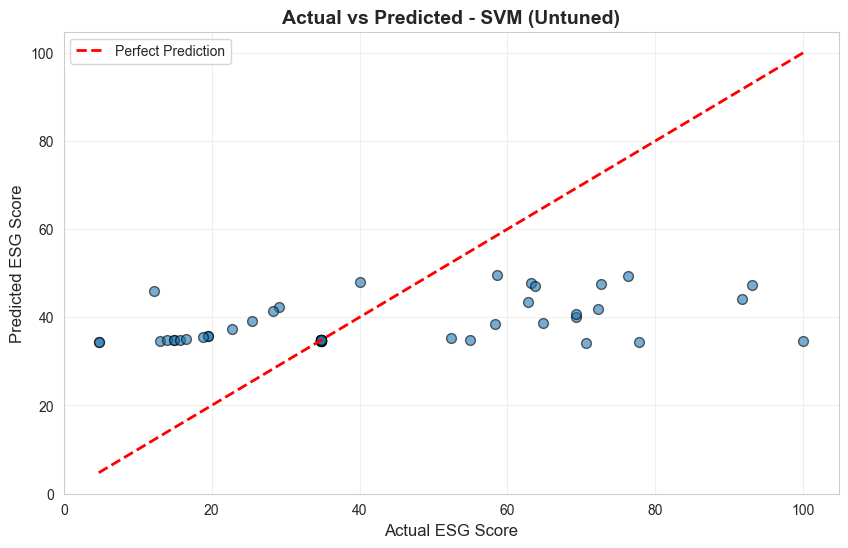


3. Residuals Plot:


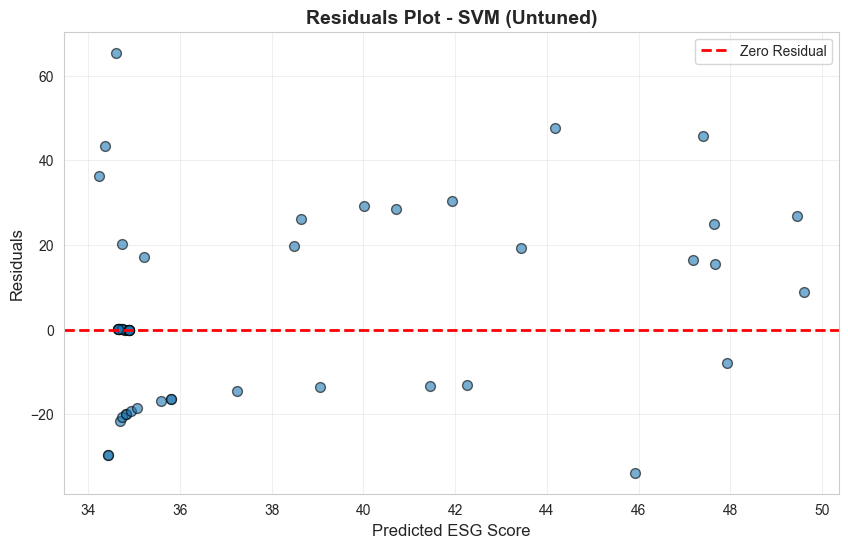


4. Residuals Distribution:


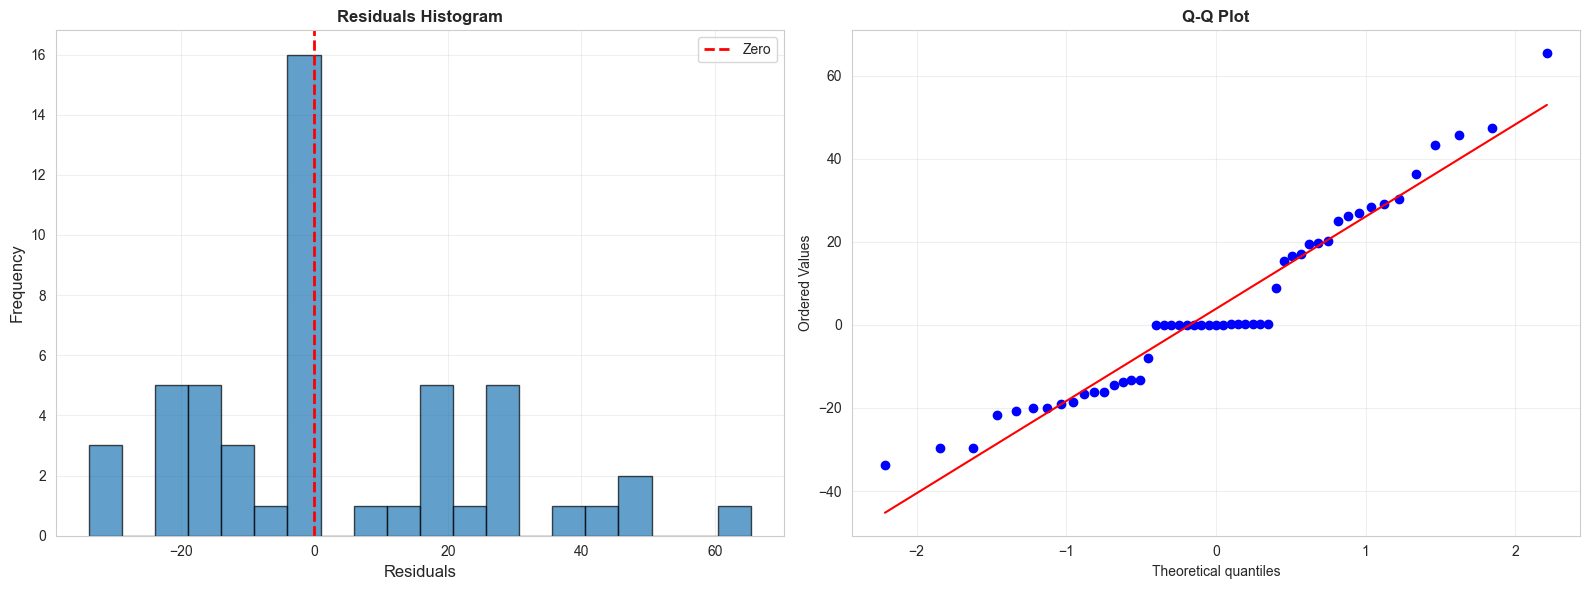


5. Error Metrics Summary:
   Mean Squared Error (MSE): 498.4602
   Root Mean Squared Error (RMSE): 22.3262
   Mean Absolute Error (MAE): 16.6253
   R² Score: 0.1297
   Mean Actual Value: 42.0092
   Mean Predicted Value: 38.1336
   Std of Residuals: 21.9873

6. Prediction Error Distribution:


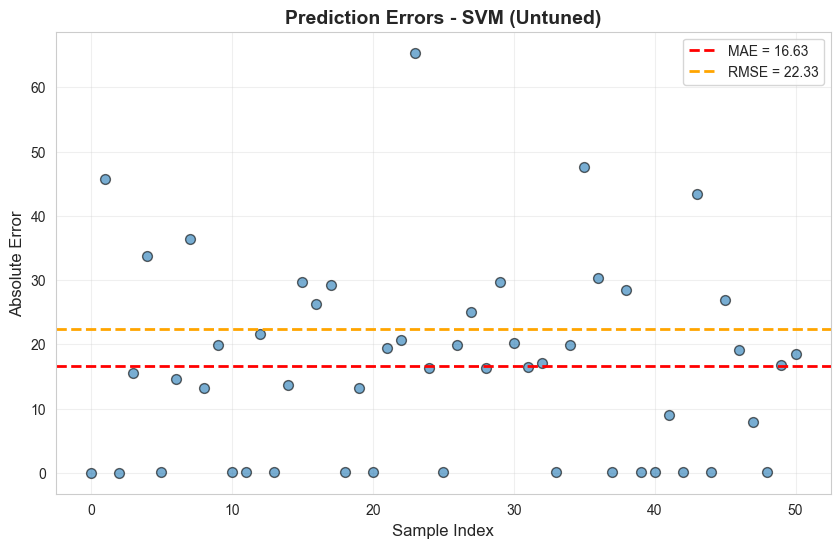

In [37]:
trainer.train_models(models=['svm'], task='regression', hyperparameter_tuning=False, show_viz=True)

### Regression - Tuned Models

Training Decision Tree (Tuned) Regressor...
---> Hyperparameter tuning...
Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
REGRESSION VISUALIZATIONS FOR: Decision Tree (Tuned)

1. Model Performance Metrics:
   R² Score: 0.7460
   RMSE: 12.0611
   MAE: 6.7837

2. Actual vs Predicted Values:


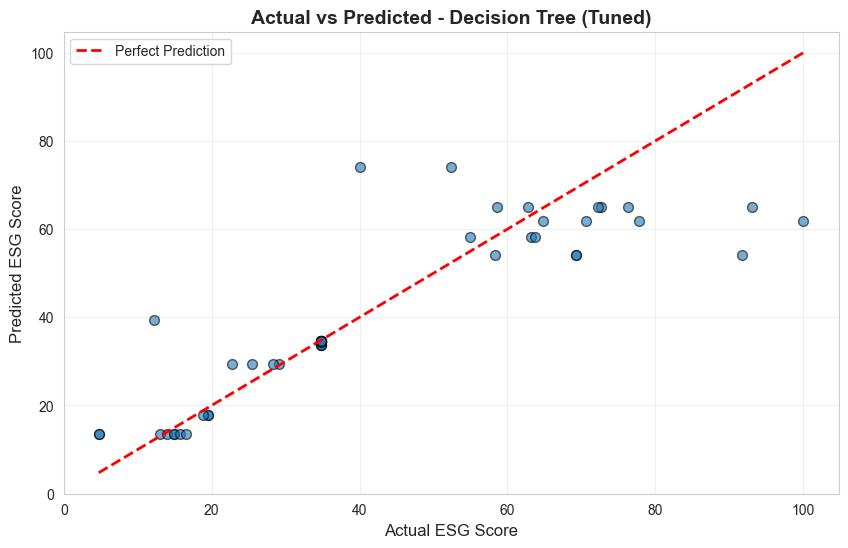


3. Residuals Plot:


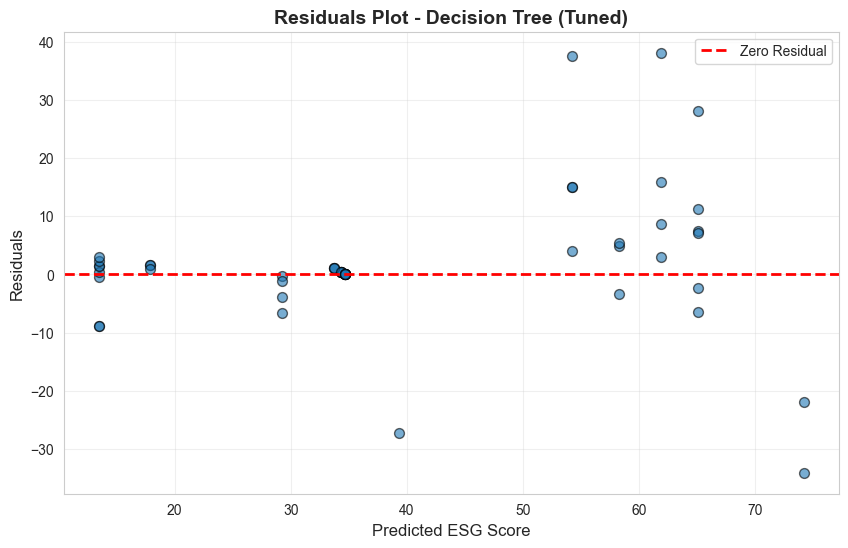


4. Residuals Distribution:


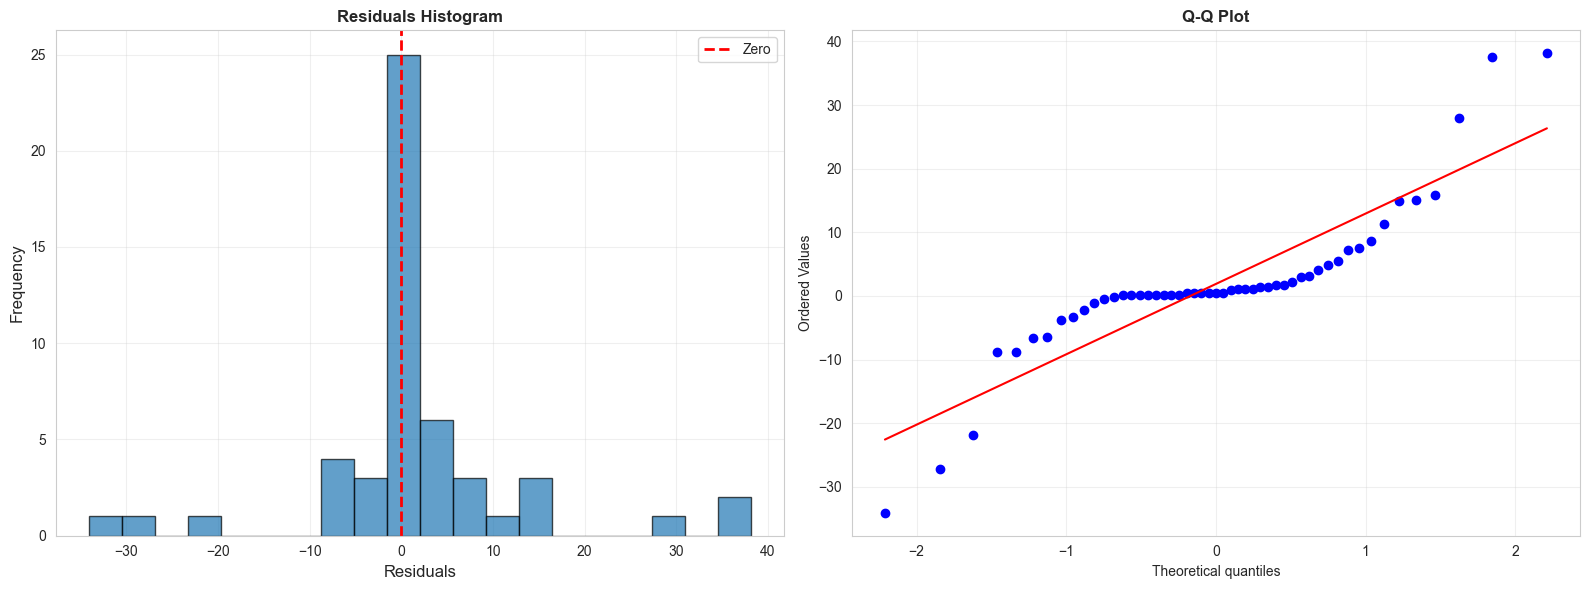


5. Error Metrics Summary:
   Mean Squared Error (MSE): 145.4711
   Root Mean Squared Error (RMSE): 12.0611
   Mean Absolute Error (MAE): 6.7837
   R² Score: 0.7460
   Mean Actual Value: 42.0092
   Mean Predicted Value: 40.1257
   Std of Residuals: 11.9132

6. Prediction Error Distribution:


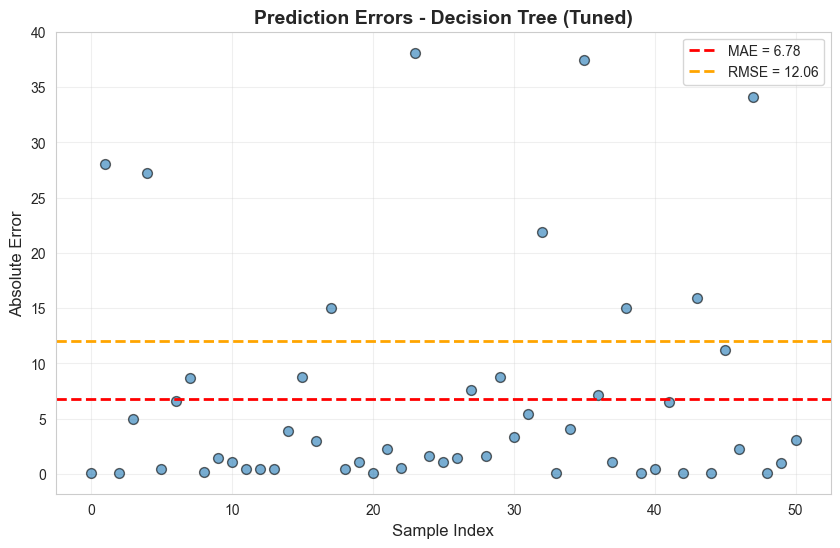

In [38]:
trainer.train_models(models=['dt'], task='regression', hyperparameter_tuning=True, show_viz=True)

Training AdaBoost (Tuned) Regressor...
---> Hyperparameter tuning...
Fitting 3 folds for each of 135 candidates, totalling 405 fits
REGRESSION VISUALIZATIONS FOR: AdaBoost (Tuned)

1. Model Performance Metrics:
   R² Score: 0.7550
   RMSE: 11.8457
   MAE: 7.3079

2. Actual vs Predicted Values:


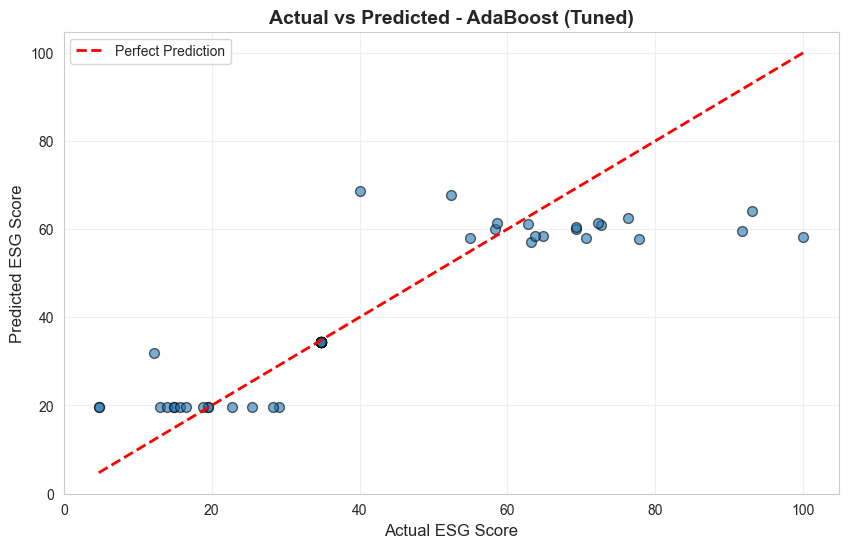


3. Residuals Plot:


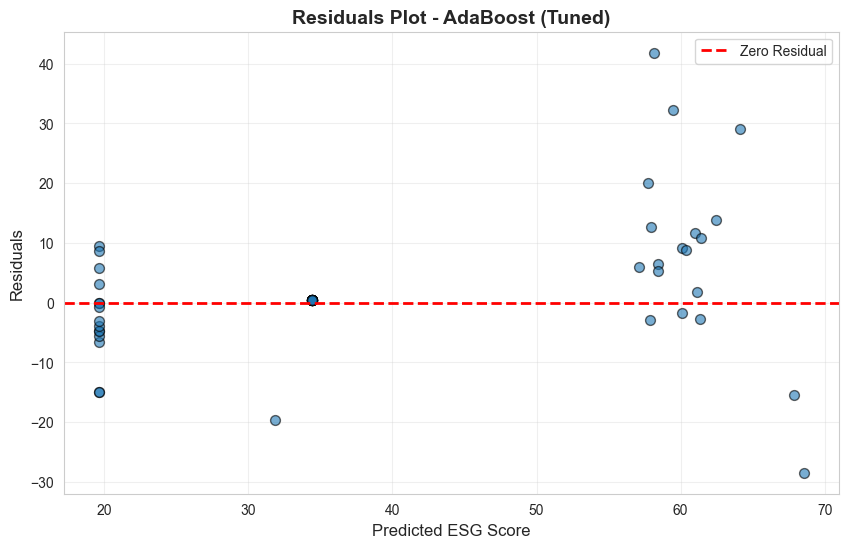


4. Residuals Distribution:


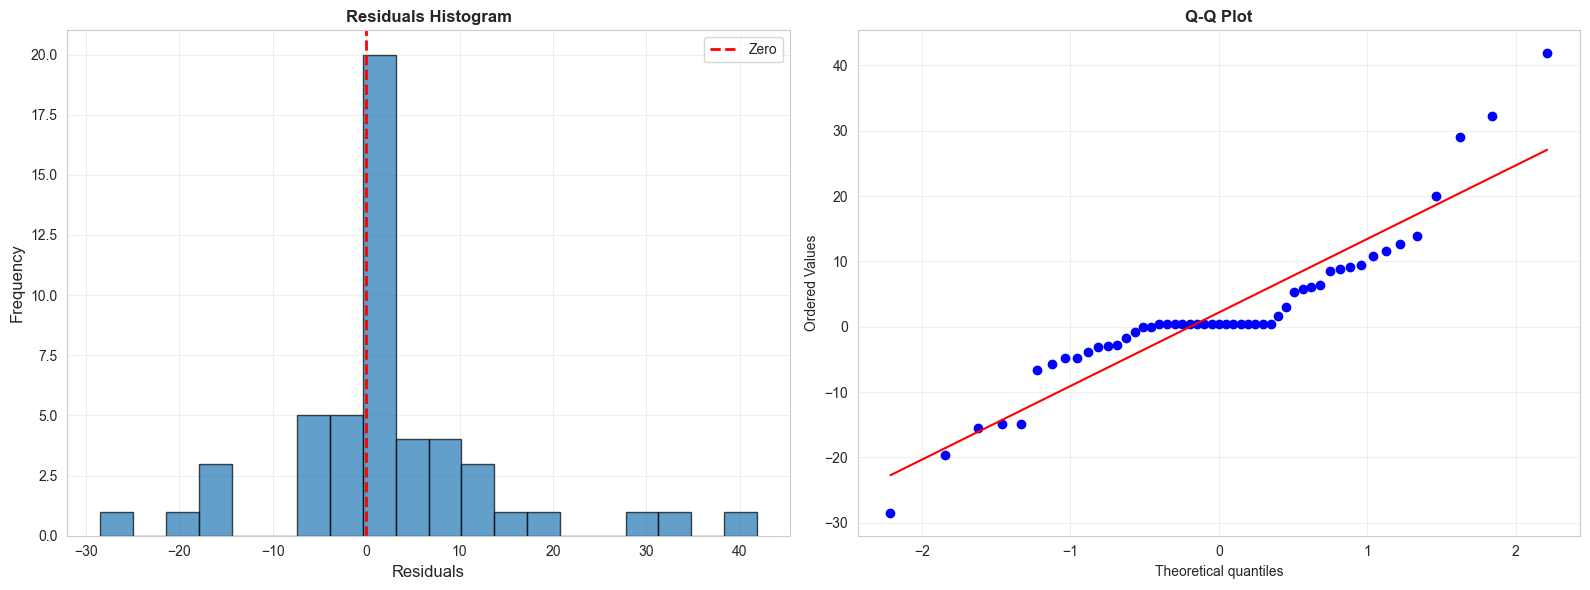


5. Error Metrics Summary:
   Mean Squared Error (MSE): 140.3204
   Root Mean Squared Error (RMSE): 11.8457
   Mean Absolute Error (MAE): 7.3079
   R² Score: 0.7550
   Mean Actual Value: 42.0092
   Mean Predicted Value: 39.8219
   Std of Residuals: 11.6420

6. Prediction Error Distribution:


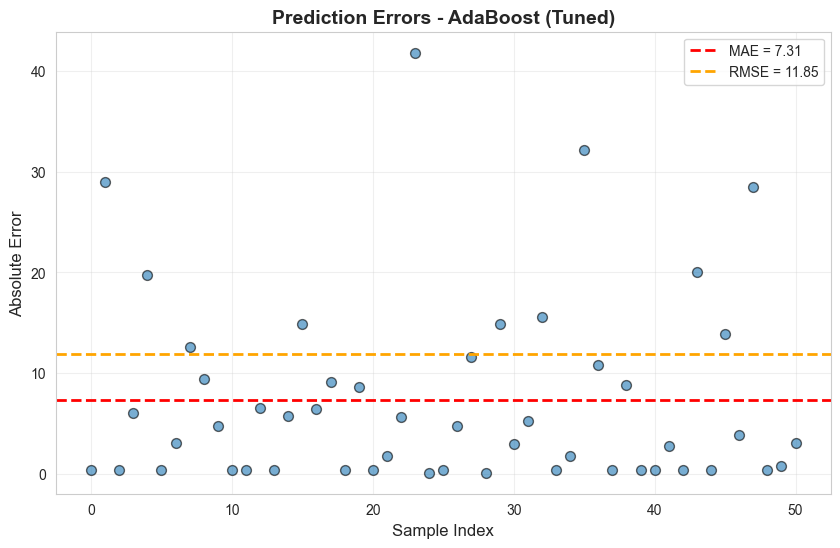

In [39]:
trainer.train_models(models=['ab'], task='regression', hyperparameter_tuning=True, show_viz=True)

Training Random Forest (Tuned) Regressor...
---> Hyperparameter tuning...
Fitting 3 folds for each of 12096 candidates, totalling 36288 fits
REGRESSION VISUALIZATIONS FOR: Random Forest (Tuned)

1. Model Performance Metrics:
   R² Score: 0.7317
   RMSE: 12.3955
   MAE: 7.0183

2. Actual vs Predicted Values:


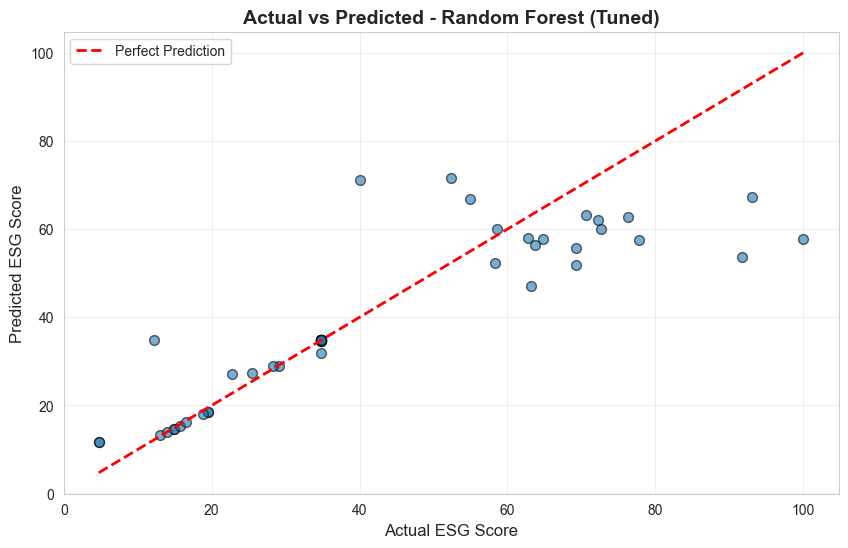


3. Residuals Plot:


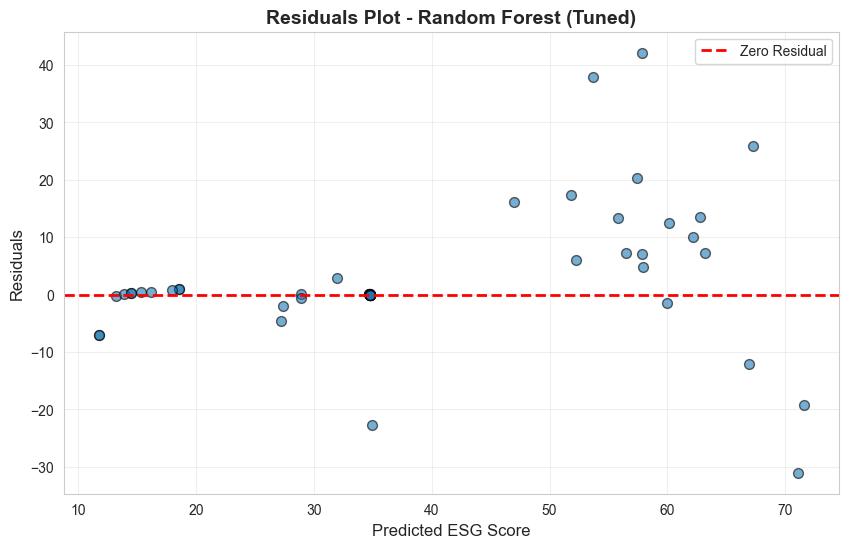


4. Residuals Distribution:


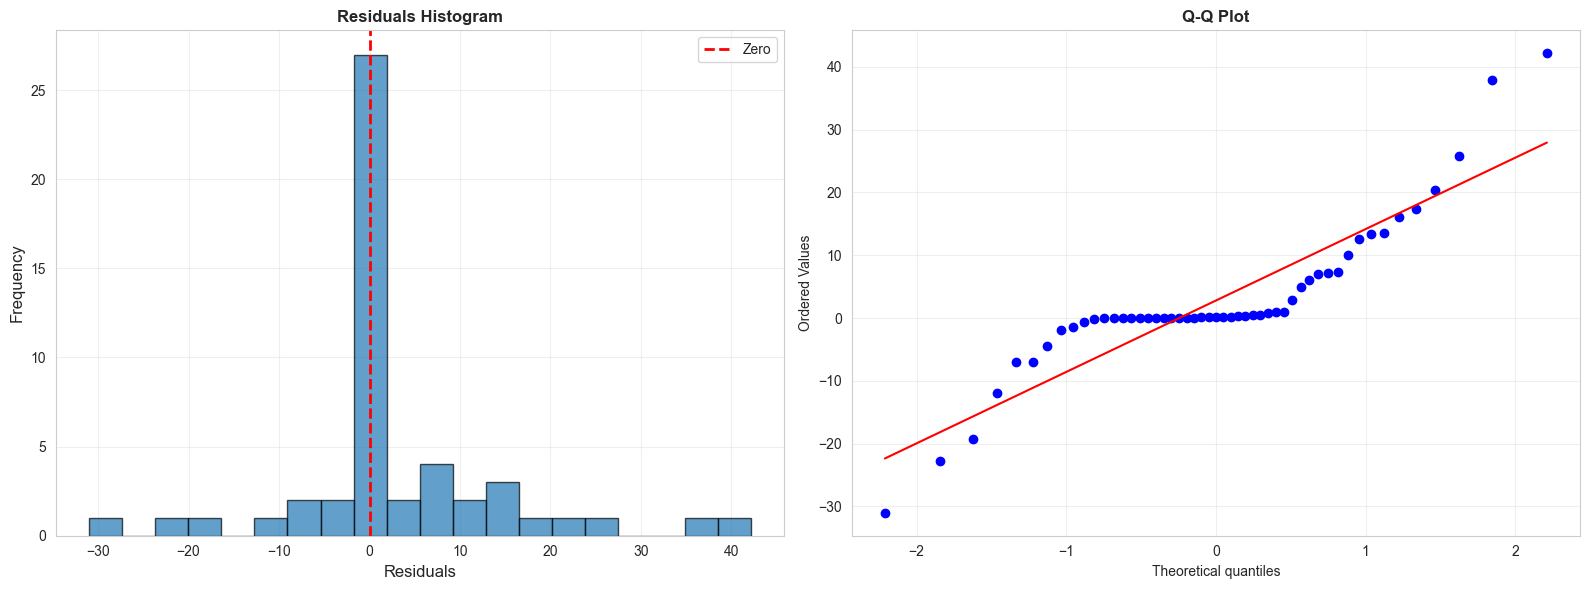


5. Error Metrics Summary:
   Mean Squared Error (MSE): 153.6476
   Root Mean Squared Error (RMSE): 12.3955
   Mean Absolute Error (MAE): 7.0183
   R² Score: 0.7317
   Mean Actual Value: 42.0092
   Mean Predicted Value: 39.2212
   Std of Residuals: 12.0779

6. Prediction Error Distribution:


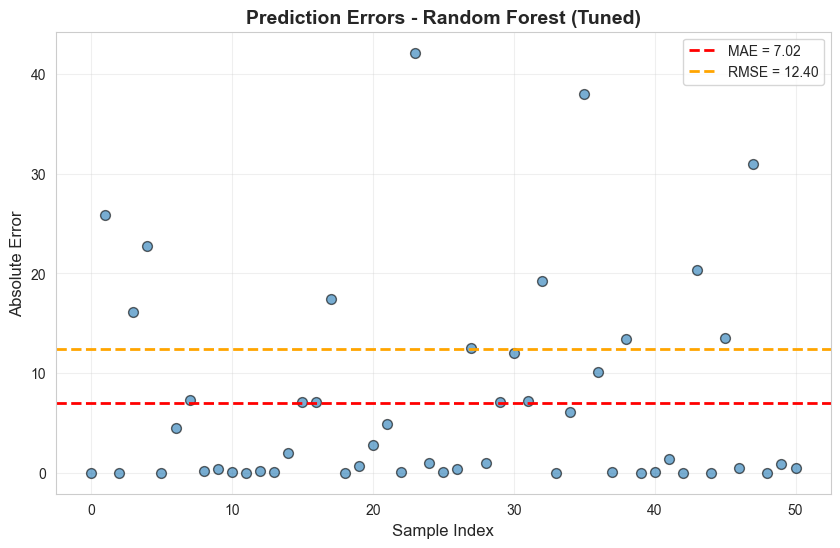

In [40]:
trainer.train_models(models=['rf'], task='regression', hyperparameter_tuning=True, show_viz=True)

Training XGBoost (Tuned) Regressor...
---> Hyperparameter tuning...
Fitting 3 folds for each of 540 candidates, totalling 1620 fits
REGRESSION VISUALIZATIONS FOR: XGBoost (Tuned)

1. Model Performance Metrics:
   R² Score: 0.7050
   RMSE: 12.9992
   MAE: 8.0360

2. Actual vs Predicted Values:


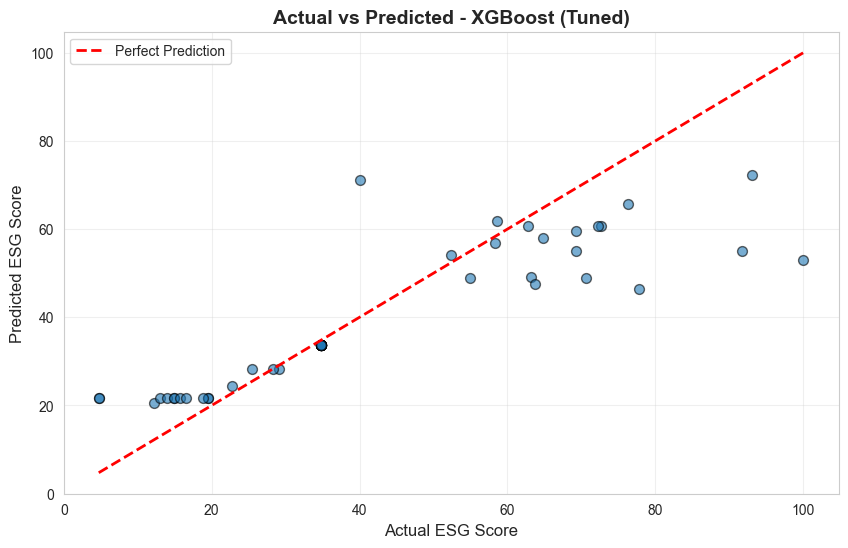


3. Residuals Plot:


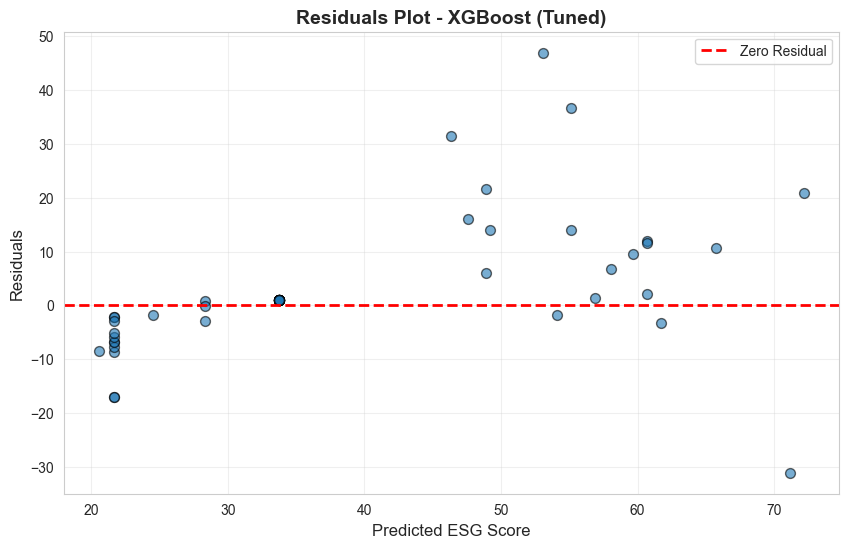


4. Residuals Distribution:


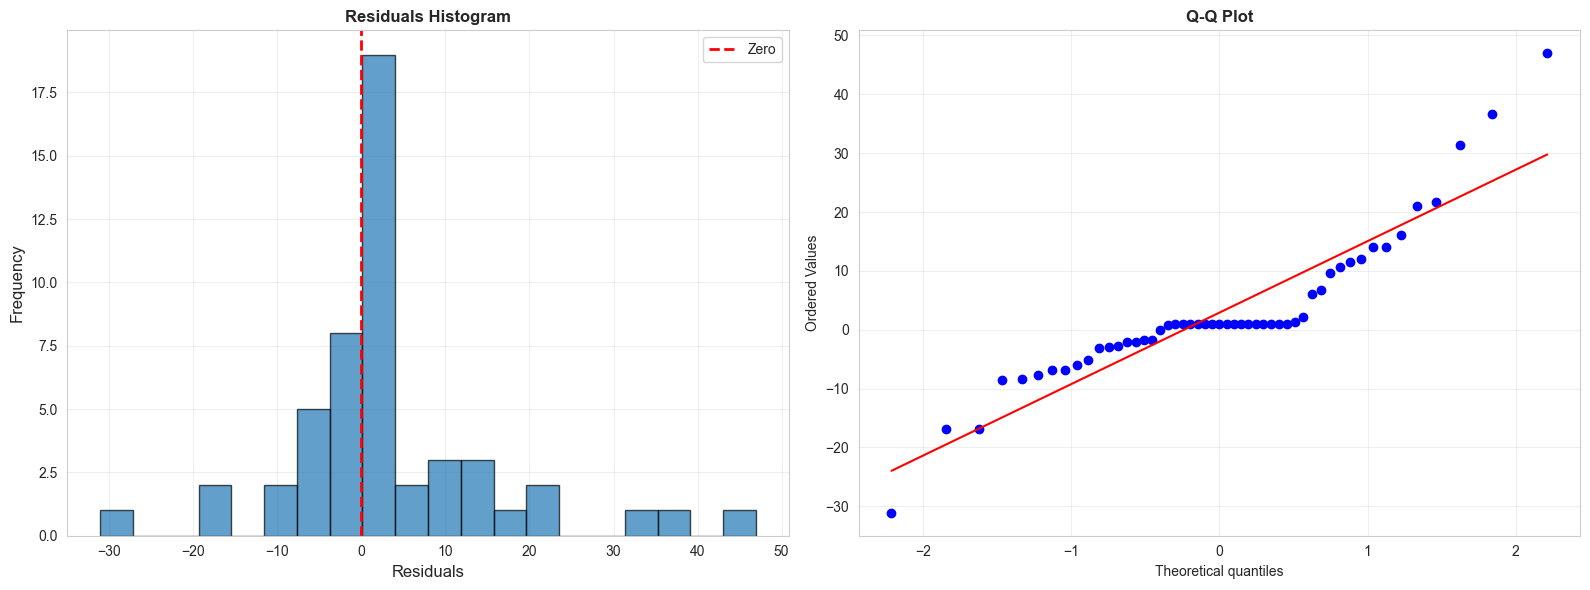


5. Error Metrics Summary:
   Mean Squared Error (MSE): 168.9796
   Root Mean Squared Error (RMSE): 12.9992
   Mean Absolute Error (MAE): 8.0360
   R² Score: 0.7050
   Mean Actual Value: 42.0092
   Mean Predicted Value: 39.1093
   Std of Residuals: 12.6716

6. Prediction Error Distribution:


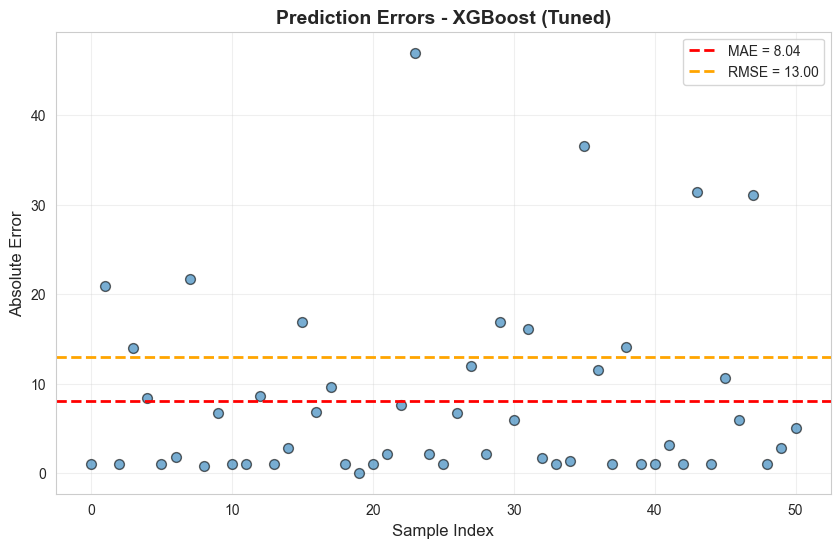

In [41]:
trainer.train_models(models=['xgb'], task='regression', hyperparameter_tuning=True, show_viz=True)

Training SVM (Tuned) Regressor...
---> Hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
REGRESSION VISUALIZATIONS FOR: SVM (Tuned)

1. Model Performance Metrics:
   R² Score: 0.2399
   RMSE: 20.8651
   MAE: 14.8728

2. Actual vs Predicted Values:


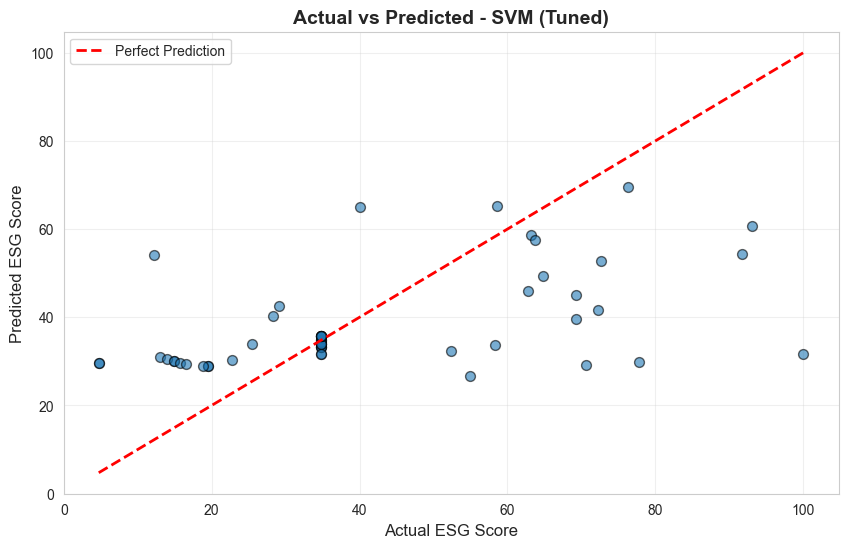


3. Residuals Plot:


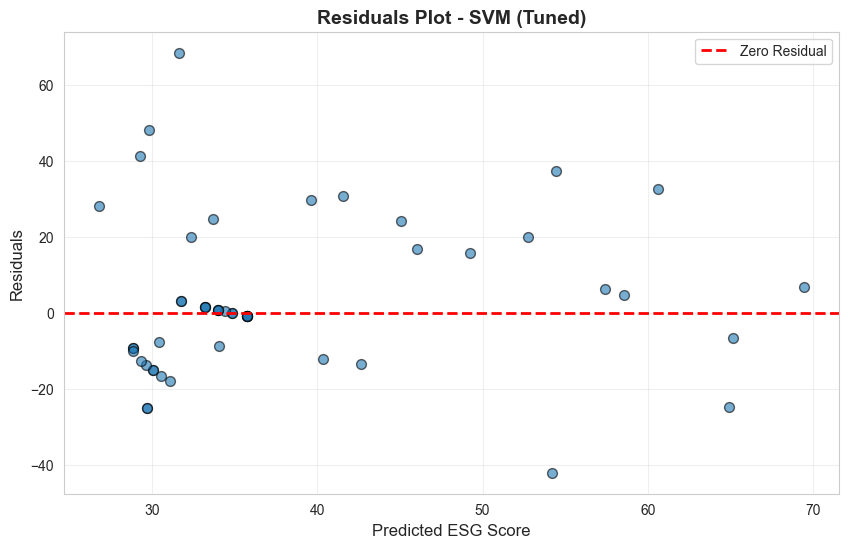


4. Residuals Distribution:


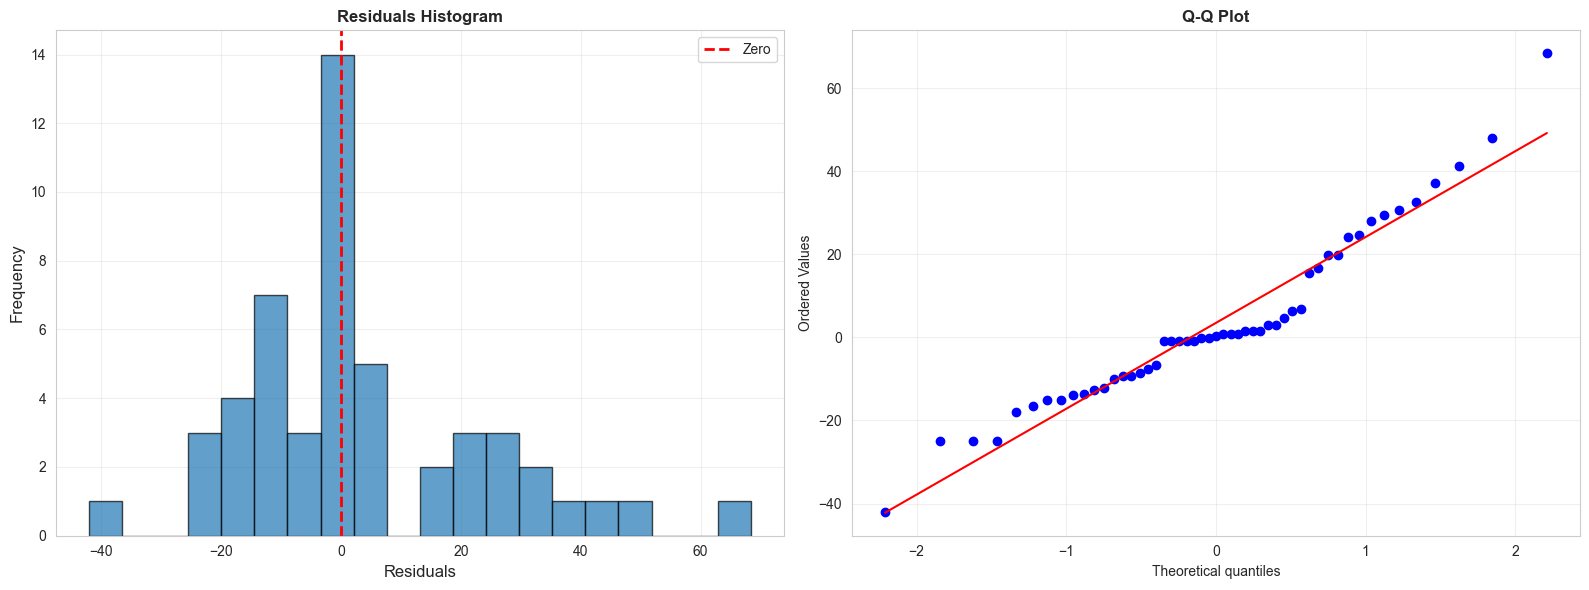


5. Error Metrics Summary:
   Mean Squared Error (MSE): 435.3526
   Root Mean Squared Error (RMSE): 20.8651
   Mean Absolute Error (MAE): 14.8728
   R² Score: 0.2399
   Mean Actual Value: 42.0092
   Mean Predicted Value: 38.5140
   Std of Residuals: 20.5703

6. Prediction Error Distribution:


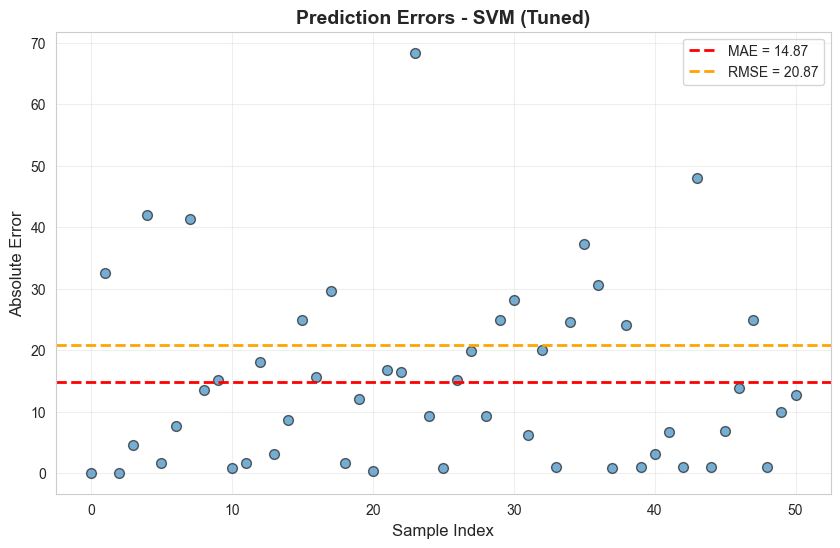

In [42]:
trainer.train_models(models=['svm'], task='regression', hyperparameter_tuning=True, show_viz=True)

In [43]:
trainer.print_model_comparison()

MODEL PERFORMANCE COMPARISON

REGRESSION MODELS (UNTUNED):
--------------------------------------------------------------------------------
Random Forest (Untuned)       : R²=0.7111, RMSE=12.8624, MAE=7.1484
XGBoost (Untuned)             : R²=0.6429, RMSE=14.3012, MAE=7.4126
AdaBoost (Untuned)            : R²=0.6059, RMSE=15.0229, MAE=10.5256
Decision Tree (Untuned)       : R²=0.5813, RMSE=15.4847, MAE=8.3347
SVM (Untuned)                 : R²=0.1297, RMSE=22.3262, MAE=16.6253

REGRESSION MODELS (TUNED):
--------------------------------------------------------------------------------
AdaBoost (Tuned)              : R²=0.7550, RMSE=11.8457, MAE=7.3079
  Best Hyperparameters: {'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 300, 'random_state': 42}
Decision Tree (Tuned)         : R²=0.7460, RMSE=12.0611, MAE=6.7837
  Best Hyperparameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Random Forest (Tuned)         : R²=0.7317, RMSE=1

In [44]:
trainer.df.drop(columns=['esg_score'], inplace=True)

### Classification - Untuned Models

REGRESSION VISUALIZATIONS FOR: Decision Tree (Untuned)

1. Model Performance Metrics:
   R² Score: 0.5813
   RMSE: 15.4847
   MAE: 8.3347

2. Actual vs Predicted Values:


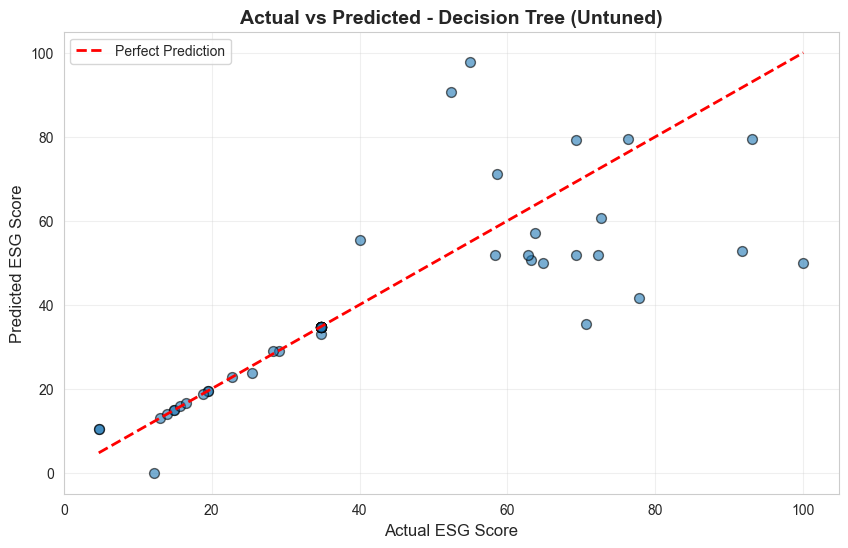


3. Residuals Plot:


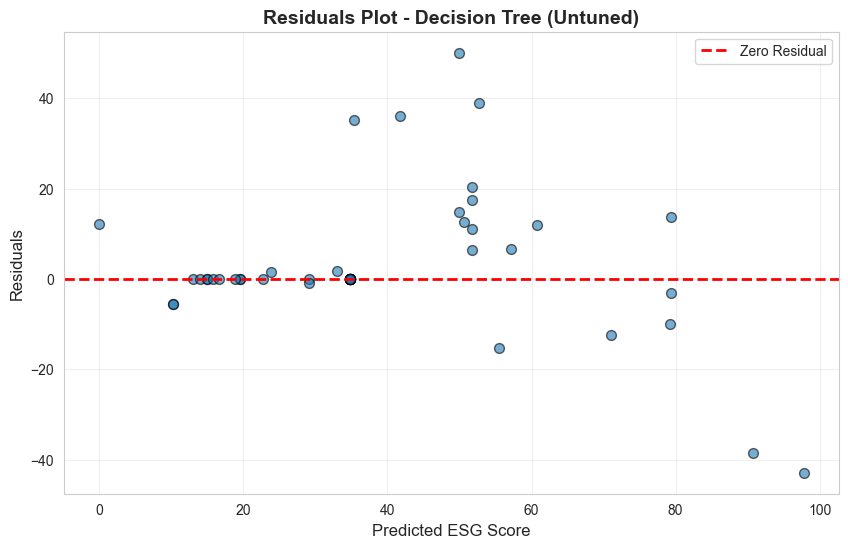


4. Residuals Distribution:


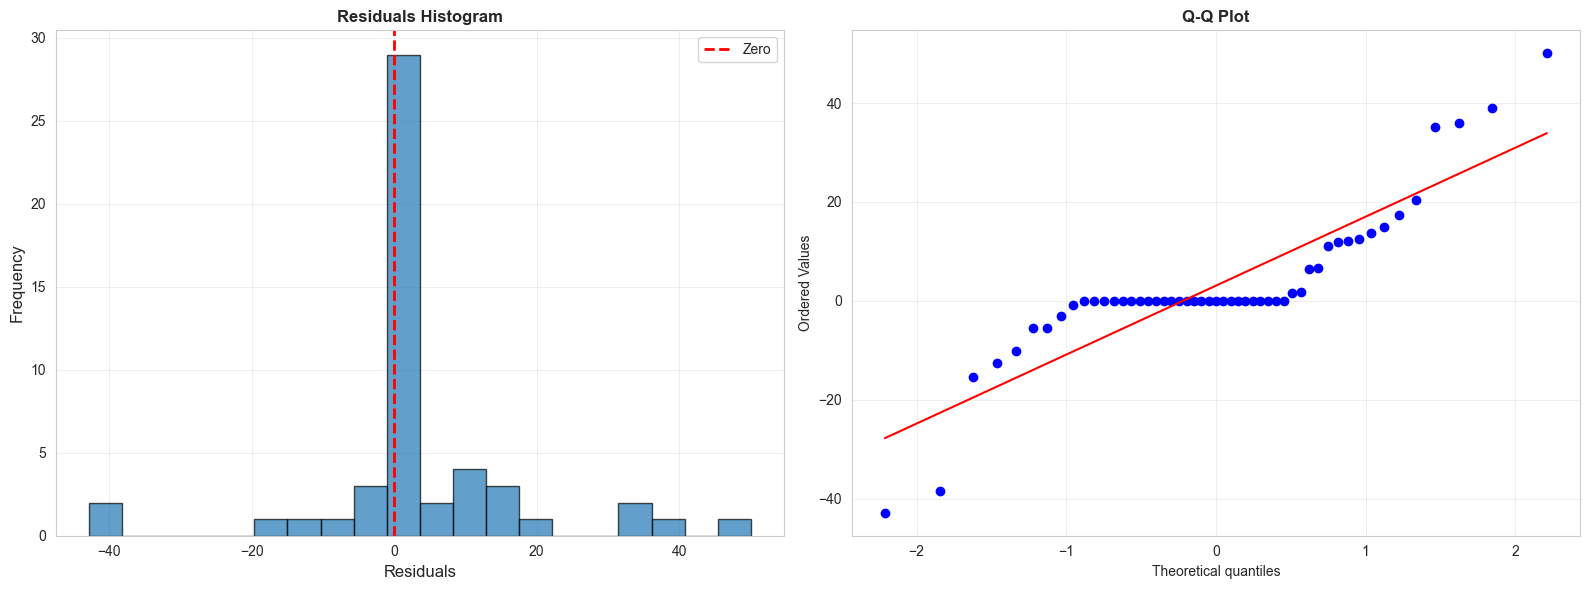


5. Error Metrics Summary:
   Mean Squared Error (MSE): 239.7768
   Root Mean Squared Error (RMSE): 15.4847
   Mean Absolute Error (MAE): 8.3347
   R² Score: 0.5813
   Mean Actual Value: 42.0092
   Mean Predicted Value: 38.9369
   Std of Residuals: 15.1769

6. Prediction Error Distribution:


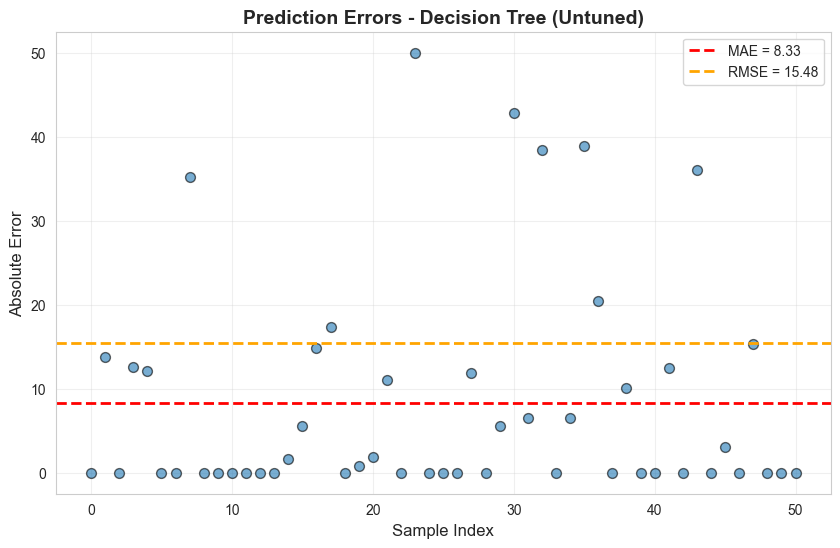


Training Decision Tree (Untuned) Classifier...
CLASSIFICATION VISUALIZATIONS FOR: Decision Tree (Untuned)

1. Confusion Matrix:


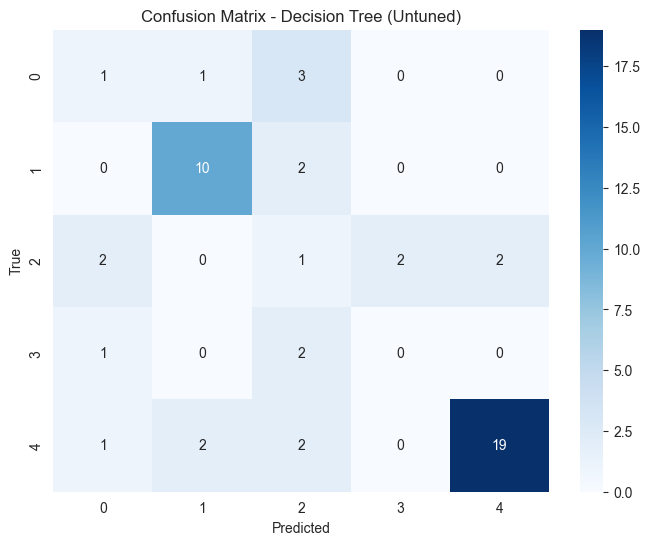


2. Precision and Recall Metrics:
Model: Decision Tree (Untuned)
Precision: 0.6401
Recall: 0.6078



In [45]:
trainer.train_models(models=['dt'], task='classification', hyperparameter_tuning=False, show_viz=True)

REGRESSION VISUALIZATIONS FOR: AdaBoost (Untuned)

1. Model Performance Metrics:
   R² Score: 0.6059
   RMSE: 15.0229
   MAE: 10.5256

2. Actual vs Predicted Values:


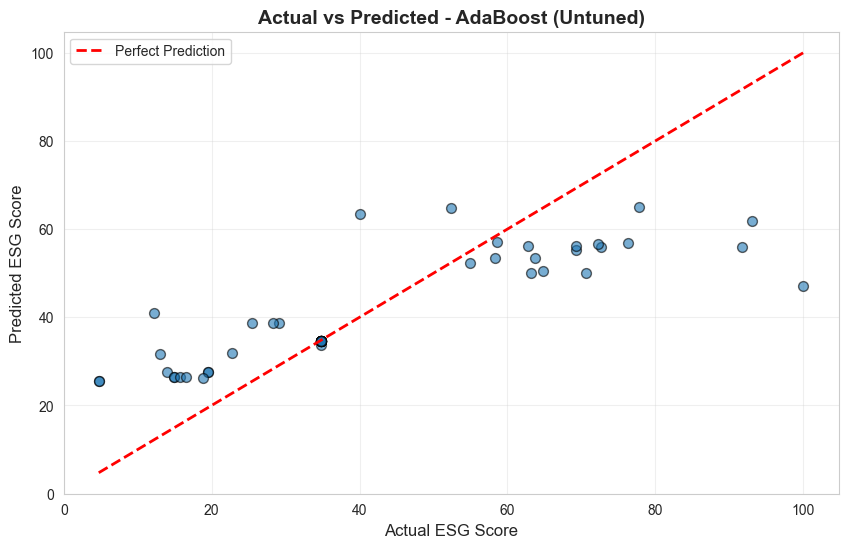


3. Residuals Plot:


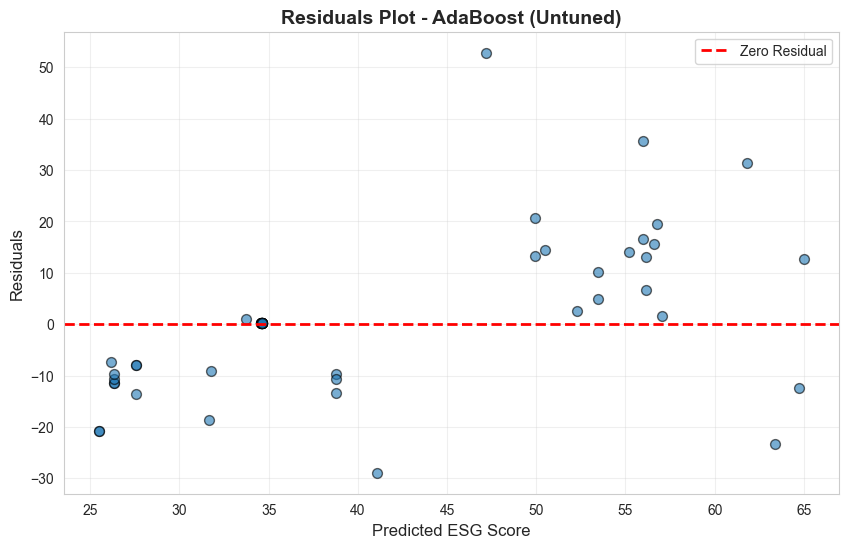


4. Residuals Distribution:


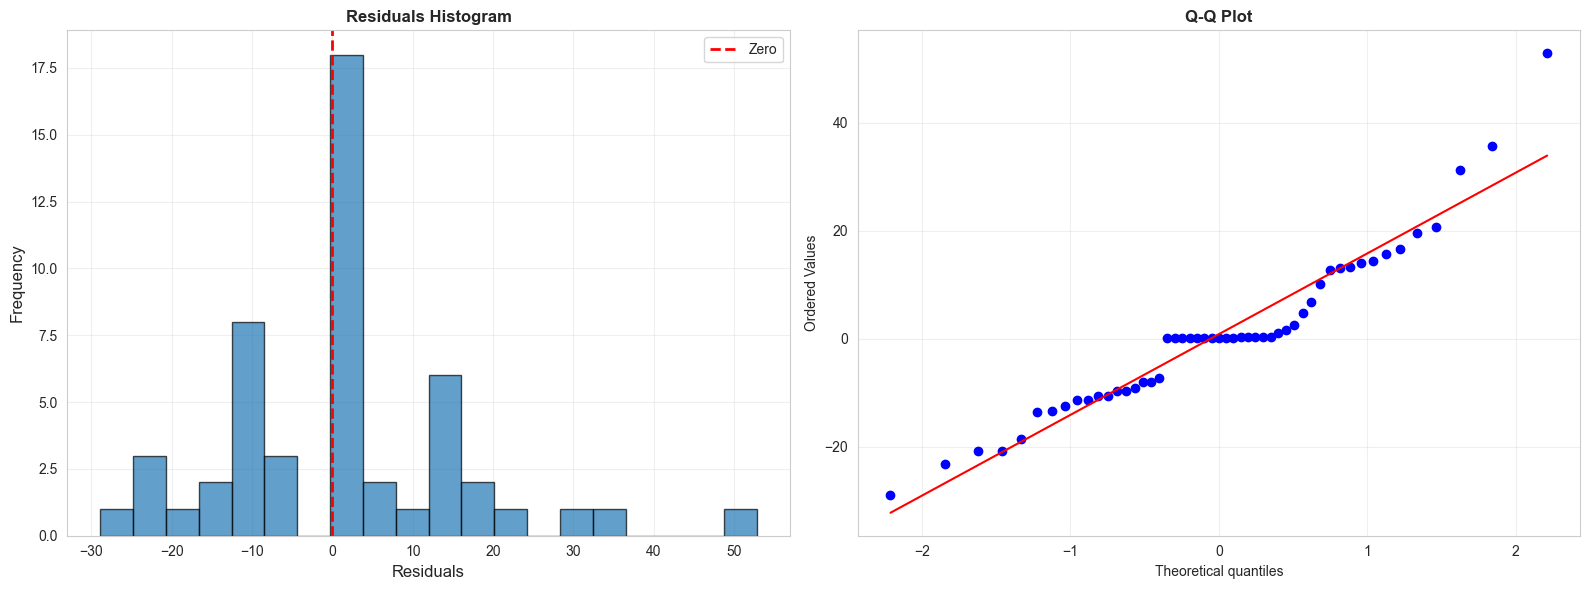


5. Error Metrics Summary:
   Mean Squared Error (MSE): 225.6881
   Root Mean Squared Error (RMSE): 15.0229
   Mean Absolute Error (MAE): 10.5256
   R² Score: 0.6059
   Mean Actual Value: 42.0092
   Mean Predicted Value: 41.1929
   Std of Residuals: 15.0007

6. Prediction Error Distribution:


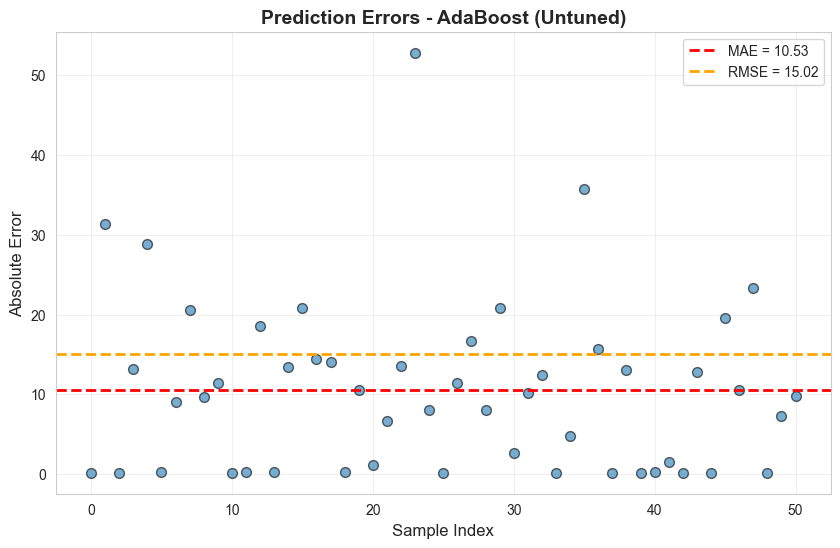


Training AdaBoost (Untuned) Classifier...
CLASSIFICATION VISUALIZATIONS FOR: AdaBoost (Untuned)

1. Confusion Matrix:


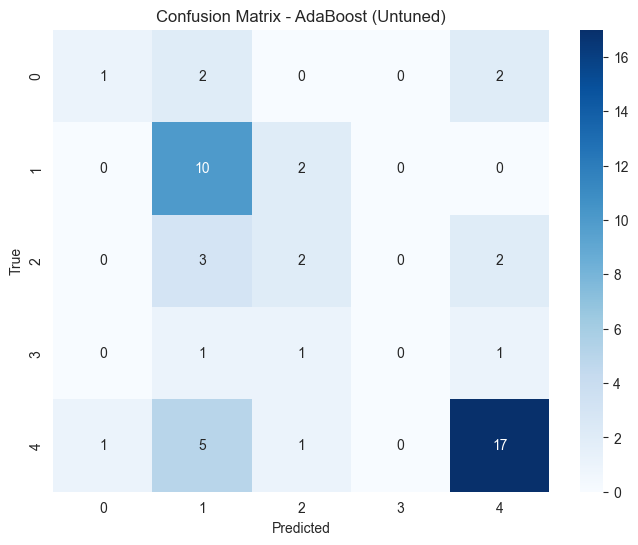


2. Precision and Recall Metrics:
Model: AdaBoost (Untuned)
Precision: 0.5705
Recall: 0.5882



In [46]:
trainer.train_models(models=['ab'], task='classification', hyperparameter_tuning=False, show_viz=True)

Training Random Forest (Untuned) Classifier...
CLASSIFICATION VISUALIZATIONS FOR: Random Forest (Untuned)

1. Confusion Matrix:


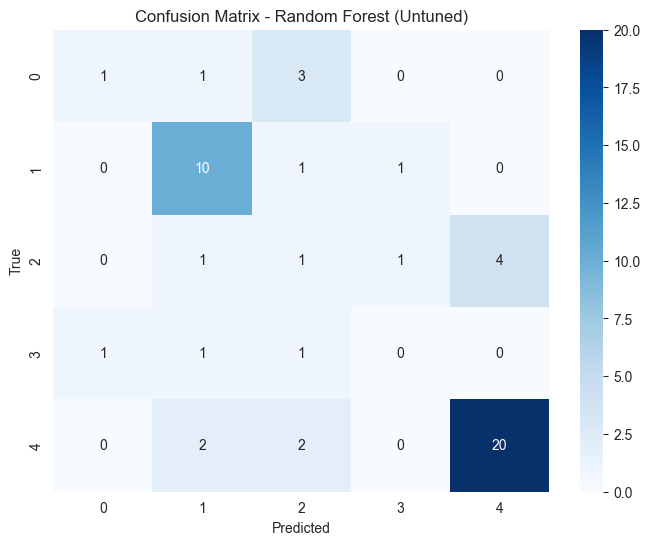


2. Precision and Recall Metrics:
Model: Random Forest (Untuned)
Precision: 0.6152
Recall: 0.6275



In [47]:
trainer.train_models(models=['rf'], task='classification', hyperparameter_tuning=False, show_viz=True)

Training XGBoost (Untuned) Classifier...
CLASSIFICATION VISUALIZATIONS FOR: XGBoost (Untuned)

1. Confusion Matrix:


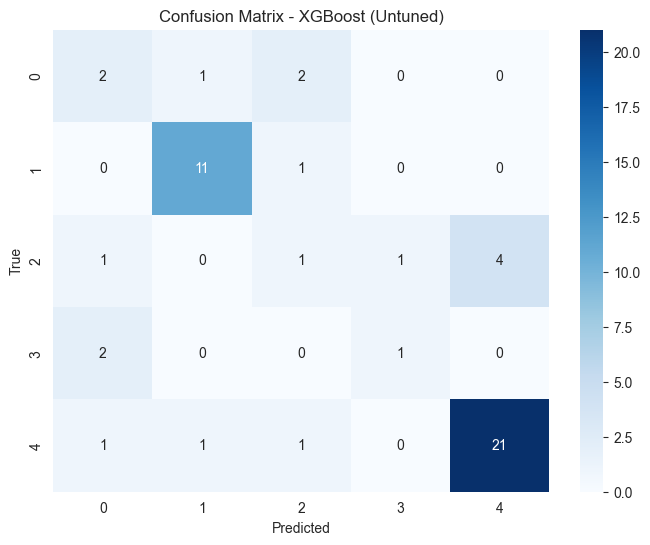


2. Precision and Recall Metrics:
Model: XGBoost (Untuned)
Precision: 0.6839
Recall: 0.7059



In [48]:
trainer.train_models(models=['xgb'], task='classification', hyperparameter_tuning=False, show_viz=True)

Training SVM (Untuned) Classifier...
CLASSIFICATION VISUALIZATIONS FOR: SVM (Untuned)

1. Confusion Matrix:


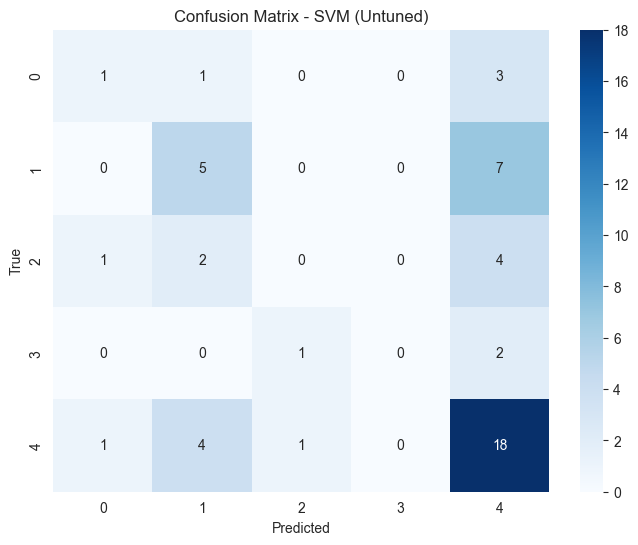


2. Precision and Recall Metrics:
Model: SVM (Untuned)
Precision: 0.3799
Recall: 0.4706



In [49]:
trainer.train_models(models=['svm'], task='classification', hyperparameter_tuning=False, show_viz=True)

### Classification - Tuned Models

REGRESSION VISUALIZATIONS FOR: Decision Tree (Tuned)

1. Model Performance Metrics:
   R² Score: 0.7460
   RMSE: 12.0611
   MAE: 6.7837

2. Actual vs Predicted Values:


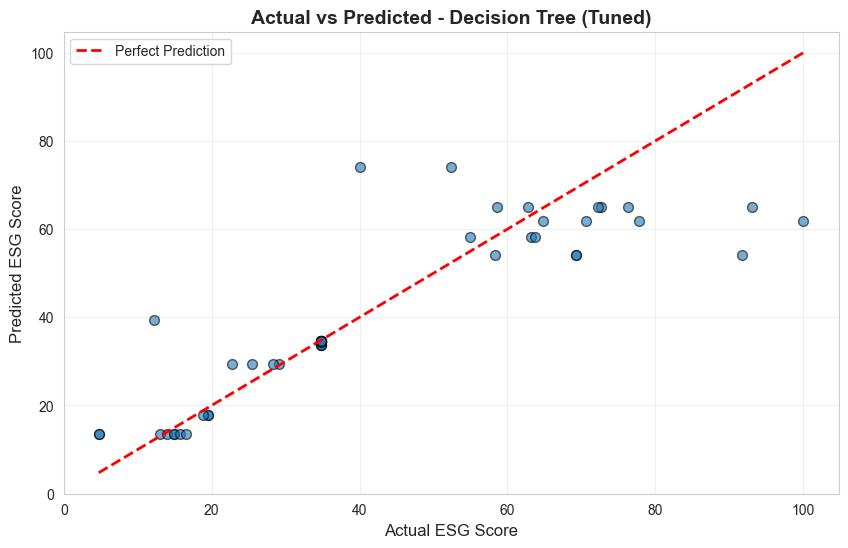


3. Residuals Plot:


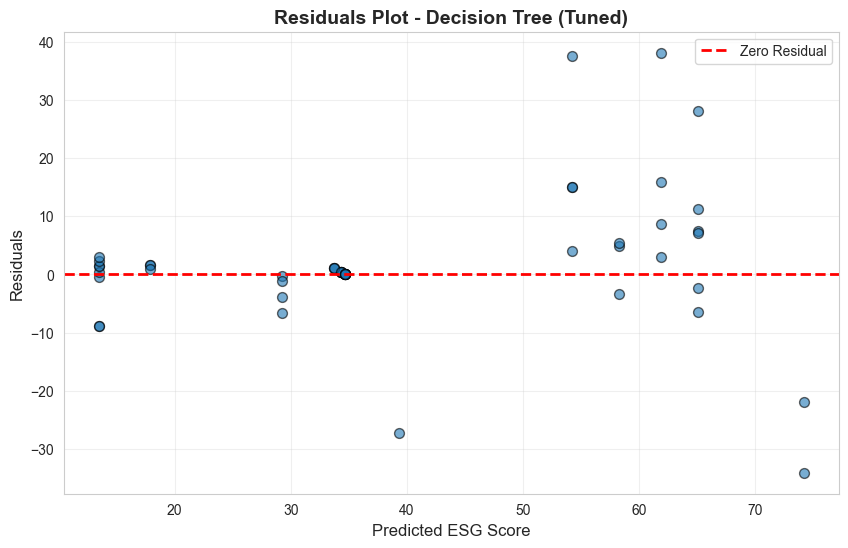


4. Residuals Distribution:


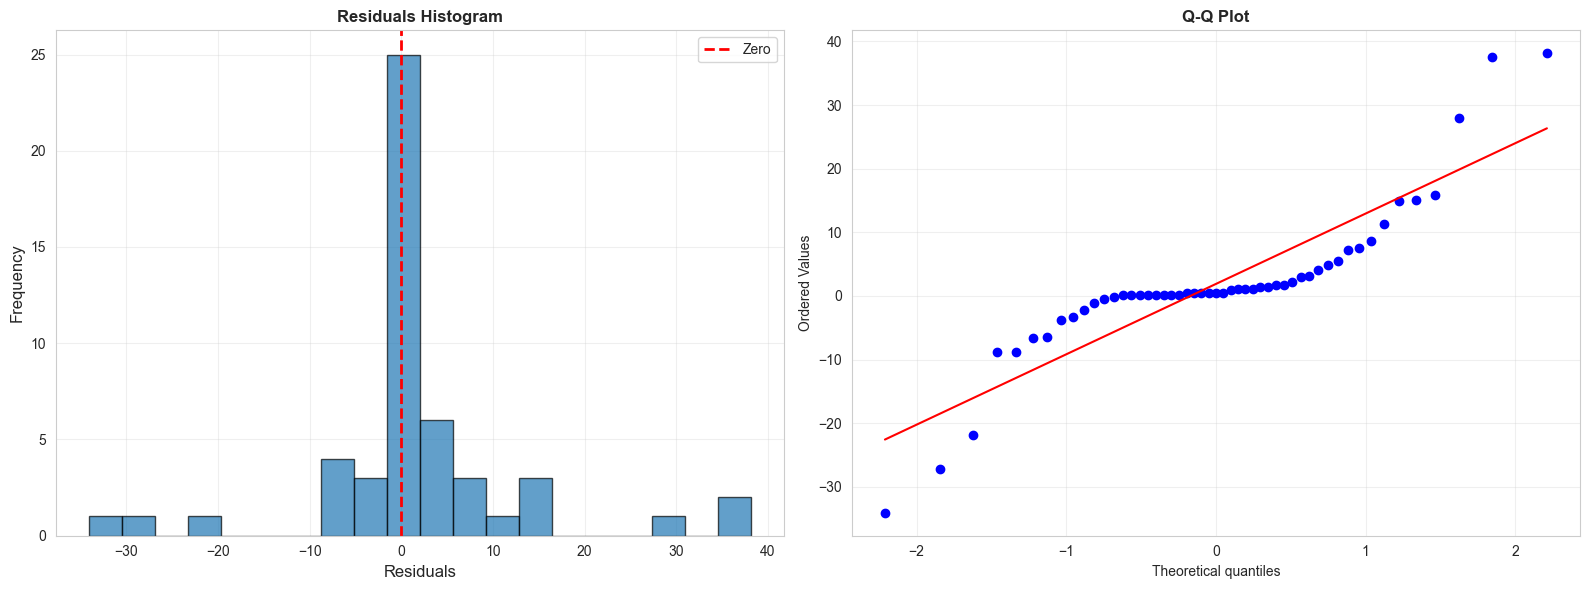


5. Error Metrics Summary:
   Mean Squared Error (MSE): 145.4711
   Root Mean Squared Error (RMSE): 12.0611
   Mean Absolute Error (MAE): 6.7837
   R² Score: 0.7460
   Mean Actual Value: 42.0092
   Mean Predicted Value: 40.1257
   Std of Residuals: 11.9132

6. Prediction Error Distribution:


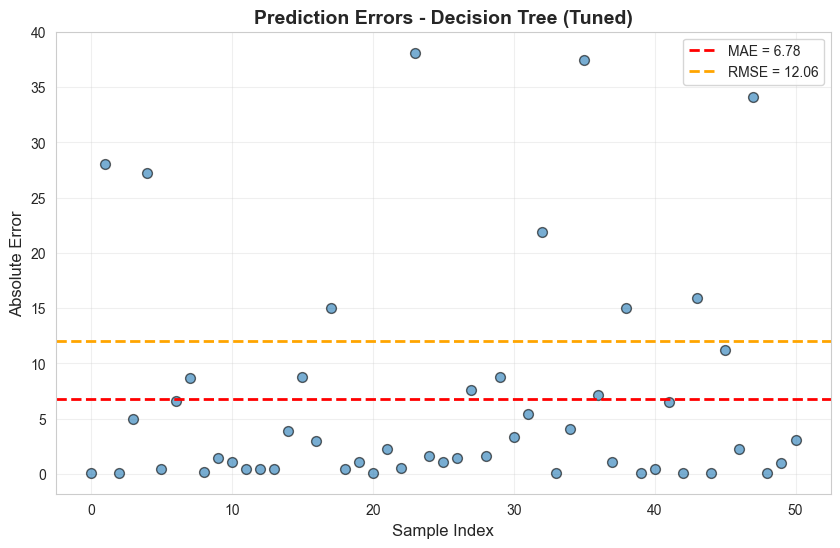


Training Decision Tree (Tuned) Classifier...
---> Hyperparameter tuning...
Fitting 3 folds for each of 3240 candidates, totalling 9720 fits
CLASSIFICATION VISUALIZATIONS FOR: Decision Tree (Tuned)

1. Confusion Matrix:


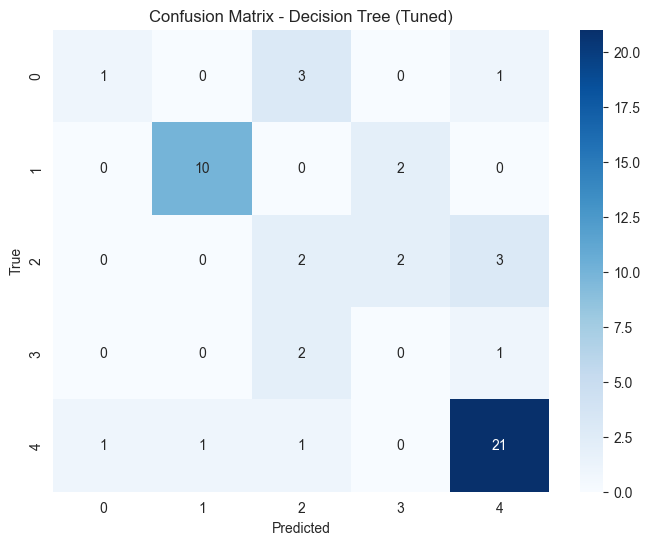


2. Precision and Recall Metrics:
Model: Decision Tree (Tuned)
Precision: 0.6773
Recall: 0.6667



In [50]:
trainer.train_models(models=['dt'], task='classification', hyperparameter_tuning=True, show_viz=True)

REGRESSION VISUALIZATIONS FOR: AdaBoost (Tuned)

1. Model Performance Metrics:
   R² Score: 0.7550
   RMSE: 11.8457
   MAE: 7.3079

2. Actual vs Predicted Values:


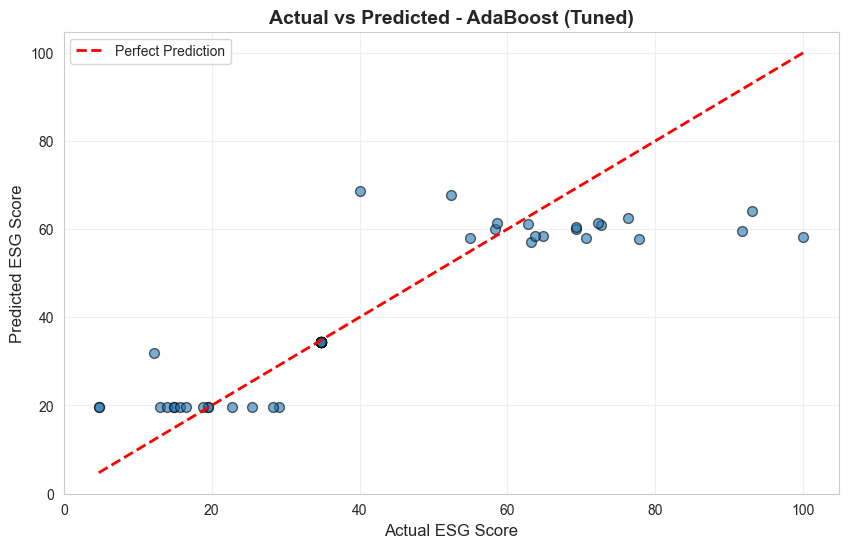


3. Residuals Plot:


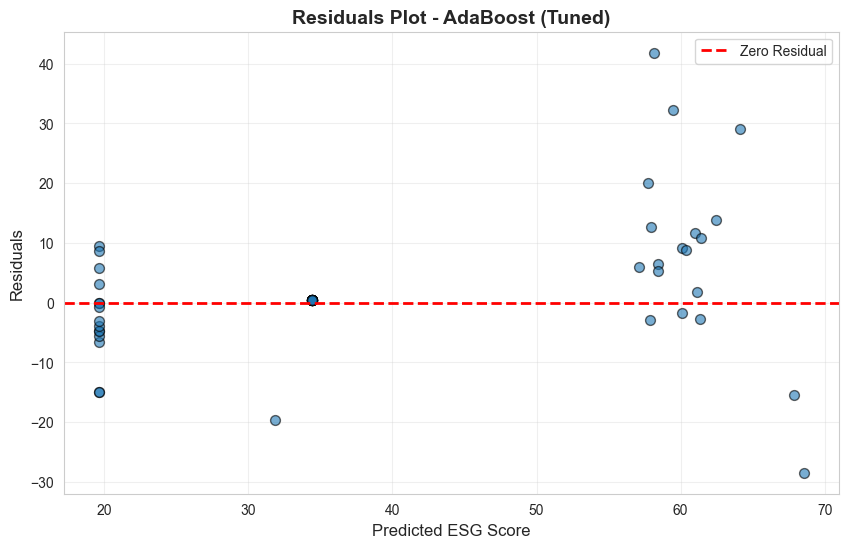


4. Residuals Distribution:


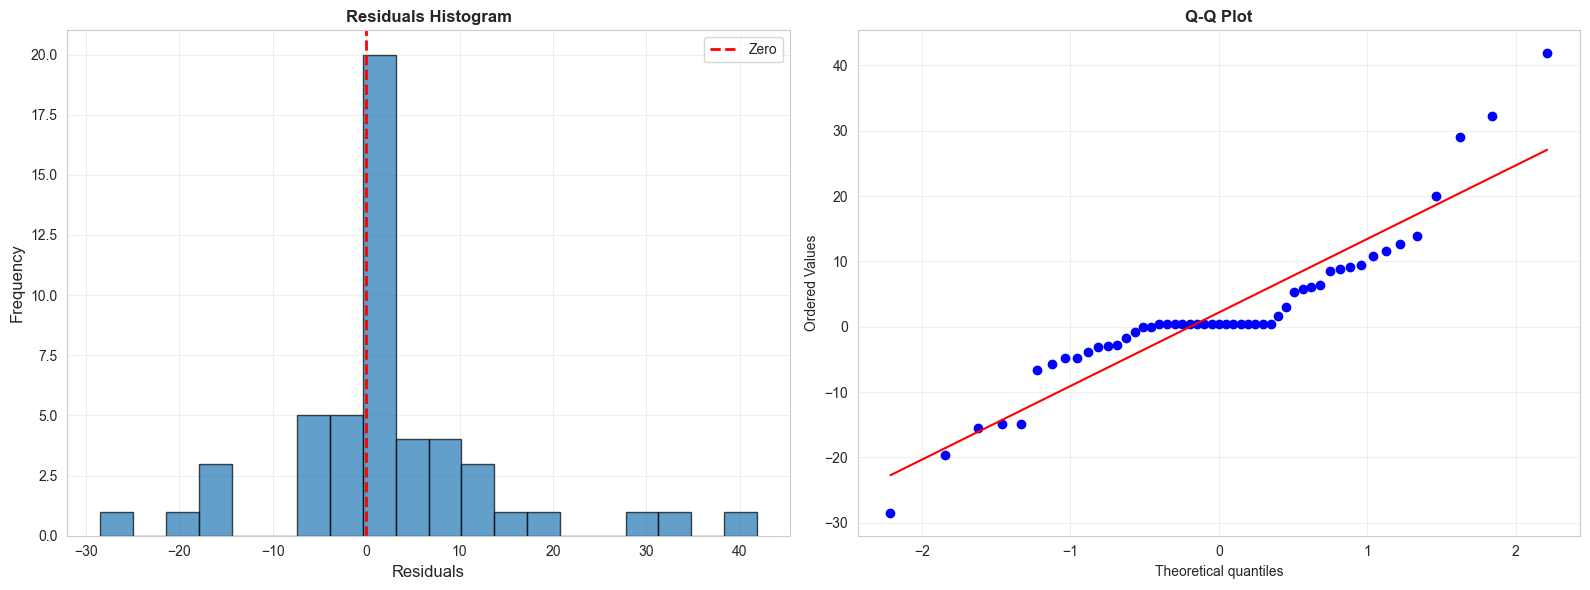


5. Error Metrics Summary:
   Mean Squared Error (MSE): 140.3204
   Root Mean Squared Error (RMSE): 11.8457
   Mean Absolute Error (MAE): 7.3079
   R² Score: 0.7550
   Mean Actual Value: 42.0092
   Mean Predicted Value: 39.8219
   Std of Residuals: 11.6420

6. Prediction Error Distribution:


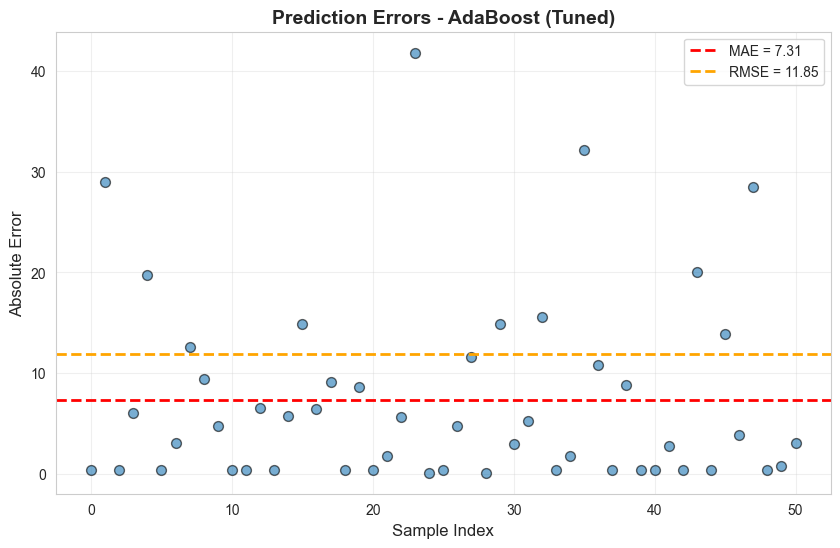


Training AdaBoost (Tuned) Classifier...
---> Hyperparameter tuning...
Fitting 3 folds for each of 45 candidates, totalling 135 fits
CLASSIFICATION VISUALIZATIONS FOR: AdaBoost (Tuned)

1. Confusion Matrix:


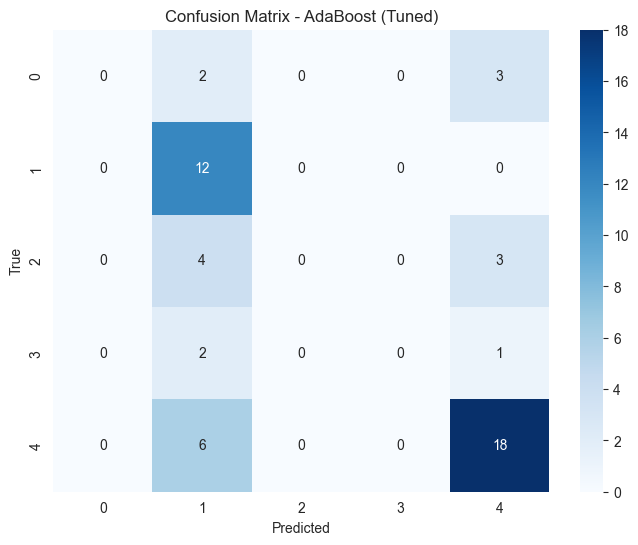


2. Precision and Recall Metrics:
Model: AdaBoost (Tuned)
Precision: 0.4474
Recall: 0.5882



In [51]:
trainer.train_models(models=['ab'], task='classification', hyperparameter_tuning=True, show_viz=True)

Training Random Forest (Tuned) Classifier...
---> Hyperparameter tuning...
Fitting 3 folds for each of 36288 candidates, totalling 108864 fits
CLASSIFICATION VISUALIZATIONS FOR: Random Forest (Tuned)

1. Confusion Matrix:


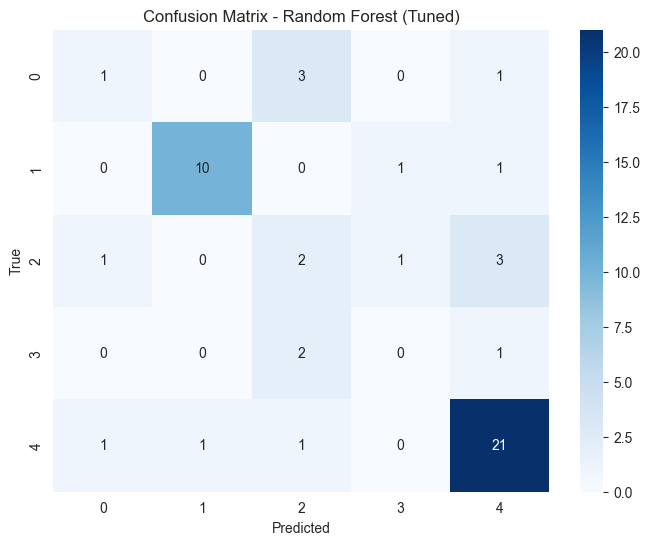


2. Precision and Recall Metrics:
Model: Random Forest (Tuned)
Precision: 0.6469
Recall: 0.6667



In [52]:
trainer.train_models(models=['rf'], task='classification', hyperparameter_tuning=True, show_viz=True)

Training XGBoost (Tuned) Classifier...
---> Hyperparameter tuning...
Fitting 3 folds for each of 540 candidates, totalling 1620 fits
CLASSIFICATION VISUALIZATIONS FOR: XGBoost (Tuned)

1. Confusion Matrix:


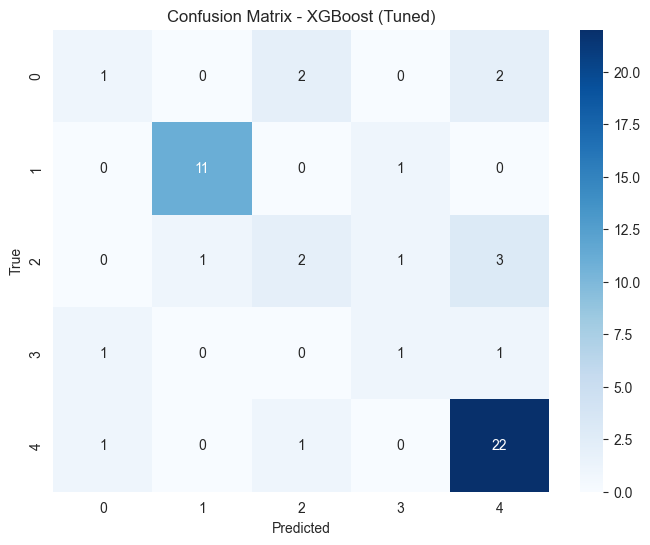


2. Precision and Recall Metrics:
Model: XGBoost (Tuned)
Precision: 0.6926
Recall: 0.7255



In [53]:
trainer.train_models(models=['xgb'], task='classification', hyperparameter_tuning=True, show_viz=True)

Training SVM (Tuned) Classifier...
---> Hyperparameter tuning...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
CLASSIFICATION VISUALIZATIONS FOR: SVM (Tuned)

1. Confusion Matrix:


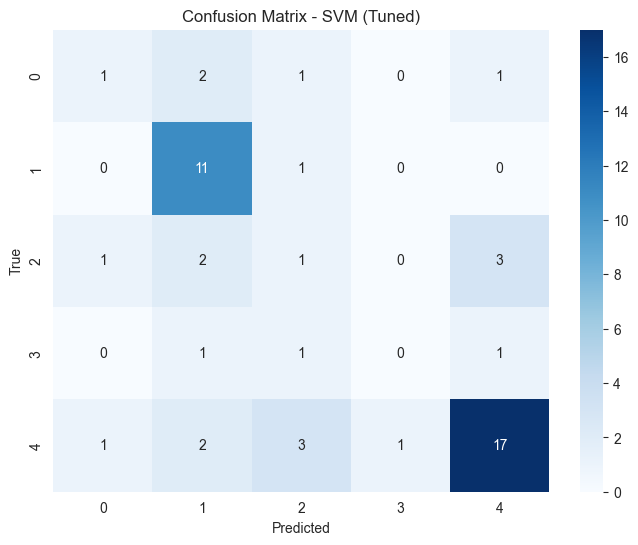


2. Precision and Recall Metrics:
Model: SVM (Tuned)
Precision: 0.5597
Recall: 0.5882



In [54]:
trainer.train_models(models=['svm'], task='classification', hyperparameter_tuning=True, show_viz=True)

In [55]:
trainer.print_model_comparison()

MODEL PERFORMANCE COMPARISON

REGRESSION MODELS (UNTUNED):
--------------------------------------------------------------------------------
Random Forest (Untuned)       : R²=0.7111, RMSE=12.8624, MAE=7.1484
XGBoost (Untuned)             : R²=0.6429, RMSE=14.3012, MAE=7.4126
AdaBoost (Untuned)            : R²=0.6059, RMSE=15.0229, MAE=10.5256
Decision Tree (Untuned)       : R²=0.5813, RMSE=15.4847, MAE=8.3347
SVM (Untuned)                 : R²=0.1297, RMSE=22.3262, MAE=16.6253

REGRESSION MODELS (TUNED):
--------------------------------------------------------------------------------
AdaBoost (Tuned)              : R²=0.7550, RMSE=11.8457, MAE=7.3079
  Best Hyperparameters: {'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 300, 'random_state': 42}
Decision Tree (Tuned)         : R²=0.7460, RMSE=12.0611, MAE=6.7837
  Best Hyperparameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Random Forest (Tuned)         : R²=0.7317, RMSE=1

In [56]:
# Display classification report for the best classification model
y_pred = trainer.models['classification'][trainer.best_clf_name].predict(trainer.X_test_clf)
trainer._classification_report(trainer.y_test_clf, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
        HIGH       0.00      0.00      0.00       5.0
         LOW       0.00      0.00      0.00      12.0
      MEDIUM       0.00      0.00      0.00       7.0
 MEDIUM-HIGH       0.00      0.00      0.00       3.0
  MEDIUM-LOW       0.00      0.00      0.00      24.0

    accuracy                           0.00      51.0
   macro avg       0.00      0.00      0.00      51.0
weighted avg       0.00      0.00      0.00      51.0



---
## Step 6: Model Evaluation and Comparison


In [57]:
# Get feature importance from best models
importance = trainer.feature_importance(task='both', top_n=5)

if 'regression' in importance:
    print(f"Top Features for {trainer.best_reg_name} (Regression):")
    print(importance['regression'])

if 'classification' in importance:
    print(f"Top Features for {trainer.best_clf_name} (Classification):")
    print(importance['classification'])

Top Features for AdaBoost (Tuned) (Regression):
                      Feature  Importance
1               scope1+2total    0.838194
2                      brands    0.134970
0  scope2emitundifferentiated    0.026837
Top Features for XGBoost (Tuned) (Classification):
                      Feature  Importance
2                      brands    0.410291
1               scope1+2total    0.330171
0  scope2emitundifferentiated    0.259538


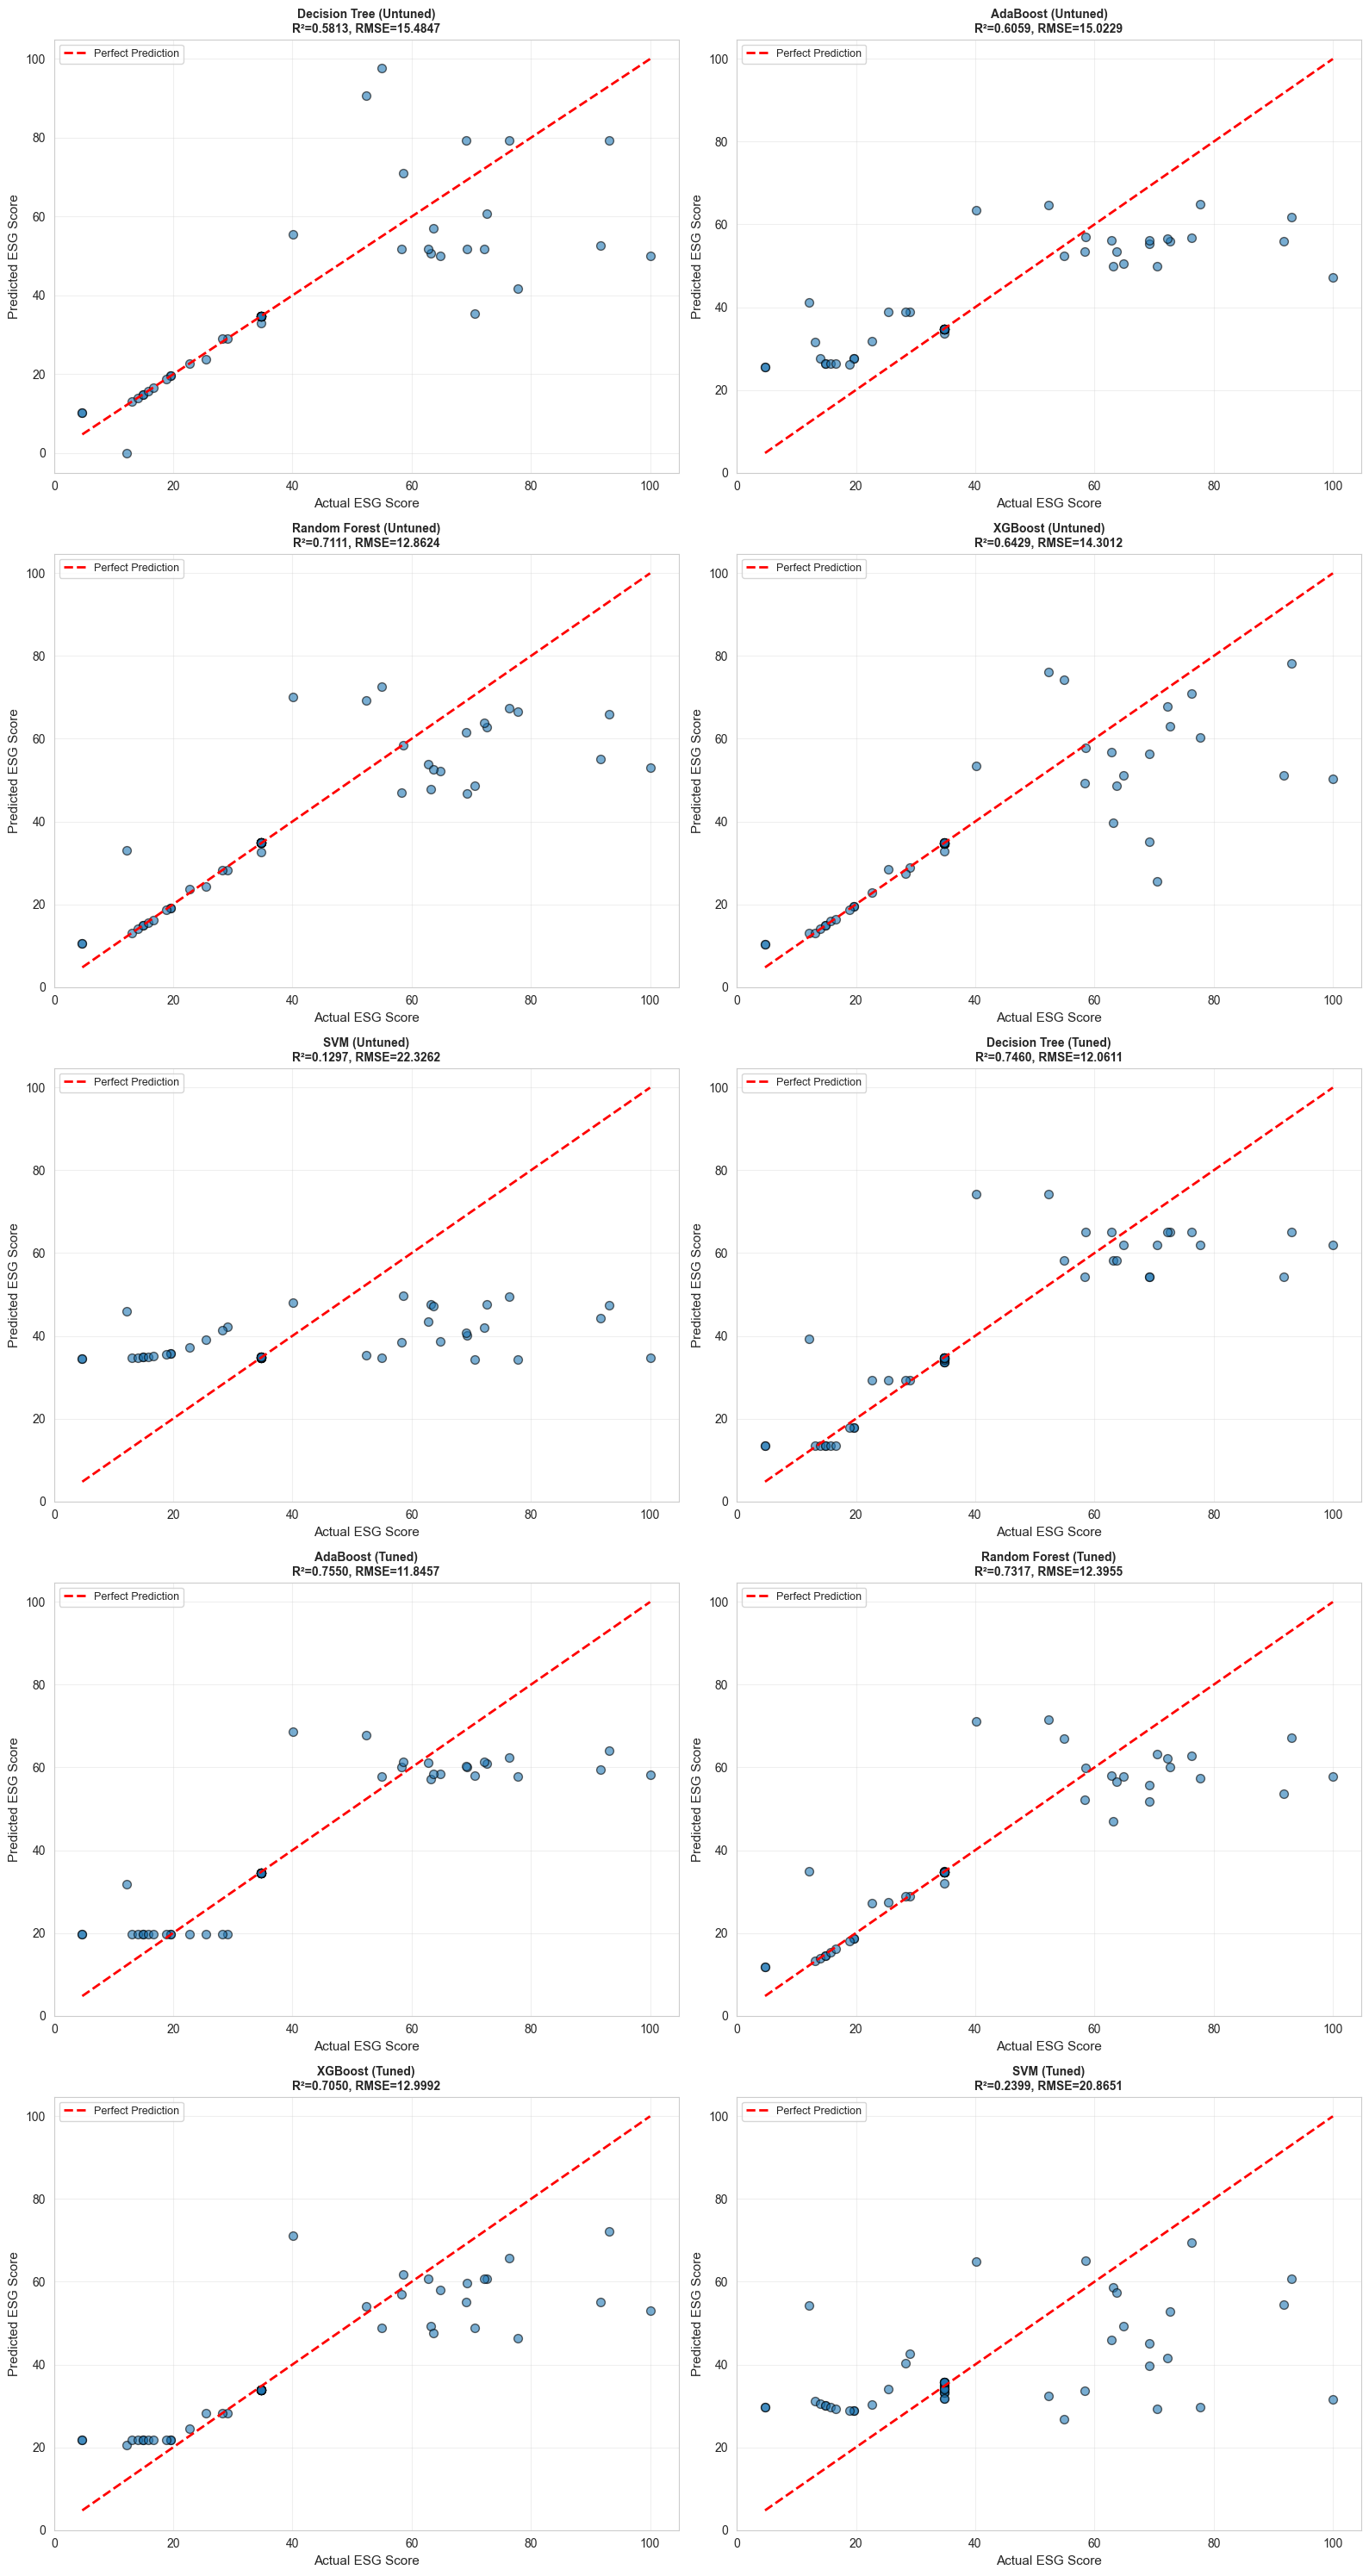

Classification Model Performance:
Decision Tree (Untuned)        [UNTUNED]: Accuracy=0.6078, F1-Score=0.6214
AdaBoost (Untuned)             [UNTUNED]: Accuracy=0.5882, F1-Score=0.5607
Random Forest (Untuned)        [UNTUNED]: Accuracy=0.6275, F1-Score=0.6128
XGBoost (Untuned)              [UNTUNED]: Accuracy=0.7059, F1-Score=0.6925
SVM (Untuned)                  [UNTUNED]: Accuracy=0.4706, F1-Score=0.4146
Decision Tree (Tuned)          [TUNED]: Accuracy=0.6667, F1-Score=0.6645
AdaBoost (Tuned)               [TUNED]: Accuracy=0.5882, F1-Score=0.4943
Random Forest (Tuned)          [TUNED]: Accuracy=0.6667, F1-Score=0.6533
XGBoost (Tuned)                [TUNED]: Accuracy=0.7255, F1-Score=0.7037
SVM (Tuned)                    [TUNED]: Accuracy=0.5882, F1-Score=0.5645


In [58]:
# Plot actual vs predicted
trainer.plot_predictions(task='regression')
trainer.plot_predictions(task='classification')

---
## Step 7: Summary


ESG MODEL TRAINER - COMPREHENSIVE SUMMARY

DATA INFORMATION:
  Total samples: 251
  Features: 3
  Training samples (regression): 200
  Test samples (regression): 51
  Training samples (classification): 200
  Test samples (classification): 51

RISK DISTRIBUTION:
esg_risk
HIGH            23
LOW             58
MEDIUM          35
MEDIUM-HIGH     16
MEDIUM-LOW     119
Name: count, dtype: int64

HYPERPARAMETERS:
  CV Folds: 3
  Random State: 42
  Percentiles: {'low': 5, 'medium_low': 23, 'medium': 55, 'medium_high': 78}
MODEL PERFORMANCE COMPARISON

REGRESSION MODELS (UNTUNED):
--------------------------------------------------------------------------------
Random Forest (Untuned)       : R²=0.7111, RMSE=12.8624, MAE=7.1484
XGBoost (Untuned)             : R²=0.6429, RMSE=14.3012, MAE=7.4126
AdaBoost (Untuned)            : R²=0.6059, RMSE=15.0229, MAE=10.5256
Decision Tree (Untuned)       : R²=0.5813, RMSE=15.4847, MAE=8.3347
SVM (Untuned)                 : R²=0.1297, RMSE=22.3262, MAE=16.625

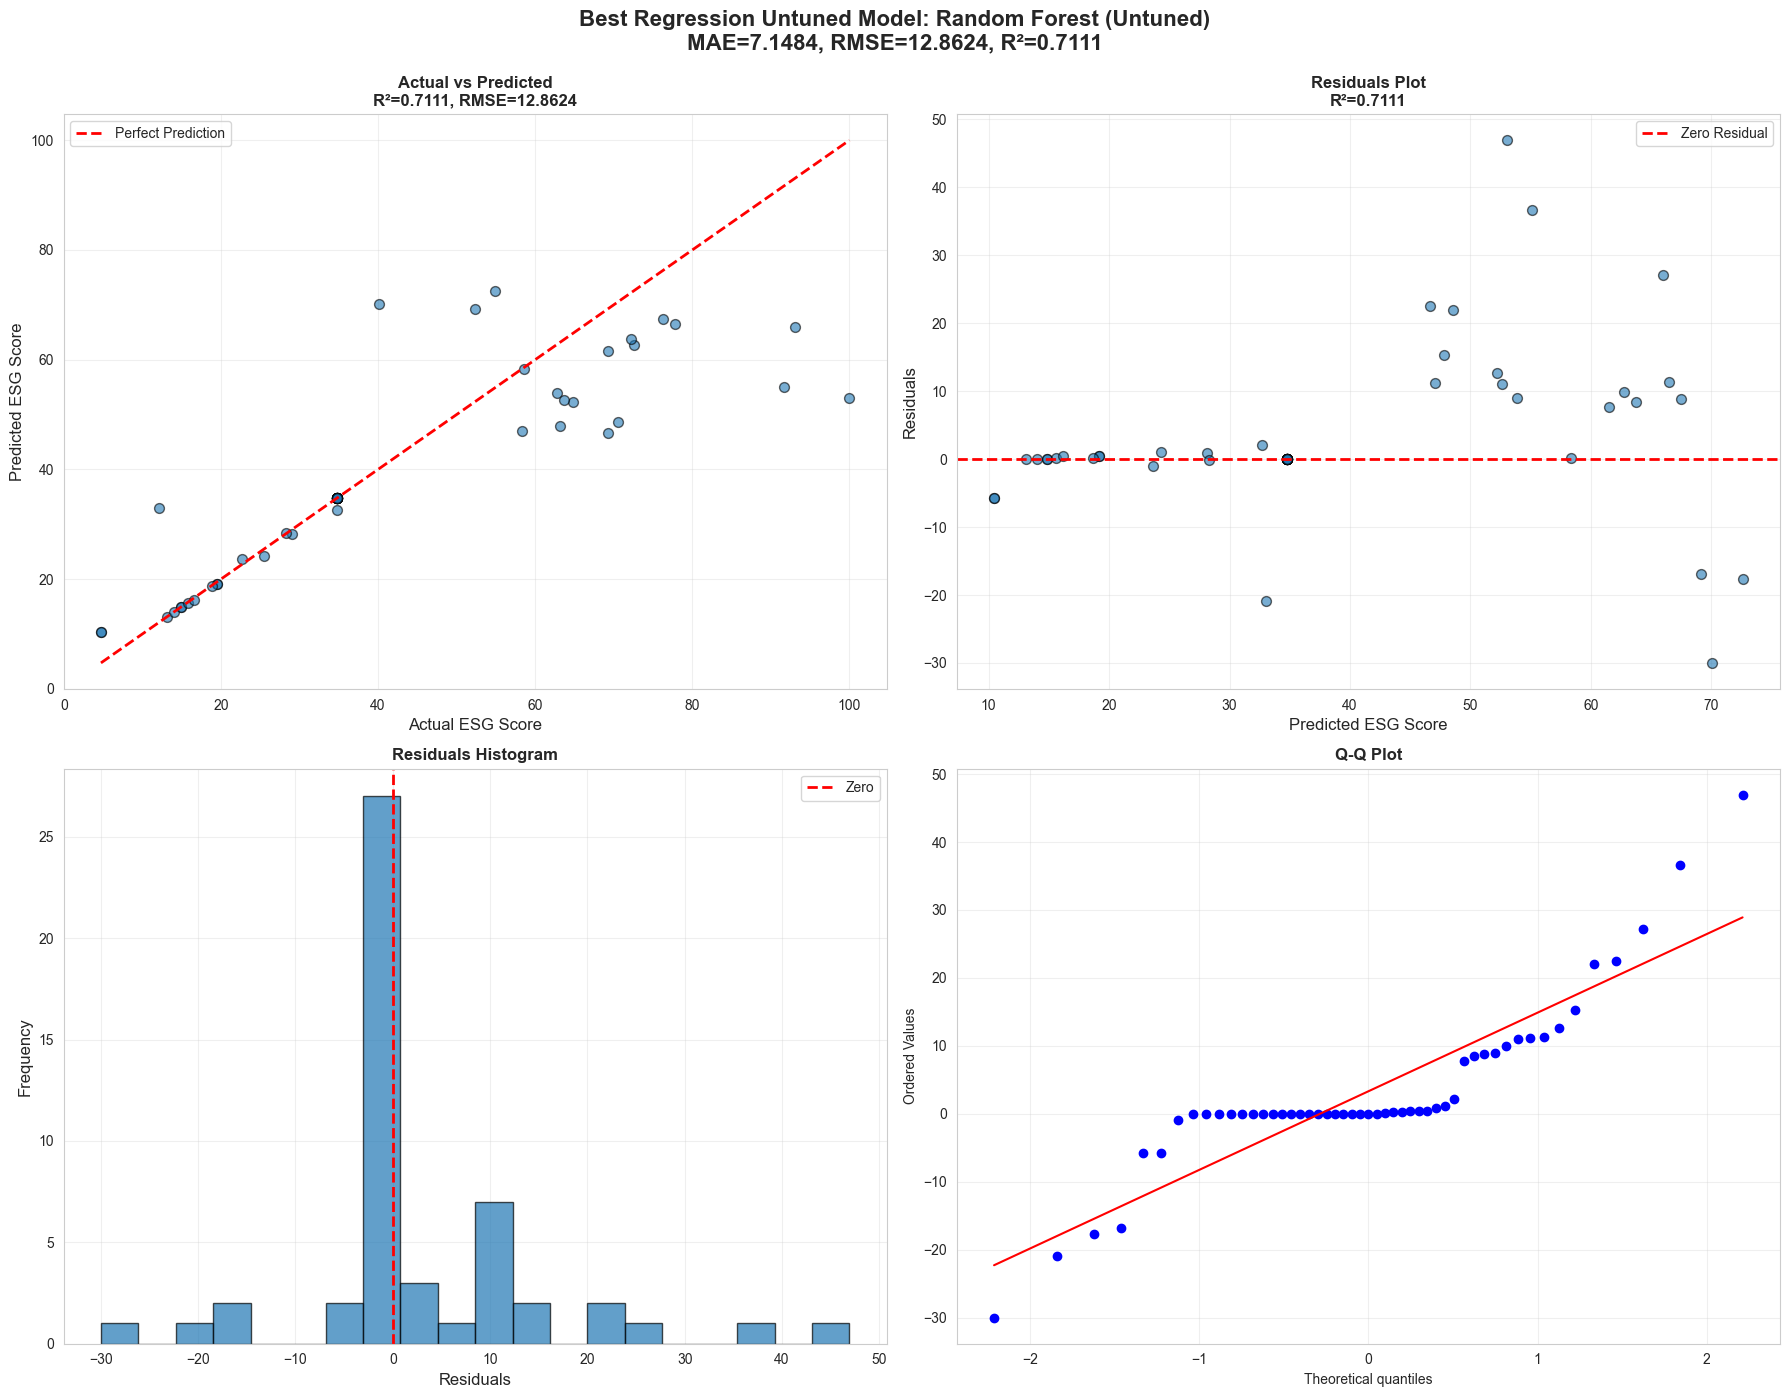


  Displaying plots for Worst Regression Untuned Model: SVM (Untuned)


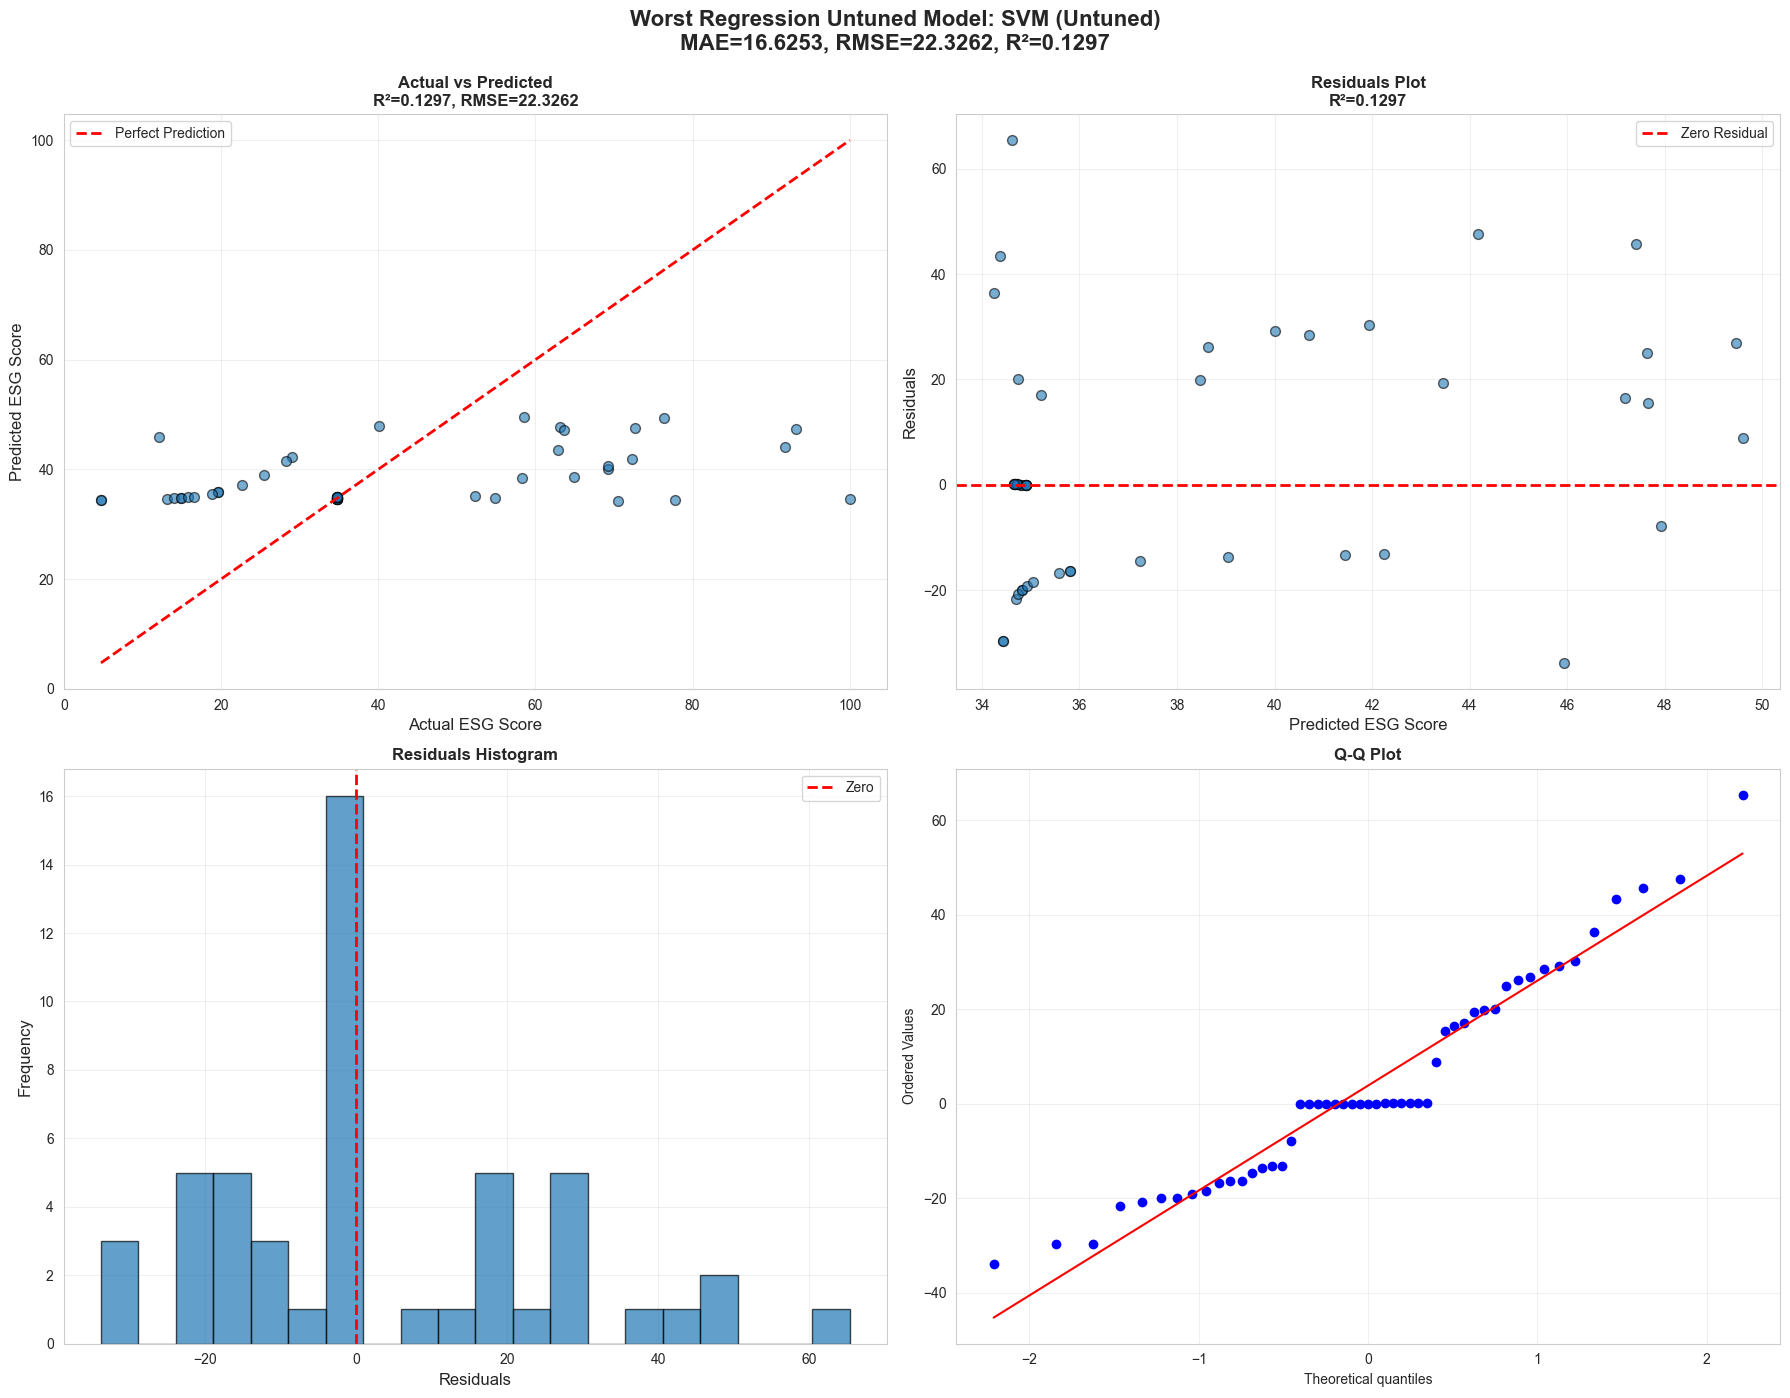


  Displaying plots for Best Regression Tuned Model: AdaBoost (Tuned)


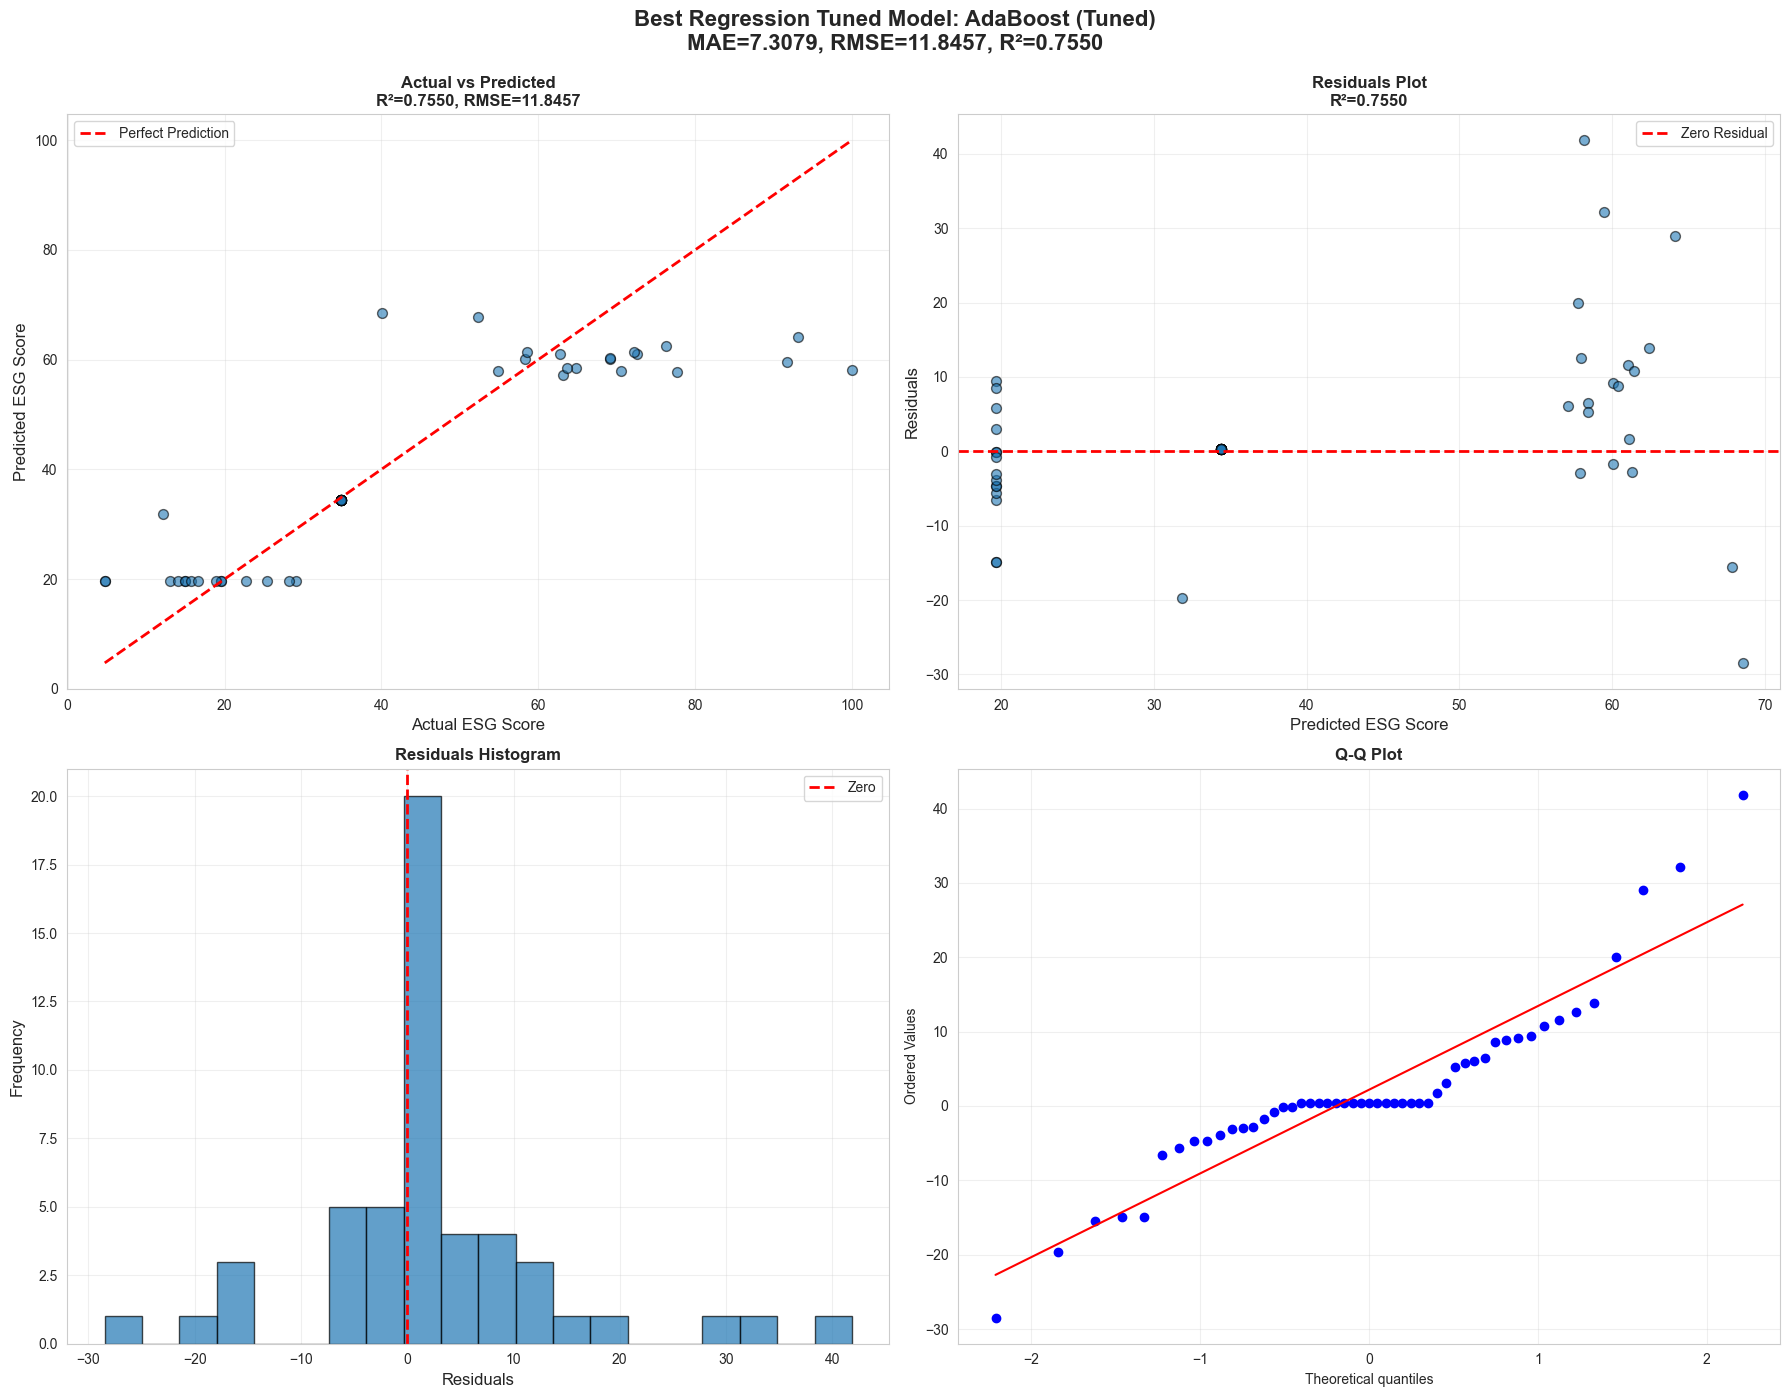


  Displaying plots for Worst Regression Tuned Model: SVM (Tuned)


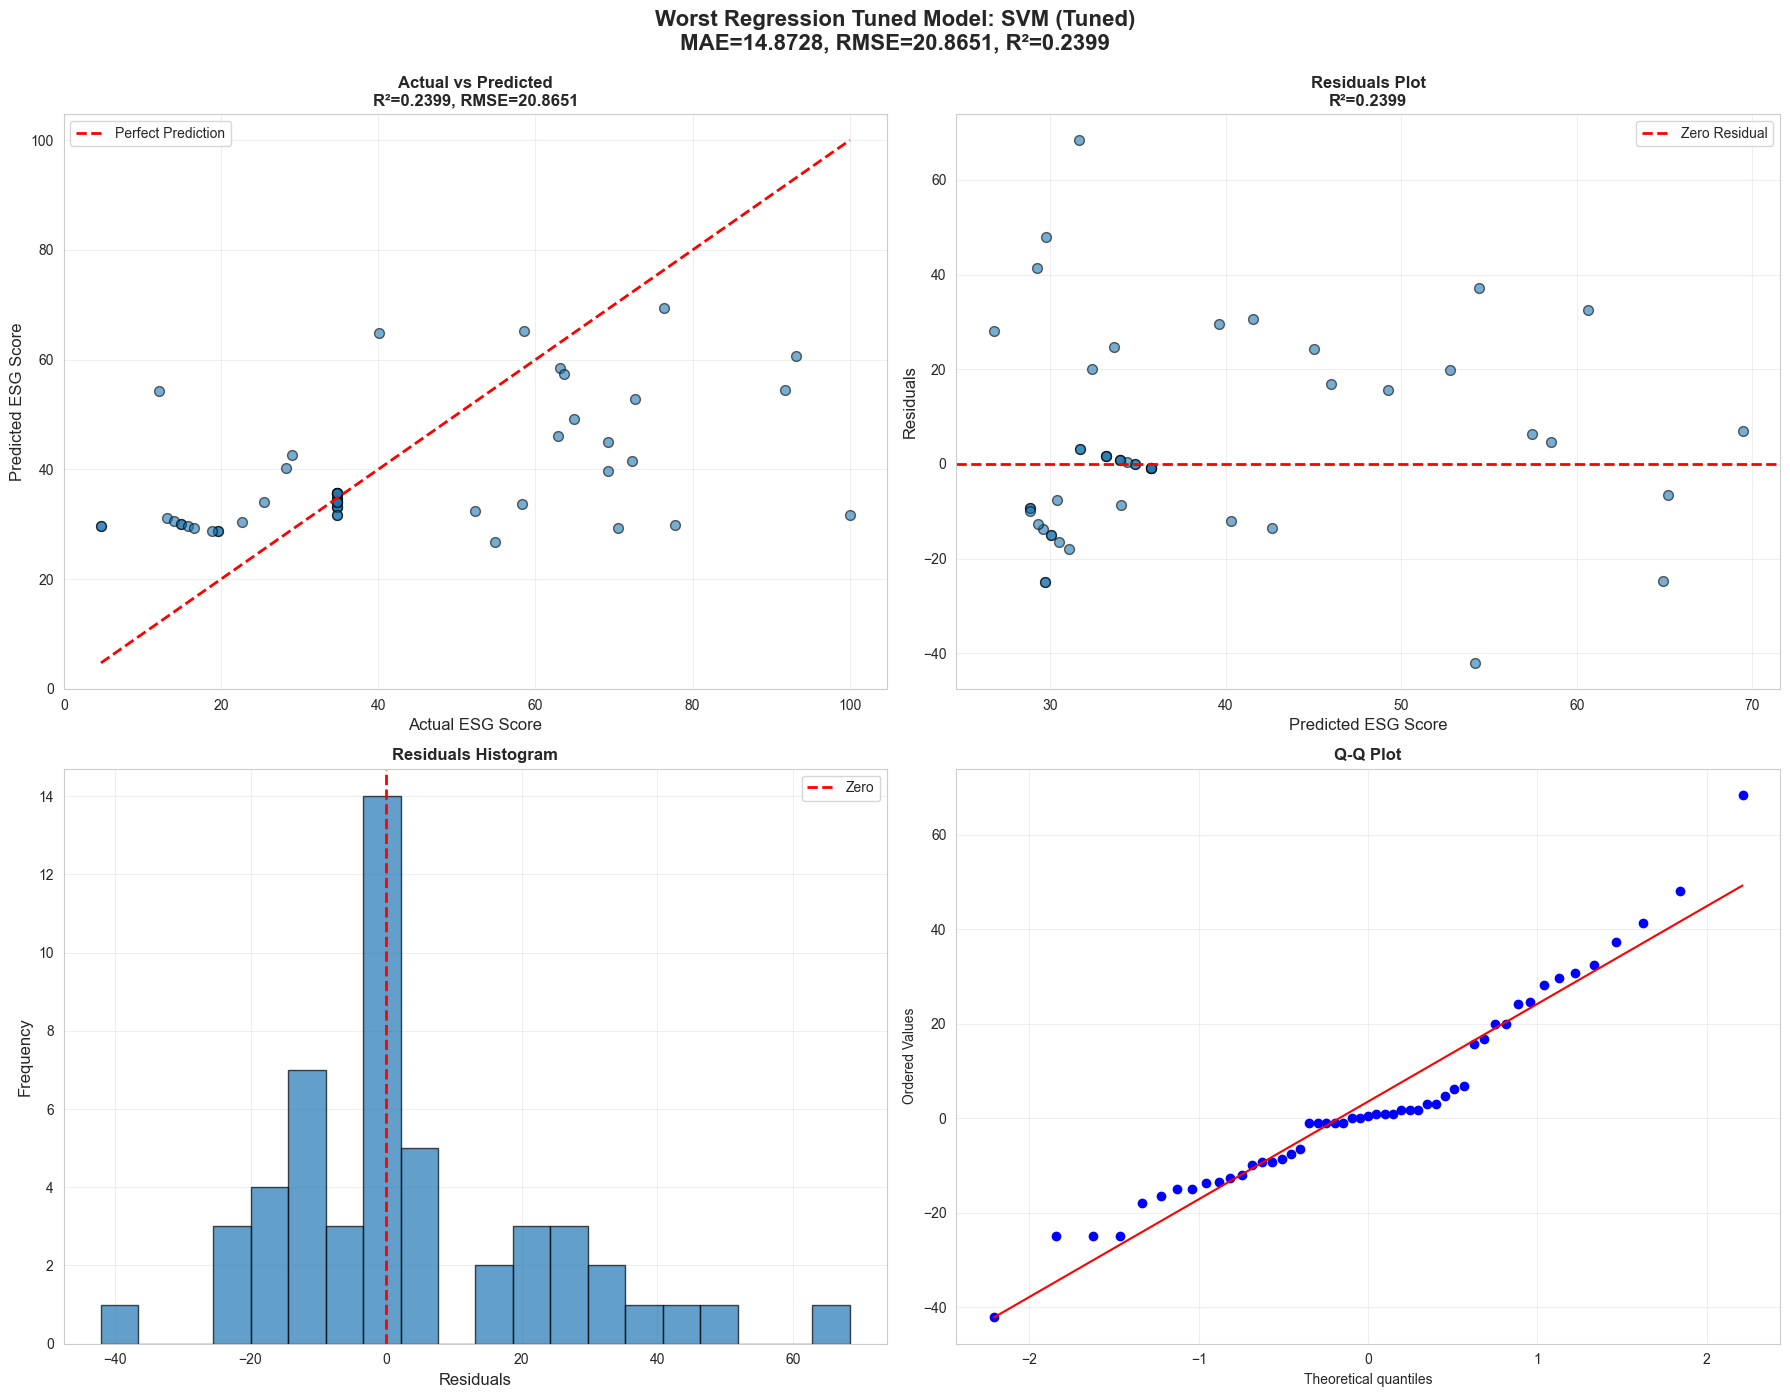


Processing CLASSIFICATION models...
  Best Untuned model: XGBoost (Untuned) (F1=0.6925)
  Worst Untuned model: SVM (Untuned) (F1=0.4146)
  Best Tuned model: XGBoost (Tuned) (F1=0.7037)
  Worst Tuned model: AdaBoost (Tuned) (F1=0.4943)

  Displaying plots for Best Classification Untuned Model: XGBoost (Untuned)


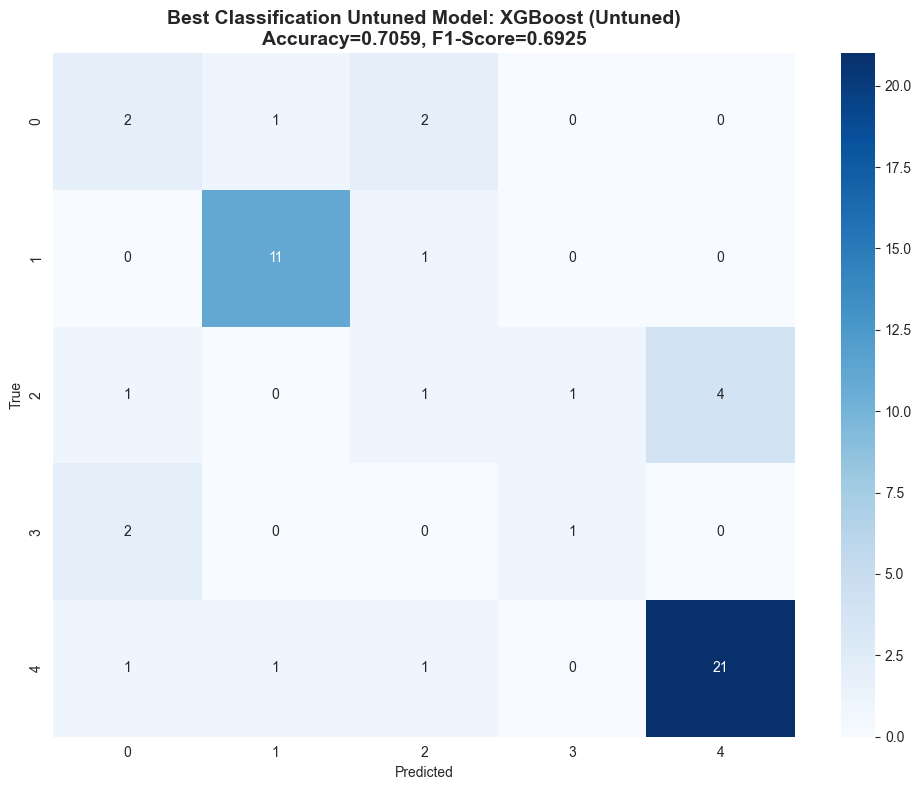


  Displaying plots for Worst Classification Untuned Model: SVM (Untuned)


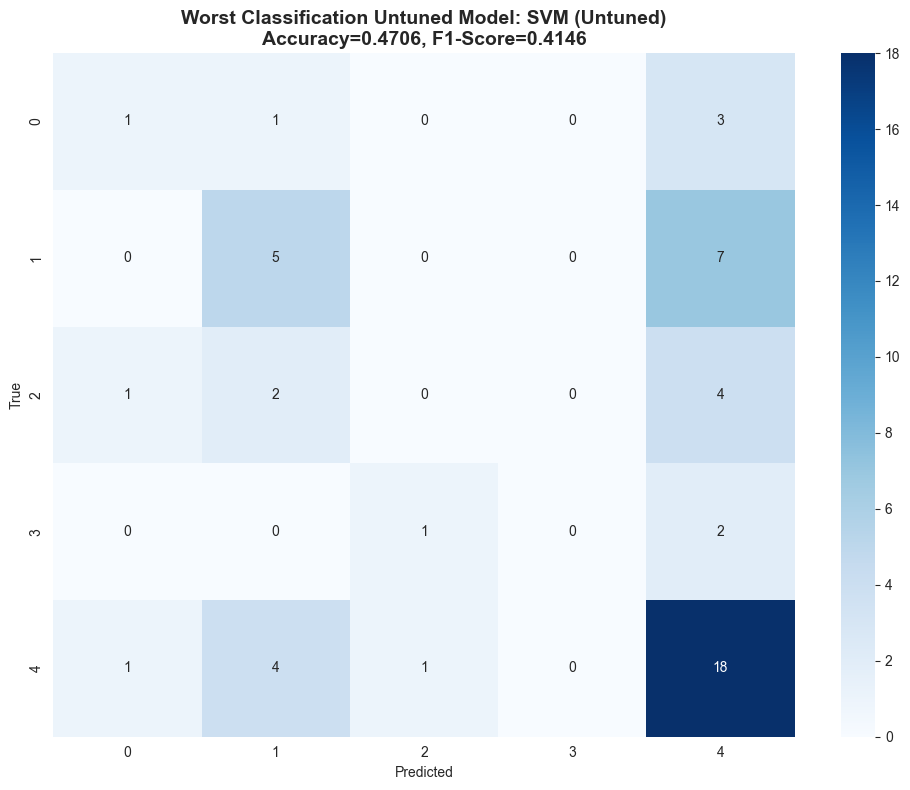


  Displaying plots for Best Classification Tuned Model: XGBoost (Tuned)


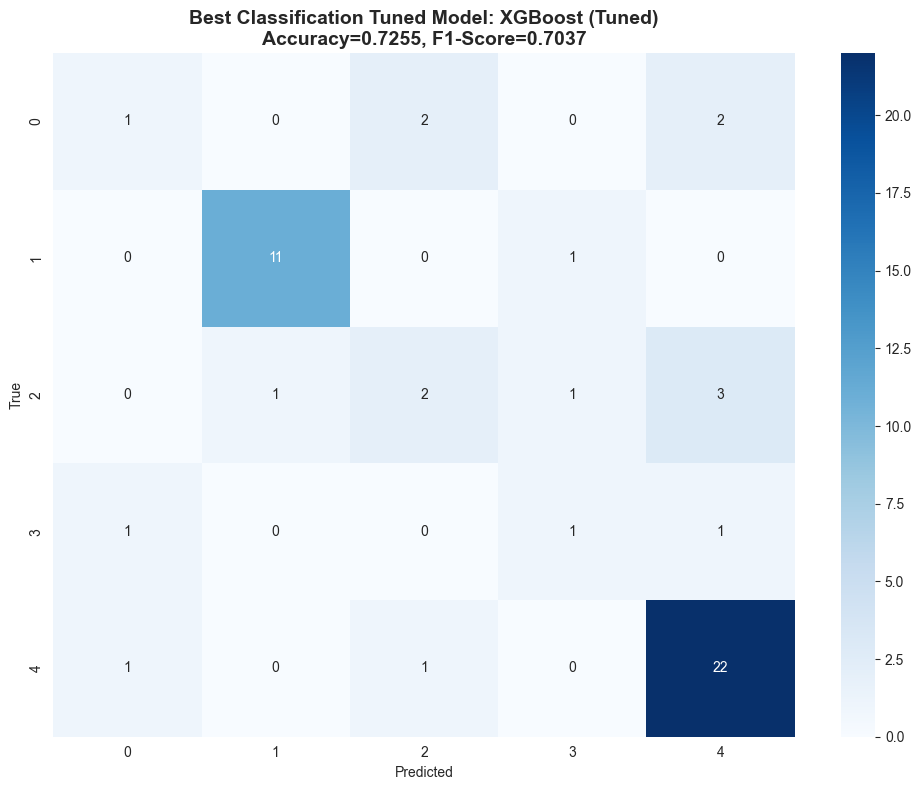


  Displaying plots for Worst Classification Tuned Model: AdaBoost (Tuned)


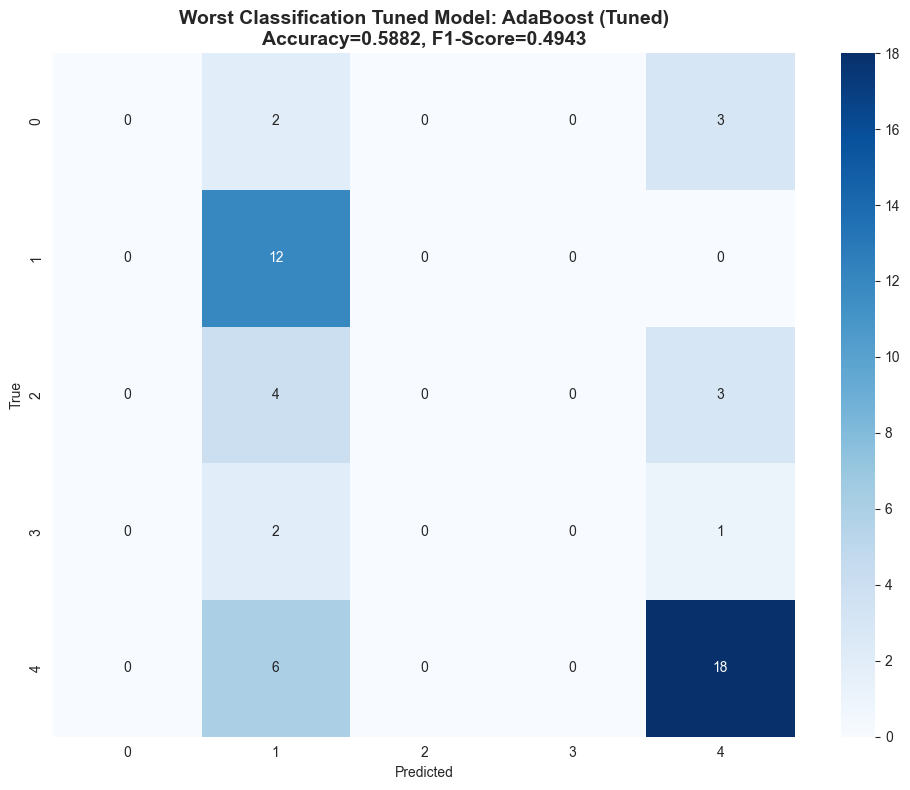


All plots displayed!



In [59]:
# Generate comprehensive summary
trainer.summary(display_plots=True)